# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


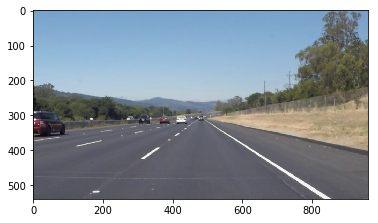

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lSlope = []
    lLine = []
    rSlope = []
    rLine = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1)/(x2 - x1))
            
            if slope < 0:
                lSlope.append(slope)
                lLine.append(line)
            else:
                rSlope.append(slope)
                rLine.append(line)
                                        
    lAvgSlope = np.mean(lSlope, axis = 0)
    rAvgSlope = np.mean(rSlope, axis = 0)
    print(lSlope, rSlope)
    lIntercept = None
    rIntercept = None
    for line in lLine:
        for x1, y1, x2, y2 in line:
            lIntercept = y1 - lAvgSlope * x1
            break
    for line in rLine:
        for x1, y1, x2, y2 in line:
            rIntercept = y1 - rAvgSlope * x1
            break
    if lIntercept is not None:
        lLineY1 = 330
        lLineY2 = img.shape[1]
        lLineX1 = int((lLineY1 - lIntercept) / lAvgSlope)  
        lLineX2 = int((lLineY2 - lIntercept) / lAvgSlope)
        cv2.line(img, (lLineX1, lLineY1), (lLineX2, lLineY2), color, thickness)
    if rIntercept is not None:
        rLineY1 = 330
        rLineY2 = img.shape[1]
        rLineX1 = int((rLineY1 - rIntercept) / rAvgSlope)  
        rLineX2 = int((rLineY2 - rIntercept) / rAvgSlope)
        cv2.line(img, (rLineX1, rLineY1), (rLineX2, rLineY2), color, thickness)
    
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines1(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns the lines detected
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


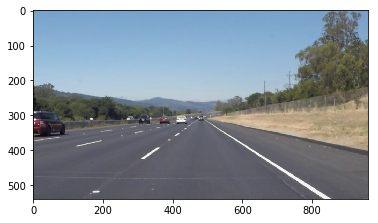

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

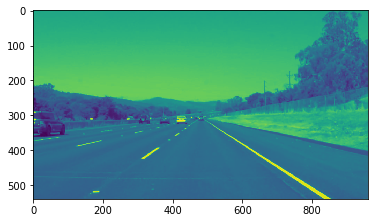

In [6]:

# Read in and grayscale the image
gray = grayscale(image)
plt.imshow(gray)

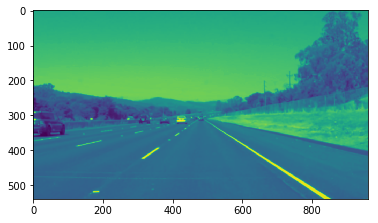

In [7]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray =gaussian_blur(gray,kernel_size)
plt.imshow(blur_gray)

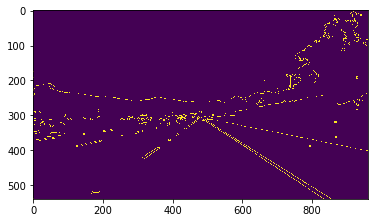

In [8]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges)


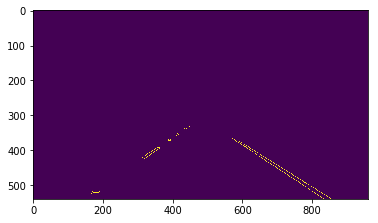

In [9]:
# This time we are defining a four sided polygon to mask
imshape = edges.shape
vertices = np.array([[(0,imshape[0]),(450, 330), (490, 330), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges)

[-0.67391304347826086, -0.72093023255813948, -0.66666666666666663] [0.60824742268041232, 0.63636363636363635, 0.65765765765765771]


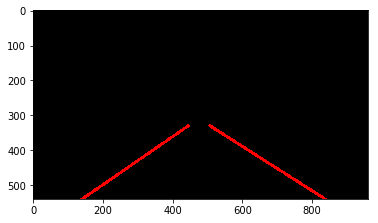

In [10]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 5 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = hough_lines1(masked_edges,rho, theta, threshold, min_line_length, max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, lines)
plt.imshow(line_img)

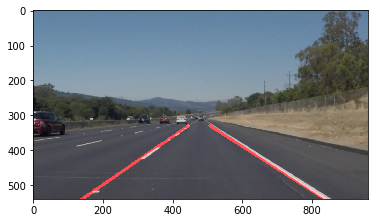

In [11]:
final_img = weighted_img(line_img, image, α=0.8, β=1., γ=0.)
plt.imshow(final_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    
    kernel_size = 5
    blur_gray =gaussian_blur(gray,kernel_size)
    
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    imshape = edges.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines1(masked_edges,rho, theta, threshold, min_line_length, max_line_gap)
    line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    final_img = weighted_img(line_img, image, α=0.8, β=1., γ=0.)
    return final_img

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[-0.73043478260869565, -0.77173913043478259, -0.62222222222222223, -0.74509803921568629, -0.78048780487804881, -0.70731707317073167] [0.59999999999999998, 0.6160714285714286, 0.5714285714285714, 0.60493827160493829, 0.5957446808510638]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 5/222 [00:00<00:04, 46.70it/s]

[-0.73043478260869565, -0.77173913043478259, -0.62222222222222223, -0.74509803921568629, -0.78048780487804881, -0.70731707317073167] [0.59999999999999998, 0.6160714285714286, 0.5714285714285714, 0.60493827160493829, 0.5957446808510638]
[-0.75630252100840334, -0.69767441860465118, -0.68627450980392157, -0.68888888888888888, -0.75630252100840334, -0.61904761904761907, -0.68627450980392157] [0.59999999999999998, 0.58904109589041098, 0.62430939226519333, 0.59999999999999998, 0.59999999999999998, 0.61194029850746268]
[-0.7068965517241379, -0.75471698113207553, -0.80487804878048785, -0.63043478260869568, -0.69047619047619047, -0.75555555555555554, -0.75308641975308643] [0.64406779661016944, 0.62011173184357538, 0.55000000000000004, 0.61363636363636365, 0.62015503875968991, 0.63414634146341464]
[-0.69841269841269837, -0.73809523809523814, -0.7678571428571429, -0.73809523809523814, -0.72413793103448276] [0.6012861736334405, 0.60747663551401865, 0.59523809523809523, 0.61403508771929827, 0.59523

  7%|▋         | 15/222 [00:00<00:04, 47.49it/s]

[-0.74603174603174605, -0.676056338028169, -0.68292682926829273] [0.62650602409638556, 0.65853658536585369, 0.61875000000000002, 0.5714285714285714, 0.57499999999999996, 0.61194029850746268, 0.63636363636363635]
[-0.68181818181818177, -0.72093023255813948, -0.75294117647058822, -0.77083333333333337, -0.75757575757575757] [0.61224489795918369, 0.62114537444933926, 0.625, 0.61904761904761907, 0.58208955223880599]
[-0.75471698113207553, -0.68493150684931503, -0.7846153846153846, -0.80487804878048785, -0.67346938775510201, -0.67692307692307696] [0.60747663551401865, 0.66666666666666663, 0.68292682926829273, 0.58695652173913049]
[-0.67500000000000004, -0.72619047619047616, -0.64583333333333337, -0.65116279069767447, -0.71698113207547165, -0.67692307692307696] [0.6230031948881789, 0.65000000000000002, 0.65088757396449703, 0.64000000000000001, 0.65853658536585369, 0.60784313725490191, 0.64583333333333337]
[-0.71739130434782605, -0.77966101694915257, -0.64583333333333337, -0.70833333333333337,

  9%|▉         | 20/222 [00:00<00:04, 47.56it/s]

[-0.69999999999999996] [0.625, 0.66942148760330578, 0.66249999999999998, 0.61904761904761907]


 11%|█▏        | 25/222 [00:00<00:04, 47.48it/s]

[-0.67391304347826086, -0.7142857142857143, -0.66666666666666663] [0.60493827160493829, 0.62820512820512819, 0.6690647482014388, 0.5957446808510638, 0.60759493670886078, 0.67307692307692313]
[-0.68965517241379315, -0.71698113207547165, -0.68518518518518523] [0.60919540229885061, 0.63265306122448983, 0.65853658536585369, 0.63461538461538458]
[-0.69696969696969702, -0.72307692307692306, -0.76923076923076927, -0.72131147540983609] [0.60655737704918034, 0.63513513513513509, 0.59183673469387754, 0.6428571428571429, 0.6470588235294118]
[-0.71951219512195119, -0.67164179104477617, -0.65789473684210531, -0.71153846153846156] [0.6071428571428571, 0.59615384615384615, 0.65284974093264247, 0.58695652173913049, 0.65853658536585369]
[-0.67647058823529416, -0.74193548387096775, -0.6428571428571429, -0.67500000000000004] [0.62295081967213117, 0.65217391304347827, 0.66666666666666663, 0.65384615384615385]
[-0.73015873015873012, -0.67441860465116277, -0.65306122448979587, -0.83333333333333337, -0.68965

 14%|█▎        | 30/222 [00:00<00:04, 46.87it/s]

[] [0.61904761904761907, 0.62418300653594772, 0.6470588235294118, 0.62184873949579833, 0.65217391304347827, 0.64893617021276595]


 16%|█▌        | 35/222 [00:00<00:03, 47.73it/s]

[] [0.65053763440860213, 0.6228813559322034, 0.61702127659574468, 0.625, 0.6376811594202898, 0.59523809523809523, 0.61904761904761907, 0.62264150943396224, 0.61643835616438358]
[] [0.65000000000000002, 0.64978902953586493, 0.625, 0.6428571428571429, 0.625, 0.625]
[-0.73809523809523814, -0.70731707317073167] [0.59183673469387754, 0.65187713310580209, 0.63888888888888884, 0.62179487179487181, 0.6428571428571429]
[-0.69090909090909092, -0.73999999999999999, -0.75] [0.65853658536585369, 0.64965986394557829, 0.65853658536585369, 0.6376811594202898, 0.64000000000000001, 0.62962962962962965]
[-0.72307692307692306, -0.7142857142857143, -0.72307692307692306] [0.62195121951219512, 0.65156794425087106, 0.61290322580645162, 0.65000000000000002, 0.65517241379310343, 0.63636363636363635]
[-0.71604938271604934, -0.66666666666666663, -0.8571428571428571, -0.62790697674418605, -0.71739130434782605, -0.67441860465116277] [0.60563380281690138, 0.64473684210526316, 0.67088607594936711, 0.61702127659574468

 18%|█▊        | 41/222 [00:00<00:03, 48.65it/s]

[] [0.65765765765765771, 0.6244897959183674, 0.61403508771929827, 0.65909090909090906, 0.66216216216216217, 0.63636363636363635]
[] [0.62681159420289856, 0.65789473684210531, 0.63380281690140849, 0.61111111111111116, 0.61224489795918369]
[]

 21%|██        | 46/222 [00:01<00:06, 26.31it/s]

 [0.62546816479400746, 0.65432098765432101, 0.61363636363636365, 0.625]
[-0.71111111111111114, -0.80000000000000004, -0.69767441860465118, -0.75609756097560976, -0.70731707317073167] [0.62549800796812749, 0.63793103448275867, 0.6875, 0.65441176470588236]
[-0.69090909090909092, -0.75510204081632648, -0.68085106382978722, -0.76595744680851063] [0.62601626016260159, 0.65384615384615385, 0.63414634146341464, 0.63043478260869568, 0.61904761904761907]
[-0.68181818181818177, -0.75, -0.69999999999999996] [0.61038961038961037, 0.67361111111111116, 0.67129629629629628, 0.6607142857142857, 0.62820512820512819, 0.65909090909090906]


 23%|██▎       | 50/222 [00:01<00:07, 22.40it/s]

[-0.70731707317073167, -0.75641025641025639, -0.76744186046511631, -0.68888888888888888] [0.62857142857142856, 0.60919540229885061, 0.651685393258427, 0.5957446808510638, 0.63829787234042556, 0.63043478260869568, 0.66666666666666663]
[-0.74489795918367352, -0.69999999999999996, -0.73913043478260865, -0.71999999999999997, -0.76923076923076927, -0.76923076923076927] [0.625, 0.6875, 0.61403508771929827, 0.65765765765765771]
[-0.7021276595744681, -0.72881355932203384, -0.7407407407407407, -0.68656716417910446, -0.6875] [0.67253521126760563, 0.64150943396226412, 0.67148014440433212, 0.66129032258064513, 0.64814814814814814, 0.67307692307692313]
[-0.69911504424778759, -0.77192982456140347, -0.72727272727272729, -0.7142857142857143, -0.68493150684931503, -0.68627450980392157] [0.625, 0.67253521126760563, 0.65000000000000002, 0.61290322580645162, 0.6741071428571429, 0.63793103448275867, 0.60784313725490191]


 24%|██▍       | 54/222 [00:01<00:08, 19.65it/s]

[-0.67469879518072284, -0.74137931034482762, -0.63043478260869568, -0.73333333333333328, -0.67307692307692313, -0.67500000000000004] [0.63636363636363635, 0.64000000000000001, 0.64000000000000001, 0.65909090909090906]
[] [0.62692307692307692, 0.65714285714285714, 0.6875, 0.65217391304347827, 0.63076923076923075]
[] [0.62650602409638556, 0.64925373134328357, 0.64000000000000001, 0.60655737704918034, 0.69090909090909092]
[] [0.62616822429906538, 0.67357512953367871, 0.67330677290836649, 0.6097560975609756]


 26%|██▌       | 57/222 [00:01<00:09, 18.01it/s]

[-0.65000000000000002] [0.625, 0.67195767195767198, 0.70731707317073167, 0.6607142857142857, 0.66000000000000003, 0.61702127659574468]
[-0.67391304347826086, -0.72093023255813948, -0.67391304347826086] [0.62598425196850394, 0.65306122448979587, 0.70731707317073167, 0.64000000000000001]
[-0.74468085106382975, -0.64912280701754388, -0.69811320754716977] [0.6706586826347305, 0.6244897959183674, 0.6029411764705882, 0.63043478260869568, 0.65116279069767447, 0.62222222222222223]
[-0.64150943396226412, -0.67647058823529416, -0.71875, -0.75438596491228072, -0.67741935483870963, -0.72727272727272729] [0.625, 0.65322580645161288, 0.60784313725490191, 0.63095238095238093, 0.68292682926829273]


 27%|██▋       | 60/222 [00:02<00:09, 17.51it/s]

[-0.65000000000000002, -0.72499999999999998, -0.625, -0.60869565217391308, -0.67441860465116277, -0.72222222222222221] [0.62841530054644812, 0.65517241379310343, 0.63095238095238093, 0.60919540229885061, 0.60784313725490191, 0.63414634146341464]
[-0.71739130434782605, -0.75, -0.63414634146341464, -0.77272727272727271, -0.64406779661016944] [0.61403508771929827, 0.67346938775510201, 0.61194029850746268, 0.63076923076923075, 0.66176470588235292, 0.65853658536585369]
[-0.71794871794871795, -0.65957446808510634, -0.63636363636363635, -0.73809523809523814, -0.65306122448979587] [0.65151515151515149, 0.63157894736842102, 0.7142857142857143, 0.6428571428571429, 0.59999999999999998, 0.60784313725490191, 0.65217391304347827, 0.66666666666666663]
[-0.66972477064220182, -0.72277227722772275, -0.70297029702970293] [0.69230769230769229, 0.64563106796116509, 0.6875, 0.64734299516908211, 0.69387755102040816, 0.68888888888888888]


 29%|██▉       | 65/222 [00:02<00:09, 16.45it/s]

[-0.70769230769230773, -0.66666666666666663, -0.75609756097560976, -0.72727272727272729] [0.63235294117647056, 0.69298245614035092, 0.61403508771929827, 0.62857142857142856, 0.6097560975609756, 0.61363636363636365, 0.6097560975609756]
[-0.63934426229508201, -0.67500000000000004] [0.62962962962962965, 0.67469879518072284, 0.62827225130890052, 0.67961165048543692, 0.69767441860465118, 0.68518518518518523]
[-0.7321428571428571] [0.64406779661016944, 0.67313915857605178, 0.62871287128712872, 0.64485981308411211, 0.68518518518518523]
[] [0.66666666666666663, 0.66216216216216217, 0.64000000000000001, 0.64550264550264547, 0.6428571428571429, 0.6428571428571429, 0.63414634146341464]


 31%|███       | 69/222 [00:02<00:09, 16.05it/s]

[] [0.66981132075471694, 0.62564102564102564, 0.68918918918918914, 0.6283783783783784]
[-0.67441860465116277, -0.73170731707317072, -0.65116279069767447] [0.67266187050359716, 0.62962962962962965, 0.65957446808510634, 0.61904761904761907]
[-0.66666666666666663, -0.7142857142857143, -0.65306122448979587] [0.64782608695652177, 0.65591397849462363, 0.66666666666666663, 0.62790697674418605, 0.67500000000000004, 0.59523809523809523]
[-0.72499999999999998, -0.625, -0.72580645161290325, -0.67164179104477617] [0.6404494382022472, 0.63636363636363635, 0.61403508771929827, 0.6428571428571429, 0.65909090909090906]


 33%|███▎      | 73/222 [00:02<00:09, 16.04it/s]

[-0.72131147540983609, -0.625, -0.77358490566037741, -0.71153846153846156, -0.65853658536585369] [0.67464114832535882, 0.66666666666666663, 0.63076923076923075, 0.66666666666666663, 0.68518518518518523]
[-0.69902912621359226, -0.6454545454545455, -0.65671641791044777, -0.76271186440677963, -0.6506024096385542] [0.63076923076923075, 0.67426710097719866, 0.625, 0.67938931297709926, 0.62987012987012991]
[-0.69724770642201839, -0.64864864864864868, -0.76190476190476186, -0.72307692307692306, -0.61363636363636365, -0.71999999999999997] [0.63043478260869568, 0.61111111111111116, 0.67647058823529416, 0.63414634146341464, 0.66233766233766234, 0.67368421052631577]


 35%|███▍      | 77/222 [00:03<00:09, 14.79it/s]

[-0.69911504424778759, -0.65040650406504064, -0.6517857142857143, -0.67441860465116277, -0.66666666666666663, -0.69696969696969702, -0.65000000000000002] [0.64835164835164838, 0.65957446808510634, 0.68000000000000005, 0.65909090909090906]
[-0.69999999999999996, -0.65957446808510634, -0.63414634146341464, -0.59999999999999998, -0.69999999999999996] [0.63013698630136983, 0.67692307692307696, 0.68292682926829273, 0.67289719626168221]
[-0.65000000000000002] [0.62931034482758619, 0.69512195121951215, 0.61904761904761907, 0.7142857142857143, 0.70731707317073167, 0.63934426229508201]
[-0.66666666666666663] [0.65000000000000002, 0.6954022988505747, 0.6428571428571429, 0.63793103448275867, 0.66101694915254239]


 36%|███▋      | 81/222 [00:03<00:09, 15.35it/s]

[] [0.69683257918552033, 0.69387755102040816, 0.66666666666666663, 0.70833333333333337]
[] [0.69741697416974169, 0.66666666666666663, 0.68181818181818177, 0.63492063492063489, 0.69090909090909092]
[-0.68888888888888888, -0.64444444444444449] [0.69911504424778759, 0.64976958525345618, 0.71153846153846156]
[-0.625, -0.660377358490566, -0.68888888888888888, -0.625] [0.65454545454545454, 0.68181818181818177, 0.68181818181818177, 0.70731707317073167, 0.64000000000000001, 0.63793103448275867]


 38%|███▊      | 85/222 [00:03<00:08, 15.67it/s]

[-0.69999999999999996, -0.61971830985915488, -0.66666666666666663] [0.69965870307167233, 0.66891891891891897, 0.69230769230769229, 0.63265306122448983, 0.68518518518518523, 0.68181818181818177, 0.68888888888888888]
[-0.70731707317073167, -0.65000000000000002, -0.66666666666666663, -0.625, -0.67469879518072284] [0.70242214532871972, 0.65445026178010468, 0.68888888888888888]
[-0.67592592592592593, -0.625, -0.62264150943396224, -0.59999999999999998, -0.67307692307692313] [0.6556291390728477, 0.68131868131868134, 0.65384615384615385, 0.71621621621621623, 0.65000000000000002]
[-0.6310679611650486, -0.6875, -0.60416666666666663, -0.70833333333333337, -0.72093023255813948, -0.72093023255813948, -0.71739130434782605] [0.70138888888888884, 0.65254237288135597, 0.66129032258064513]


 40%|████      | 89/222 [00:04<00:08, 15.75it/s]

[-0.65040650406504064, -0.69736842105263153, -0.6470588235294118, -0.68085106382978722, -0.66000000000000003] [0.64948453608247425, 0.70279720279720281, 0.65497076023391809, 0.69230769230769229, 0.65000000000000002]
[-0.65116279069767447, -0.70370370370370372, -0.69999999999999996] [0.70175438596491224, 0.66216216216216217, 0.69767441860465118, 0.69333333333333336, 0.68852459016393441]
[-0.65000000000000002] [0.70967741935483875, 0.71698113207547165, 0.63793103448275867, 0.73999999999999999]


 41%|████      | 91/222 [00:04<00:08, 15.70it/s]

[] [0.70238095238095233, 0.67073170731707321, 0.63461538461538458, 0.66956521739130437, 0.70129870129870131]
[] [0.65408805031446537, 0.71212121212121215, 0.72222222222222221, 0.73809523809523814, 0.68493150684931503]
[-0.65000000000000002] [0.67355371900826444, 0.72432432432432436, 0.66666666666666663, 0.68292682926829273, 0.68627450980392157]
[-0.67500000000000004, -0.65957446808510634] [0.70930232558139539, 0.71830985915492962]


 43%|████▎     | 95/222 [00:04<00:07, 15.98it/s]

[-0.6071428571428571, -0.73809523809523814] [0.66891891891891897, 0.7142857142857143, 0.70466321243523311, 0.68965517241379315, 0.63829787234042556, 0.7142857142857143, 0.67532467532467533]
[-0.61428571428571432, -0.6964285714285714, -0.7142857142857143, -0.671875] [0.71717171717171713, 0.66666666666666663, 0.74137931034482762, 0.64000000000000001, 0.76086956521739135, 0.68421052631578949]
[-0.65476190476190477, -0.69999999999999996, -0.69047619047619047, -0.63414634146341464, -0.7021276595744681] [0.73999999999999999, 0.67669172932330823, 0.6742424242424242, 0.74285714285714288, 0.70149253731343286]
[-0.69333333333333336, -0.64761904761904765, -0.69411764705882351, -0.66666666666666663, -0.6588235294117647, -0.69565217391304346] [0.70588235294117652, 0.67901234567901236, 0.6517857142857143, 0.7407407407407407, 0.65853658536585369, 0.64948453608247425, 0.70370370370370372]


 45%|████▍     | 99/222 [00:04<00:08, 15.12it/s]

[-0.64583333333333337, -0.69767441860465118, -0.66666666666666663, -0.72499999999999998, -0.63414634146341464] [0.72413793103448276, 0.67586206896551726, 0.7142857142857143, 0.65909090909090906, 0.67777777777777781]
[-0.67441860465116277, -0.69411764705882351, -0.625, -0.625, -0.70731707317073167, -0.6216216216216216, -0.68627450980392157] [0.72560975609756095, 0.67716535433070868, 0.68292682926829273, 0.74137931034482762, 0.66666666666666663, 0.74468085106382975, 0.72093023255813948]
[-0.64583333333333337, -0.68292682926829273, -0.69999999999999996, -0.72340425531914898, -0.6428571428571429] [0.67836257309941517, 0.72549019607843135, 0.68518518518518523, 0.6428571428571429, 0.65853658536585369, 0.68292682926829273, 0.71111111111111114]


 46%|████▋     | 103/222 [00:04<00:07, 15.63it/s]

[-0.67441860465116277, -0.63265306122448983, -0.67500000000000004] [0.72413793103448276, 0.69465648854961837, 0.71186440677966101, 0.71153846153846156, 0.74137931034482762, 0.68181818181818177]
[] [0.67622950819672134, 0.72432432432432436, 0.68421052631578949, 0.70833333333333337]
[] [0.66666666666666663, 0.70422535211267601, 0.69047619047619047, 0.69230769230769229]
[] [0.7016574585635359, 0.65625, 0.6875, 0.6428571428571429, 0.63265306122448983]


 48%|████▊     | 107/222 [00:05<00:07, 15.60it/s]

[-0.65217391304347827] [0.67355371900826444, 0.72159090909090906, 0.67500000000000004, 0.73809523809523814]
[-0.660377358490566, -0.64406779661016944, -0.67441860465116277, -0.69999999999999996] [0.65413533834586468, 0.72173913043478266, 0.68571428571428572, 0.66666666666666663, 0.74193548387096775, 0.66666666666666663]
[-0.67391304347826086, -0.67741935483870963, -0.63461538461538458, -0.69811320754716977, -0.67213114754098358] [0.67669172932330823, 0.72142857142857142, 0.66666666666666663, 0.66153846153846152]
[-0.6506024096385542, -0.69736842105263153, -0.63414634146341464, -0.59420289855072461, -0.68421052631578949] [0.65322580645161288, 0.70085470085470081, 0.6428571428571429, 0.6588235294117647, 0.7010309278350515, 0.65306122448979587]


 50%|█████     | 111/222 [00:05<00:06, 16.10it/s]

[-0.72093023255813948, -0.65094339622641506, -0.66666666666666663, -0.63414634146341464] [0.71739130434782605, 0.6733668341708543, 0.72173913043478266, 0.68518518518518523, 0.68333333333333335, 0.72340425531914898]
[-0.64444444444444449, -0.67391304347826086, -0.71999999999999997, -0.7010309278350515, -0.76744186046511631, -0.72499999999999998, -0.65517241379310343] [0.6717557251908397, 0.72027972027972031, 0.66666666666666663, 0.68181818181818177, 0.68888888888888888]
[-0.71641791044776115, -0.65079365079365081, -0.65217391304347827] [0.73913043478260865, 0.65789473684210531, 0.72093023255813948, 0.66216216216216217, 0.68965517241379315, 0.70833333333333337]
[-0.67816091954022983, -0.70833333333333337, -0.69767441860465118] [0.70106761565836295, 0.67123287671232879, 0.6964285714285714, 0.69999999999999996, 0.63636363636363635]


 52%|█████▏    | 115/222 [00:05<00:06, 16.27it/s]

[-0.68292682926829273, -0.67500000000000004] [0.697508896797153, 0.6711711711711712, 0.66990291262135926]
[] [0.68131868131868134, 0.63793103448275867, 0.61363636363636365, 0.63157894736842102, 0.66666666666666663, 0.7142857142857143]
[] [0.69811320754716977, 0.65269461077844315, 0.70731707317073167, 0.66666666666666663, 0.63157894736842102, 0.66000000000000003]
[] [0.69230769230769229, 0.65068493150684936, 0.65909090909090906, 0.69767441860465118, 0.68518518518518523]


 54%|█████▎    | 119/222 [00:05<00:06, 16.06it/s]

[-0.68292682926829273, -0.63043478260869568] [0.65277777777777779, 0.69480519480519476, 0.66666666666666663, 0.6875, 0.62295081967213117]
[-0.69999999999999996, -0.6470588235294118, -0.64814814814814814] [0.65000000000000002, 0.69607843137254899, 0.69767441860465118, 0.64000000000000001]
[-0.64615384615384619, -0.69354838709677424, -0.70175438596491224] [0.63380281690140849, 0.64664310954063609, 0.66216216216216217, 0.6428571428571429, 0.70731707317073167]
[-0.69333333333333336, -0.72222222222222221, -0.68888888888888888, -0.66101694915254239] [0.63043478260869568, 0.71153846153846156, 0.660377358490566, 0.61904761904761907]


 55%|█████▌    | 123/222 [00:06<00:06, 15.96it/s]

[-0.69696969696969702, -0.74137931034482762, -0.66666666666666663, -0.70491803278688525, -0.63265306122448983] [0.62857142857142856, 0.67518248175182483, 0.59999999999999998, 0.65957446808510634, 0.59523809523809523]
[-0.6742424242424242, -0.7407407407407407, -0.67391304347826086, -0.66000000000000003, -0.70909090909090911] [0.62601626016260159, 0.69148936170212771, 0.69354838709677424, 0.61403508771929827, 0.6097560975609756, 0.59999999999999998, 0.69387755102040816]
[-0.6428571428571429, -0.72826086956521741, -0.66101694915254239, -0.62962962962962965, -0.73999999999999999, -0.70422535211267601] [0.62576687116564422, 0.69148936170212771, 0.59090909090909094, 0.70833333333333337]
[-0.70114942528735635, -0.64000000000000001, -0.70370370370370372] [0.62641509433962261, 0.63636363636363635, 0.63829787234042556, 0.66666666666666663, 0.61111111111111116]


 57%|█████▋    | 127/222 [00:06<00:05, 15.99it/s]

[-0.69565217391304346, -0.67307692307692313, -0.66666666666666663, -0.65957446808510634, -0.70454545454545459] [0.64417177914110424, 0.6733668341708543, 0.57499999999999996, 0.68852459016393441, 0.6454545454545455, 0.66153846153846152]
[] [0.63855421686746983, 0.65555555555555556, 0.61111111111111116, 0.59523809523809523, 0.64000000000000001, 0.6875, 0.5957446808510638, 0.67441860465116277]
[] [0.66666666666666663, 0.6875, 0.64130434782608692, 0.64556962025316456, 0.68292682926829273, 0.60465116279069764]
[] [0.6216216216216216, 0.64928909952606639, 0.63636363636363635, 0.5957446808510638, 0.63829787234042556]


 59%|█████▉    | 131/222 [00:06<00:05, 15.73it/s]

[-0.67441860465116277, -0.7142857142857143, -0.60344827586206895, -0.58139534883720934, -0.77083333333333337] [0.66935483870967738, 0.5892857142857143, 0.59999999999999998, 0.68627450980392157, 0.63265306122448983]
[-0.66666666666666663, -0.7021276595744681, -0.73333333333333328, -0.72499999999999998] [0.64918032786885249, 0.61931818181818177, 0.64210526315789473, 0.65000000000000002, 0.63265306122448983]
[-0.66666666666666663, -0.70491803278688525, -0.65000000000000002] [0.66666666666666663, 0.60747663551401865, 0.63636363636363635, 0.66666666666666663, 0.59999999999999998, 0.58695652173913049, 0.63414634146341464]
[-0.68000000000000005, -0.75438596491228072, -0.6333333333333333, -0.58536585365853655, -0.73913043478260865] [0.65016501650165015, 0.6404494382022472, 0.64473684210526316, 0.60550458715596334]


 60%|█████▉    | 133/222 [00:06<00:06, 14.75it/s]

[-0.64864864864864868, -0.7142857142857143, -0.68292682926829273, -0.68292682926829273] [0.64965986394557829, 0.60683760683760679, 0.63934426229508201, 0.6097560975609756, 0.60784313725490191]
[-0.67796610169491522, -0.72357723577235777, -0.72950819672131151, -0.76470588235294112, -0.625, -0.68253968253968256, -0.76190476190476186, -0.65909090909090906] [0.62289562289562295, 0.6556291390728477, 0.6333333333333333, 0.63157894736842102, 0.62745098039215685]
[-0.72727272727272729, -0.70161290322580649, -0.74285714285714288, -0.7142857142857143, -0.7441860465116279] [0.60784313725490191, 0.66887417218543044, 0.5957446808510638, 0.68965517241379315, 0.68181818181818177]


 62%|██████▏   | 137/222 [00:07<00:05, 14.83it/s]

[-0.66666666666666663, -0.72727272727272729, -0.74468085106382975, -0.72499999999999998] [0.61702127659574468, 0.68518518518518523, 0.5957446808510638, 0.66233766233766234, 0.68888888888888888, 0.63793103448275867, 0.61904761904761907]
[-0.72340425531914898, -0.67272727272727273, -0.71739130434782605] [0.59999999999999998, 0.65000000000000002, 0.66666666666666663, 0.63855421686746983, 0.59615384615384615]
[] [0.65068493150684936, 0.6216216216216216, 0.63793103448275867, 0.65000000000000002]
[] [0.61904761904761907, 0.62365591397849462, 0.63076923076923075, 0.61702127659574468, 0.63157894736842102]


 64%|██████▎   | 141/222 [00:07<00:05, 15.37it/s]

[] [0.65248226950354615, 0.62139917695473246, 0.65853658536585369, 0.64000000000000001]
[-0.65853658536585369, -0.60784313725490191, -0.67500000000000004] [0.64965986394557829, 0.62195121951219512, 0.64000000000000001]
[-0.70833333333333337, -0.76086956521739135, -0.76190476190476186] [0.65384615384615385, 0.62171052631578949, 0.625]
[-0.72881355932203384, -0.77777777777777779] [0.64948453608247425, 0.63888888888888884, 0.64130434782608692, 0.59183673469387754, 0.63414634146341464]


 65%|██████▌   | 145/222 [00:07<00:05, 14.99it/s]

[-0.74626865671641796, -0.70666666666666667, -0.75362318840579712] [0.62333333333333329, 0.65104166666666663, 0.6428571428571429, 0.63793103448275867]
[-0.7441860465116279, -0.69892473118279574, -0.72602739726027399, -0.75384615384615383] [0.66233766233766234, 0.6244343891402715, 0.68518518518518523, 0.63888888888888884]
[-0.74782608695652175, -0.70329670329670335, -0.63829787234042556, -0.70731707317073167] [0.66666666666666663, 0.60606060606060608]


 67%|██████▋   | 149/222 [00:07<00:04, 15.43it/s]

[-0.6785714285714286, -0.75, -0.70297029702970293, -0.69999999999999996, -0.75324675324675328, -0.75308641975308643] [0.6058394160583942, 0.65853658536585369, 0.63218390804597702, 0.59322033898305082, 0.68292682926829273, 0.61403508771929827, 0.58536585365853655]
[-0.77611940298507465, -0.70114942528735635, -0.73170731707317072, -0.7021276595744681, -0.73170731707317072, -0.75438596491228072] [0.64736842105263159, 0.6067415730337079, 0.66265060240963858, 0.6376811594202898, 0.58139534883720934, 0.60869565217391308, 0.63793103448275867, 0.61363636363636365]
[-0.76086956521739135, -0.68518518518518523, -0.69999999999999996, -0.76086956521739135, -0.73333333333333328, -0.69999999999999996] [0.6171875, 0.64739884393063585, 0.62068965517241381]
[-0.6964285714285714] [0.62871287128712872, 0.61904761904761907, 0.6029411764705882, 0.61702127659574468, 0.60169491525423724]


 69%|██████▉   | 153/222 [00:08<00:04, 15.61it/s]

[] [0.58333333333333337, 0.64550264550264547, 0.63888888888888884, 0.66666666666666663, 0.65853658536585369]
[] [0.6033519553072626, 0.58823529411764708, 0.63513513513513509, 0.59523809523809523, 0.59868421052631582]
[] [0.63076923076923075, 0.59999999999999998, 0.58695652173913049, 0.65853658536585369, 0.625]
[-0.72340425531914898, -0.79069767441860461] [0.64615384615384619, 0.63888888888888884, 0.63461538461538458, 0.65000000000000002, 0.63043478260869568, 0.65853658536585369]


 71%|███████   | 157/222 [00:08<00:04, 15.81it/s]

[-0.75, -0.7192982456140351, -0.76190476190476186] [0.64912280701754388, 0.62151394422310757, 0.625, 0.62176165803108807]
[-0.69736842105263153, -0.77611940298507465, -0.82352941176470584] [0.62139917695473246, 0.62650602409638556, 0.61764705882352944, 0.68181818181818177, 0.64150943396226412]
[-0.77586206896551724, -0.70270270270270274, -0.671875, -0.71999999999999997] [0.64874551971326166, 0.6015625, 0.63043478260869568]
[-0.74789915966386555, -0.70588235294117652, -0.68253968253968256] [0.60103626943005184, 0.5714285714285714, 0.64615384615384619, 0.61904761904761907]


 73%|███████▎  | 161/222 [00:08<00:03, 15.48it/s]

[-0.71186440677966101, -0.75438596491228072, -0.72413793103448276, -0.69047619047619047, -0.76190476190476186, -0.74137931034482762] [0.660377358490566, 0.59999999999999998, 0.61290322580645162, 0.64423076923076927, 0.59523809523809523]
[-0.75609756097560976, -0.70454545454545459, -0.74358974358974361] [0.59782608695652173, 0.62702702702702706, 0.65957446808510634, 0.63636363636363635, 0.60784313725490191, 0.6097560975609756]
[-0.79069767441860461, -0.73469387755102045, -0.80000000000000004, -0.84999999999999998, -0.73913043478260865] [0.58024691358024694, 0.59813084112149528, 0.5957446808510638, 0.61016949152542377, 0.59999999999999998]
[-0.75, -0.75] [0.62295081967213117, 0.59788359788359791, 0.61445783132530118, 0.63461538461538458, 0.61904761904761907, 0.59523809523809523]


 74%|███████▍  | 165/222 [00:08<00:03, 15.21it/s]

[] [0.60784313725490191, 0.56451612903225812, 0.54166666666666663, 0.54761904761904767, 0.59259259259259256]
[] [0.6009174311926605, 0.57706093189964158]
[] [0.60126582278481011, 0.57738095238095233, 0.59090909090909094, 0.54761904761904767, 0.59322033898305082, 0.6428571428571429]


 75%|███████▌  | 167/222 [00:09<00:03, 15.36it/s]

[-0.7441860465116279, -0.79069767441860461] [0.56716417910447758, 0.58695652173913049, 0.5535714285714286, 0.63265306122448983, 0.59259259259259256]
[-0.80392156862745101, -0.75471698113207553, -0.71999999999999997] [0.60062893081761004, 0.59322033898305082, 0.59090909090909094, 0.55714285714285716, 0.58490566037735847, 0.59999999999999998]
[-0.72857142857142854, -0.77272727272727271, -0.77777777777777779] [0.60122699386503065, 0.59036144578313254, 0.56000000000000005, 0.59999999999999998, 0.6097560975609756]
[-0.80555555555555558, -0.75, -0.86792452830188682, -0.90000000000000002, -0.77358490566037741, -0.80392156862745101] [0.60098522167487689, 0.59183673469387754, 0.60416666666666663, 0.57446808510638303, 0.58974358974358976, 0.59999999999999998, 0.54716981132075471]


 77%|███████▋  | 171/222 [00:09<00:03, 15.23it/s]

[-0.75247524752475248, -0.83870967741935487, -0.69444444444444442, -0.7142857142857143] [0.5625, 0.59999999999999998, 0.56074766355140182, 0.59999999999999998, 0.5901639344262295, 0.59999999999999998]
[-0.80952380952380953, -0.7589285714285714, -0.8571428571428571, -0.74193548387096775, -0.81818181818181823] [0.56000000000000005, 0.63414634146341464, 0.54716981132075471, 0.5625, 0.5714285714285714, 0.5714285714285714, 0.58333333333333337]
[-0.810126582278481, -0.76190476190476186, -0.73913043478260865, -0.72881355932203384, -0.72727272727272729] [0.56000000000000005, 0.59459459459459463, 0.58181818181818179, 0.60465116279069764, 0.5855855855855856]
[-0.81395348837209303, -0.75, -0.86363636363636365, -0.79545454545454541] [0.56140350877192979, 0.60191082802547768, 0.56451612903225812, 0.57599999999999996]


 79%|███████▉  | 175/222 [00:09<00:02, 15.68it/s]

[-0.80952380952380953] [0.56521739130434778, 0.60256410256410253, 0.59090909090909094, 0.56716417910447758, 0.60465116279069764, 0.58904109589041098, 0.57777777777777772, 0.59523809523809523]
[] [0.5730337078651685, 0.60465116279069764, 0.60144927536231885, 0.6071428571428571, 0.58490566037735847, 0.59090909090909094]
[-0.80701754385964908] [0.61445783132530118, 0.57827476038338654, 0.56862745098039214, 0.65909090909090906, 0.62790697674418605, 0.62105263157894741, 0.56818181818181823]
[] [0.6013289036544851, 0.57911392405063289, 0.60309278350515461, 0.58823529411764708]


 81%|████████  | 179/222 [00:09<00:02, 15.71it/s]

[-0.75] [0.57928802588996764, 0.6021897810218978, 0.65909090909090906, 0.58730158730158732]
[-0.88372093023255816, -0.84090909090909094, -0.72727272727272729] [0.57823129251700678, 0.60338983050847461, 0.58490566037735847]
[-0.77358490566037741, -0.72727272727272729, -0.73170731707317072] [0.56074766355140182, 0.60392156862745094, 0.56470588235294117, 0.57446808510638303, 0.55963302752293576]
[-0.78048780487804881, -0.83333333333333337, -0.83018867924528306] [0.63043478260869568, 0.61250000000000004, 0.55384615384615388, 0.59659090909090906, 0.54716981132075471]


 82%|████████▏ | 183/222 [00:10<00:02, 15.70it/s]

[-0.77477477477477474, -0.8545454545454545, -0.80851063829787229, -0.76086956521739135, -0.83333333333333337] [0.58730158730158732, 0.59890109890109888, 0.59663865546218486, 0.65853658536585369, 0.63636363636363635, 0.58823529411764708]
[-0.77586206896551724, -0.83132530120481929, -0.90566037735849059, -0.76470588235294112, -0.8571428571428571] [0.60399999999999998, 0.5625, 0.58333333333333337, 0.58695652173913049, 0.57777777777777772]
[-0.7816091954022989, -0.83750000000000002, -0.80487804878048785, -0.79166666666666663, -0.80952380952380953, -0.83999999999999997] [0.61904761904761907, 0.57482993197278909, 0.69811320754716977, 0.57718120805369133, 0.61194029850746268, 0.59999999999999998]
[-0.78000000000000003, -0.84090909090909094, -0.80487804878048785] [0.61875000000000002, 0.55000000000000004, 0.59139784946236562, 0.63265306122448983, 0.60784313725490191]


 84%|████████▍ | 187/222 [00:10<00:02, 15.52it/s]

[-0.83720930232558144, -0.77272727272727271] [0.58100558659217882, 0.61805555555555558, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]
[-0.83333333333333337] [0.60465116279069764, 0.56578947368421051, 0.59999999999999998, 0.625, 0.59259259259259256]
[] [0.57657657657657657, 0.55000000000000004, 0.60150375939849621, 0.6013289036544851, 0.54347826086956519, 0.6071428571428571, 0.60784313725490191, 0.58695652173913049, 0.56000000000000005]
[] [0.5572519083969466, 0.61538461538461542, 0.625, 0.625]


 86%|████████▌ | 191/222 [00:10<00:01, 15.63it/s]

[-0.72727272727272729, -0.76744186046511631] [0.57692307692307687, 0.59829059829059827, 0.58620689655172409, 0.58823529411764708, 0.59090909090909094]
[-0.7142857142857143, -0.70370370370370372, -0.80000000000000004, -0.79069767441860461] [0.5490196078431373, 0.580952380952381, 0.59999999999999998, 0.57723577235772361, 0.58620689655172409, 0.58490566037735847, 0.52500000000000002]
[-0.8571428571428571, -0.80851063829787229] [0.53781512605042014, 0.58139534883720934, 0.52500000000000002, 0.5547945205479452]
[-0.75, -0.8125, -0.82894736842105265, -0.69387755102040816, -0.80555555555555558] [0.55497382198952883, 0.57894736842105265, 0.57961783439490444]


 88%|████████▊ | 195/222 [00:10<00:01, 15.36it/s]

[-0.83116883116883122, -0.75, -0.77777777777777779, -0.81632653061224492, -0.80000000000000004, -0.75806451612903225] [0.55000000000000004, 0.55339805825242716, 0.59999999999999998, 0.52500000000000002, 0.55405405405405406, 0.54761904761904767]
[-0.75213675213675213, -0.80373831775700932, -0.80952380952380953] [0.59800664451827246, 0.57718120805369133, 0.59999999999999998]
[-0.84810126582278478, -0.75, -0.77083333333333337, -0.77272727272727271, -0.7592592592592593] [0.56097560975609762, 0.59936908517350163, 0.59036144578313254, 0.59999999999999998, 0.58139534883720934, 0.59999999999999998]
[-0.73076923076923073, -0.80851063829787229, -0.84999999999999998, -0.83720930232558144] [0.5625, 0.60084033613445376, 0.54761904761904767, 0.58620689655172409]


 90%|████████▉ | 199/222 [00:11<00:01, 15.41it/s]

[-0.76190476190476186] [0.58974358974358976, 0.58695652173913049, 0.57432432432432434, 0.59523809523809523, 0.61290322580645162, 0.61363636363636365]
[-0.75] [0.61458333333333337, 0.54545454545454541, 0.57676348547717837, 0.61428571428571432, 0.58333333333333337, 0.60465116279069764]
[-0.80000000000000004] [0.5758928571428571, 0.59440559440559437, 0.58490566037735847]
[] [0.55837563451776651, 0.59760956175298807, 0.54000000000000004]


 91%|█████████▏| 203/222 [00:11<00:01, 15.57it/s]

[-0.75555555555555554, -0.82499999999999996, -0.7441860465116279] [0.55760368663594473, 0.61111111111111116, 0.56603773584905659, 0.54545454545454541]
[-0.84090909090909094, -0.78431372549019607, -0.77500000000000002] [0.54716981132075471, 0.56521739130434778, 0.58461538461538465, 0.55072463768115942]
[-0.7846153846153846, -0.82758620689655171, -0.76190476190476186] [0.59999999999999998, 0.56451612903225812, 0.5722543352601156, 0.53521126760563376, 0.609375, 0.60784313725490191]
[-0.77272727272727271, -0.83333333333333337, -0.79591836734693877, -0.83720930232558144] [0.58333333333333337, 0.55932203389830504, 0.5714285714285714, 0.58620689655172409, 0.53703703703703709]


 93%|█████████▎| 207/222 [00:11<00:00, 15.61it/s]

[-0.75409836065573765, -0.84375, -0.67164179104477617, -0.8571428571428571, -0.75221238938053092, -0.8571428571428571, -0.79591836734693877] [0.59715639810426535, 0.55744680851063833, 0.62790697674418605, 0.6071428571428571, 0.54411764705882348]
[-0.83606557377049184, -0.79069767441860461, -0.80392156862745101, -0.80487804878048785] [0.54411764705882348, 0.58015267175572516, 0.52173913043478259, 0.52500000000000002, 0.52500000000000002]
[-0.77777777777777779, -0.83132530120481929, -0.76086956521739135, -0.81632653061224492, -0.77966101694915257] [0.53333333333333333, 0.57692307692307687, 0.52173913043478259, 0.52380952380952384, 0.59999999999999998]


 95%|█████████▌| 211/222 [00:11<00:00, 15.66it/s]

[-0.77358490566037741, -0.82222222222222219, -0.71111111111111114, -0.69387755102040816, -0.76470588235294112, -0.82926829268292679] [0.57507987220447288, 0.55438596491228065]
[-0.74468085106382975] [0.57594936708860756, 0.5532646048109966, 0.56451612903225812]
[-0.83673469387755106] [0.54285714285714282, 0.52083333333333337, 0.56190476190476191, 0.54117647058823526, 0.5, 0.60784313725490191]
[] [0.56862745098039214, 0.58974358974358976, 0.58333333333333337, 0.61016949152542377]


 97%|█████████▋| 215/222 [00:12<00:00, 15.14it/s]

[] [0.55149501661129563, 0.57746478873239437, 0.54545454545454541, 0.56521739130434778, 0.56521739130434778]
[-0.80000000000000004, -0.76744186046511631] [0.5757575757575758, 0.55194805194805197, 0.55102040816326525, 0.55000000000000004, 0.55813953488372092, 0.55555555555555558, 0.57777777777777772]
[-0.73333333333333328, -0.82978723404255317] [0.59420289855072461, 0.55238095238095242, 0.58974358974358976, 0.56521739130434778, 0.59459459459459463]
[-0.82926829268292679, -0.83050847457627119, -0.73170731707317072, -0.83636363636363631, -0.75609756097560976] [0.53535353535353536, 0.52173913043478259, 0.56382978723404253, 0.56521739130434778, 0.58333333333333337, 0.60465116279069764]


 99%|█████████▊| 219/222 [00:12<00:00, 15.41it/s]

[-0.83544303797468356, -0.73469387755102045, -0.75, -0.82352941176470584] [0.55319148936170215, 0.57681159420289851, 0.56000000000000005, 0.57761732851985559]
[-0.84615384615384615, -0.75471698113207553, -0.74468085106382975, -0.75, -0.82926829268292679] [0.57507082152974509, 0.55351681957186549, 0.57875457875457881, 0.56521739130434778]
[-0.77876106194690264, -0.83653846153846156, -0.81578947368421051] [0.54000000000000004, 0.6071428571428571, 0.52083333333333337, 0.56060606060606055, 0.59090909090909094, 0.52272727272727271]
[-0.7528089887640449, -0.84999999999999998, -0.69999999999999996, -0.74468085106382975, -0.75, -0.81967213114754101] [0.55719557195571956, 0.59322033898305082, 0.56756756756756754, 0.60416666666666663]


100%|█████████▉| 221/222 [00:12<00:00, 15.60it/s]


[-0.81818181818181823, -0.72549019607843135, -0.86046511627906974, -0.77777777777777779] [0.56896551724137934, 0.53968253968253965, 0.59090909090909094, 0.57857142857142863, 0.58139534883720934, 0.56140350877192979, 0.54545454545454541]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.29 s, sys: 272 ms, total: 2.56 s
Wall time: 14.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[-0.60322580645161294, -0.62424242424242427, -0.61290322580645162, -0.6166666666666667, -0.5901639344262295, -0.59183673469387754] [0.67500000000000004, 0.64814814814814814, 0.61363636363636365]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 5/682 [00:00<00:14, 47.58it/s]

[-0.60322580645161294, -0.62424242424242427, -0.61290322580645162, -0.6166666666666667, -0.5901639344262295, -0.59183673469387754] [0.67500000000000004, 0.64814814814814814, 0.61363636363636365]
[-0.58750000000000002, -0.5714285714285714, -0.65853658536585369, -0.61016949152542377, -0.63043478260869568, -0.73333333333333328, -0.59523809523809523, -0.57499999999999996, -0.58750000000000002] [0.66216216216216217, 0.71739130434782605, 0.68292682926829273, 0.68000000000000005, 0.67164179104477617]
[-0.60287081339712922, -0.67692307692307696, -0.64968152866242035, -0.7021276595744681] [0.65040650406504064, 0.70434782608695656, 0.69999999999999996]
[-0.64960629921259838, -0.60563380281690138, -0.63636363636363635, -0.62222222222222223] [0.69999999999999996, 0.64835164835164838, 0.69999999999999996]
[-0.64601769911504425, -0.62396694214876036, -0.62149532710280375, -0.68181818181818177, -0.62962962962962965, -0.66216216216216217] [0.64444444444444449, 0.65853658536585369]
[-0.6764705882352941

  1%|▏         | 10/682 [00:00<00:14, 47.86it/s]

[-0.6875, -0.62730627306273068, -0.72413793103448276, -0.64000000000000001, -0.69918699186991873, -0.65217391304347827, -0.6071428571428571] [0.66000000000000003, 0.68000000000000005]


  2%|▏         | 15/682 [00:00<00:13, 48.44it/s]

[-0.62585034013605445, -0.67295597484276726, -0.71153846153846156, -0.6966292134831461, -0.61290322580645162, -0.59999999999999998] [0.67796610169491522]
[-0.67326732673267331, -0.70370370370370372, -0.65600000000000003, -0.66101694915254239, -0.60377358490566035, -0.66666666666666663] [0.66666666666666663, 0.59999999999999998, 0.6428571428571429]
[-0.63855421686746983, -0.68918918918918914, -0.71153846153846156, -0.61403508771929827, -0.67088607594936711] [0.66666666666666663, 0.62, 0.671875, 0.625]
[-0.65034965034965031, -0.67391304347826086, -0.6495726495726496, -0.6875, -0.69387755102040816] [0.67479674796747968, 0.625, 0.63636363636363635, 0.60273972602739723, 0.625]
[-0.63793103448275867, -0.72727272727272729, -0.69298245614035092, -0.62745098039215685, -0.61290322580645162, -0.75510204081632648, -0.7142857142857143] [0.65909090909090906, 0.5957446808510638, 0.70731707317073167, 0.57999999999999996, 0.6097560975609756, 0.59523809523809523, 0.66666666666666663]
[-0.674528301886792

  3%|▎         | 21/682 [00:00<00:13, 49.27it/s]

[-0.67179487179487174, -0.70085470085470081, -0.73913043478260865, -0.68852459016393441, -0.8125, -0.8035714285714286, -0.69047619047619047, -0.66153846153846152, -0.7021276595744681] [0.61904761904761907, 0.6097560975609756, 0.59523809523809523]


  4%|▍         | 26/682 [00:00<00:13, 48.87it/s]

[-0.6428571428571429, -0.68918918918918914, -0.69999999999999996, -0.70491803278688525] [0.64583333333333337, 0.67346938775510201, 0.63829787234042556]
[-0.72881355932203384, -0.703125, -0.69230769230769229, -0.6875, -0.68493150684931503] [0.63636363636363635, 0.59677419354838712, 0.64000000000000001]
[-0.67005076142131981, -0.80327868852459017, -0.703125, -0.70129870129870131, -0.68518518518518523, -0.68965517241379315, -0.7142857142857143] [0.68518518518518523, 0.58974358974358976]
[-0.70196078431372544, -0.6987951807228916, -0.68852459016393441, -0.67567567567567566, -0.69047619047619047] [0.64772727272727271, 0.59793814432989689, 0.65116279069767447]
[-0.67307692307692313, -0.72619047619047616, -0.68235294117647061, -0.66000000000000003, -0.70454545454545459] [0.5934959349593496, 0.67123287671232879, 0.65000000000000002, 0.64912280701754388, 0.66666666666666663, 0.59375]
[-0.66981132075471694, -0.69047619047619047, -0.78723404255319152, -0.70512820512820518, -0.75, -0.7272727272727

  5%|▍         | 31/682 [00:00<00:13, 48.90it/s]

[-0.72535211267605637, -0.69999999999999996, -0.70833333333333337, -0.69863013698630139, -0.73913043478260865, -0.74468085106382975] []


  5%|▌         | 37/682 [00:00<00:12, 49.69it/s]

[-0.72636815920398012, -0.67934782608695654, -0.7441860465116279, -0.69047619047619047, -0.73913043478260865] []
[-0.74390243902439024, -0.69724770642201839, -0.74285714285714288, -0.83333333333333337, -0.81081081081081086, -0.83636363636363631, -0.875] [0.58139534883720934, 0.5714285714285714]
[-0.76744186046511631, -0.70059880239520955, -0.84782608695652173, -0.71111111111111114, -0.72881355932203384, -0.72093023255813948, -0.72499999999999998] [0.60869565217391308]
[-0.72666666666666668, -0.75342465753424659, -0.85185185185185186, -0.7142857142857143] [0.62264150943396224, 0.58333333333333337, 0.62962962962962965]
[-0.76923076923076927, -0.70967741935483875, -0.67567567567567566, -0.8392857142857143, -0.74137931034482762] [0.6029411764705882]
[-0.76744186046511631, -0.70370370370370372, -0.80000000000000004, -0.82926829268292679, -0.79166666666666663, -0.71153846153846156] [0.60317460317460314, 0.57999999999999996]
[-0.75527426160337552, -0.72727272727272729, -0.73913043478260865, -

  6%|▌         | 42/682 [00:00<00:13, 48.56it/s]

[-0.70046082949308752, -0.75483870967741939, -0.70399999999999996, -0.82978723404255317, -0.69565217391304346] []
[-0.75428571428571434, -0.77380952380952384, -0.70334928229665072, -0.82499999999999996, -0.69047619047619047] []


  7%|▋         | 47/682 [00:01<00:25, 25.12it/s]

[-0.68181818181818177, -0.76190476190476186, -0.77500000000000002, -0.82499999999999996, -0.73275862068965514, -0.66666666666666663, -0.72164948453608246, -0.65853658536585369] [0.56097560975609762, 0.57499999999999996]
[-0.76923076923076927, -0.72558139534883725, -0.71951219512195119, -0.75, -0.72499999999999998] [0.63414634146341464, 0.58333333333333337, 0.62222222222222223]
[-0.7558139534883721, -0.72649572649572647, -0.71830985915492962, -0.71186440677966101, -0.72619047619047616] [0.58181818181818179, 0.59615384615384615, 0.61111111111111116]
[-0.70056497175141241, -0.76190476190476186, -0.7142857142857143, -0.74137931034482762] [0.62068965517241381, 0.55172413793103448]
[-0.70394736842105265, -0.78125, -0.78260869565217395, -0.77419354838709675] [0.57692307692307687, 0.64383561643835618]
[-0.68518518518518523, -0.75342465753424659, -0.72093023255813948, -0.69999999999999996, -0.76666666666666672] [0.56521739130434778, 0.65853658536585369, 0.57446808510638303]
[-0.7030567685589519

  8%|▊         | 54/682 [00:01<00:33, 18.87it/s]

[-0.70408163265306123, -0.75555555555555554, -0.70629370629370625, -0.72499999999999998, -0.72222222222222221, -0.72093023255813948] [0.57999999999999996, 0.57499999999999996, 0.57647058823529407, 0.62264150943396224]
[-0.72674418604651159, -0.75444839857651247, -0.71844660194174759] [0.59139784946236562, 0.60526315789473684]
[-0.68131868131868134, -0.77419354838709675, -0.75, -0.76470588235294112, -0.6875] [0.55384615384615388, 0.62244897959183676, 0.57317073170731703, 0.57692307692307687]
[-0.77173913043478259, -0.7142857142857143, -0.75294117647058822, -0.8035714285714286] [0.57692307692307687, 0.61224489795918369, 0.63265306122448983, 0.57999999999999996]


  8%|▊         | 57/682 [00:01<00:34, 18.01it/s]

[-0.78260869565217395, -0.75324675324675328, -0.72093023255813948, -0.7142857142857143, -0.72093023255813948] []
[-0.70042194092827004, -0.75373134328358204, -0.75362318840579712, -0.70119521912350602, -0.7441860465116279] []
[-0.68181818181818177, -0.75, -0.71844660194174759, -0.68253968253968256] []


  9%|▉         | 60/682 [00:02<00:36, 16.93it/s]

[-0.70155038759689925, -0.75301204819277112, -0.77049180327868849, -0.77358490566037741, -0.69902912621359226] [0.5957446808510638]
[-0.68367346938775508, -0.73184357541899436, -0.75438596491228072, -0.76086956521739135, -0.71666666666666667] [0.5892857142857143, 0.62264150943396224, 0.61538461538461542]
[-0.70070422535211263, -0.73096446700507611, -0.71666666666666667] [0.59701492537313428, 0.61904761904761907]
[-0.68852459016393441, -0.66101694915254239, -0.74736842105263157, -0.80000000000000004, -0.70422535211267601, -0.66666666666666663] [0.59756097560975607, 0.620253164556962, 0.63265306122448983, 0.59999999999999998]


 10%|▉         | 65/682 [00:02<00:38, 16.12it/s]

[-0.7441860465116279, -0.68656716417910446, -0.65957446808510634, -0.82499999999999996, -0.65116279069767447] [0.59999999999999998, 0.640625, 0.65853658536585369, 0.5714285714285714]
[-0.72822299651567945, -0.69999999999999996, -0.72830188679245278, -0.70833333333333337] [0.57692307692307687, 0.62096774193548387, 0.59999999999999998]
[-0.67839195979899503, -0.70297029702970293, -0.74489795918367352, -0.75, -0.67368421052631577] [0.63829787234042556, 0.59756097560975607, 0.61016949152542377, 0.59756097560975607]
[-0.69620253164556967, -0.77215189873417722, -0.74242424242424243, -0.71153846153846156, -0.80487804878048785]

 10%|▉         | 67/682 [00:02<00:39, 15.43it/s]

 [0.59459459459459463, 0.62068965517241381]
[-0.70042194092827004, -0.72791519434628971, -0.71153846153846156, -0.72727272727272729] [0.62666666666666671, 0.57777777777777772, 0.62666666666666671]
[-0.77419354838709675, -0.72826086956521741, -0.7142857142857143, -0.71999999999999997, -0.71111111111111114] []


 10%|█         | 71/682 [00:02<00:39, 15.45it/s]

[-0.72527472527472525, -0.75342465753424659, -0.71153846153846156, -0.76190476190476186, -0.75, -0.69047619047619047] []
[-0.77906976744186052, -0.75555555555555554, -0.6962962962962963, -0.70833333333333337, -0.80000000000000004, -0.68627450980392157] []
[-0.74509803921568629, -0.70634920634920639, -0.66101694915254239, -0.70731707317073167] [0.62790697674418605, 0.59999999999999998, 0.61904761904761907]
[-0.72727272727272729, -0.74242424242424243, -0.67729083665338641, -0.68292682926829273] [0.67391304347826086, 0.59615384615384615]


 11%|█         | 75/682 [00:03<00:40, 15.06it/s]

[-0.7231638418079096, -0.67521367521367526, -0.77083333333333337, -0.75555555555555554, -0.67391304347826086, -0.75555555555555554] [0.6271186440677966, 0.67272727272727273, 0.62222222222222223]
[-0.65934065934065933, -0.7678571428571429, -0.63636363636363635, -0.68333333333333335, -0.71111111111111114] [0.58139534883720934, 0.660377358490566, 0.61904761904761907]
[-0.67441860465116277, -0.77083333333333337, -0.68965517241379315, -0.72222222222222221, -0.73170731707317072, -0.72727272727272729] [0.66666666666666663, 0.59782608695652173, 0.60317460317460314]


 11%|█▏        | 77/682 [00:03<00:39, 15.28it/s]

[-0.71698113207547165, -0.67521367521367526, -0.72670807453416153, -0.68333333333333335, -0.71999999999999997, -0.66666666666666663, -0.76190476190476186] [0.625, 0.64485981308411211, 0.61016949152542377]
[-0.73809523809523814, -0.71153846153846156, -0.71666666666666667, -0.6875, -0.74137931034482762, -0.69047619047619047, -0.68888888888888888, -0.72093023255813948] [0.65957446808510634, 0.59863945578231292, 0.61194029850746268]
[-0.72625698324022347, -0.69999999999999996, -0.68918918918918914, -0.75, -0.68518518518518523] [0.63461538461538458, 0.64655172413793105, 0.65217391304347827]
[-0.72580645161290325, -0.74683544303797467, -0.71111111111111114, -0.71232876712328763] [0.59259259259259256, 0.63636363636363635, 0.64912280701754388]


 12%|█▏        | 81/682 [00:03<00:38, 15.59it/s]

[-0.76470588235294112, -0.74603174603174605, -0.68656716417910446, -0.71153846153846156, -0.68253968253968256, -0.74545454545454548] [0.5901639344262295, 0.63414634146341464, 0.66000000000000003]
[-0.67619047619047623, -0.72631578947368425, -0.72448979591836737, -0.68333333333333335, -0.67441860465116277] []
[-0.68656716417910446, -0.726962457337884, -0.70731707317073167, -0.72727272727272729, -0.69736842105263153, -0.72413793103448276] []
[-0.67557251908396942, -0.70344827586206893, -0.68888888888888888, -0.76595744680851063] [0.6097560975609756]


 12%|█▏        | 85/682 [00:03<00:38, 15.61it/s]

[-0.67521367521367526, -0.70873786407766992, -0.70270270270270274, -0.75, -0.65853658536585369] [0.5957446808510638, 0.61702127659574468]
[-0.72757475083056478, -0.69523809523809521, -0.71186440677966101, -0.72857142857142854, -0.66666666666666663, -0.69047619047619047, -0.68965517241379315] [0.64814814814814814, 0.61224489795918369, 0.6470588235294118]
[-0.72164948453608246, -0.70588235294117652, -0.71153846153846156, -0.70289855072463769, -0.71111111111111114] [0.58695652173913049, 0.69491525423728817]
[-0.65384615384615385, -0.72268907563025209, -0.6428571428571429, -0.76595744680851063, -0.7407407407407407, -0.6428571428571429] [0.64935064935064934, 0.620253164556962]


 13%|█▎        | 89/682 [00:04<00:38, 15.26it/s]

[-0.67647058823529416, -0.70334928229665072, -0.68421052631578949, -0.70833333333333337] [0.66666666666666663, 0.69230769230769229, 0.61855670103092786, 0.68181818181818177]
[-0.72413793103448276, -0.70068027210884354, -0.70833333333333337, -0.68333333333333335, -0.68421052631578949] [0.62650602409638556, 0.61016949152542377]
[-0.72727272727272729, -0.70169491525423733, -0.70731707317073167, -0.70833333333333337, -0.68965517241379315, -0.68888888888888888, -0.66666666666666663] [0.60305343511450382, 0.64743589743589747, 0.59999999999999998, 0.61363636363636365]
[-0.72727272727272729, -0.68656716417910446, -0.63636363636363635, -0.68253968253968256, -0.70078740157480313] [0.59999999999999998, 0.65432098765432101, 0.6333333333333333]


 14%|█▎        | 93/682 [00:04<00:38, 15.38it/s]

[-0.70205479452054798, -0.67450980392156867, -0.69230769230769229, -0.68181818181818177] [0.59999999999999998, 0.66666666666666663, 0.64935064935064934]
[-0.65648854961832059, -0.71818181818181814, -0.65420560747663548, -0.78260869565217395] [0.6428571428571429, 0.65909090909090906]
[-0.71999999999999997, -0.68253968253968256, -0.7142857142857143, -0.7021276595744681, -0.69090909090909092, -0.71666666666666667] []
[-0.72566371681415931, -0.69318181818181823, -0.73999999999999999, -0.68627450980392157, -0.66666666666666663, -0.6705882352941176, -0.75609756097560976, -0.68627450980392157]

 14%|█▍        | 97/682 [00:04<00:38, 15.35it/s]

 []
[-0.71999999999999997, -0.6741071428571429, -0.77192982456140347, -0.68518518518518523, -0.66666666666666663] []
[-0.67500000000000004, -0.72077922077922074, -0.66216216216216217, -0.6875, -0.68085106382978722] [0.60465116279069764]
[-0.6588235294117647, -0.72477064220183485, -0.79245283018867929, -0.77083333333333337, -0.79545454545454541, -0.69811320754716977] [0.65217391304347827, 0.67441860465116277]


 15%|█▍        | 101/682 [00:04<00:37, 15.50it/s]

[-0.67586206896551726, -0.70388349514563109, -0.67553191489361697, -0.71153846153846156] [0.6875, 0.625, 0.63793103448275867]
[-0.65625, -0.70542635658914732, -0.80000000000000004, -0.7441860465116279, -0.78000000000000003, -0.80952380952380953] [0.625]
[-0.72077922077922074, -0.63829787234042556, -0.67234042553191486, -0.75, -0.67391304347826086, -0.67256637168141598] [0.69387755102040816, 0.62352941176470589]
[-0.67213114754098358, -0.70408163265306123, -0.70129870129870131, -0.70731707317073167] [0.62244897959183676, 0.65909090909090906, 0.64814814814814814, 0.64444444444444449, 0.6216216216216216]


 15%|█▌        | 105/682 [00:05<00:38, 15.15it/s]

[-0.65546218487394958, -0.72826086956521741, -0.73999999999999999, -0.72602739726027399] [0.62264150943396224, 0.69230769230769229, 0.67256637168141598, 0.5714285714285714, 0.59999999999999998, 0.65957446808510634]
[-0.65822784810126578, -0.71844660194174759, -0.65151515151515149, -0.79166666666666663, -0.72549019607843135] [0.61940298507462688, 0.61702127659574468, 0.69767441860465118, 0.64583333333333337, 0.63492063492063489]
[-0.67592592592592593, -0.703125, -0.70731707317073167, -0.68965517241379315, -0.67647058823529416] [0.61224489795918369, 0.66666666666666663, 0.64000000000000001, 0.64444444444444449]


 16%|█▌        | 107/682 [00:05<00:37, 15.31it/s]

[-0.67518248175182483, -0.71844660194174759, -0.77777777777777779, -0.66666666666666663, -0.70297029702970293, -0.67368421052631577, -0.6428571428571429] [0.61818181818181817, 0.68085106382978722]
[-0.70106761565836295, -0.6705882352941176, -0.7009345794392523, -0.6875, -0.69999999999999996] []
[-0.73913043478260865, -0.72619047619047616, -0.64963503649635035, -0.77272727272727271] []
[-0.71818181818181814, -0.72549019607843135, -0.6556291390728477, -0.76811594202898548, -0.70909090909090911, -0.64000000000000001, -0.78000000000000003] []


 16%|█▋        | 111/682 [00:05<00:38, 14.95it/s]

[-0.65454545454545454, -0.70196078431372544, -0.65656565656565657, -0.69999999999999996] [0.6428571428571429, 0.65853658536585369]
[-0.71818181818181814, -0.65040650406504064, -0.64000000000000001, -0.77586206896551724, -0.69047619047619047] [0.62745098039215685, 0.58823529411764708, 0.64583333333333337]
[-0.6737967914438503, -0.70909090909090911, -0.66666666666666663, -0.61904761904761907, -0.63265306122448983, -0.68253968253968256, -0.6607142857142857, -0.67441860465116277] [0.64406779661016944, 0.59375]
[-0.72340425531914898, -0.70129870129870131, -0.64000000000000001, -0.75308641975308643, -0.72277227722772275, -0.6875] [0.64383561643835618, 0.59999999999999998, 0.56818181818181823, 0.647887323943662, 0.58064516129032262]


 17%|█▋        | 115/682 [00:05<00:37, 15.18it/s]

[-0.72571428571428576, -0.70769230769230773, -0.73913043478260865, -0.6875, -0.69047619047619047, -0.72549019607843135, -0.71232876712328763] [0.651685393258427, 0.625, 0.660377358490566, 0.6216216216216216, 0.65306122448979587]
[-0.72327044025157228, -0.7010309278350515, -0.66666666666666663, -0.68627450980392157, -0.73170731707317072] [0.6198347107438017, 0.64655172413793105, 0.66000000000000003, 0.61538461538461542, 0.63636363636363635]
[-0.67441860465116277, -0.7192982456140351, -0.76595744680851063, -0.671875, -0.72727272727272729] [0.647887323943662, 0.60204081632653061, 0.68181818181818177]
[-0.73809523809523814, -0.72611464968152861, -0.65909090909090906, -0.6875, -0.70297029702970293] [0.6517857142857143, 0.58904109589041098, 0.6179775280898876, 0.65000000000000002]


 17%|█▋        | 119/682 [00:06<00:36, 15.32it/s]

[-0.66942148760330578, -0.71962616822429903, -0.72380952380952379, -0.75609756097560976, -0.7407407407407407, -0.63636363636363635, -0.7142857142857143] [0.5977011494252874, 0.64935064935064934, 0.6097560975609756, 0.65277777777777779]
[-0.69387755102040816, -0.69892473118279574, -0.68493150684931503, -0.68852459016393441, -0.70731707317073167, -0.75409836065573765] []
[-0.74468085106382975, -0.68627450980392157, -0.68918918918918914, -0.64000000000000001, -0.73913043478260865, -0.71666666666666667, -0.69811320754716977] []
[-0.72457627118644063, -0.73809523809523814, -0.69135802469135799, -0.7142857142857143, -0.68235294117647061, -0.71590909090909094, -0.73809523809523814] []


 18%|█▊        | 123/682 [00:06<00:37, 14.98it/s]

[-0.72151898734177211, -0.74468085106382975, -0.69938650306748462, -0.68656716417910446, -0.70731707317073167, -0.69047619047619047, -0.74698795180722888, -0.7142857142857143] [0.625, 0.6428571428571429, 0.63414634146341464, 0.65853658536585369]
[-0.72596153846153844, -0.69999999999999996, -0.70731707317073167, -0.71999999999999997, -0.6607142857142857, -0.7142857142857143, -0.72727272727272729] [0.63829787234042556, 0.61538461538461542, 0.66666666666666663]
[-0.67938931297709926, -0.70930232558139539, -0.70469798657718119, -0.74137931034482762, -0.70731707317073167, -0.67741935483870963] [0.63793103448275867, 0.6166666666666667, 0.66666666666666663]
[-0.67910447761194026, -0.70588235294117652, -0.63461538461538458, -0.69999999999999996, -0.66666666666666663] [0.61111111111111116, 0.67647058823529416, 0.57499999999999996, 0.54761904761904767]


 19%|█▊        | 127/682 [00:06<00:35, 15.44it/s]

[-0.67816091954022983, -0.70754716981132071, -0.6428571428571429, -0.68181818181818177, -0.66666666666666663, -0.7142857142857143] [0.6179775280898876, 0.64367816091954022, 0.55555555555555558, 0.60439560439560436, 0.65000000000000002]
[-0.67873303167420818, -0.7078651685393258, -0.70873786407766992, -0.6607142857142857] [0.62393162393162394, 0.66666666666666663, 0.61956521739130432, 0.65909090909090906]
[-0.67532467532467533, -0.74285714285714288, -0.75, -0.6607142857142857, -0.75, -0.660377358490566, -0.66666666666666663] [0.64864864864864868, 0.59872611464968151, 0.60784313725490191, 0.64444444444444449]
[-0.67636363636363639, -0.7021276595744681, -0.74390243902439024, -0.65853658536585369, -0.70833333333333337] [0.5957446808510638, 0.65040650406504064, 0.61333333333333329]


 19%|█▉        | 131/682 [00:06<00:34, 15.77it/s]

[-0.68292682926829273, -0.6607142857142857, -0.70588235294117652, -0.65671641791044777, -0.6875] [0.651685393258427, 0.5957446808510638]
[-0.7432432432432432, -0.67788461538461542, -0.74285714285714288, -0.71111111111111114, -0.67924528301886788] [0.57777777777777772, 0.6428571428571429]
[-0.65822784810126578, -0.72401433691756267, -0.66666666666666663, -0.71111111111111114, -0.69230769230769229, -0.72677595628415304, -0.70731707317073167] []
[-0.67527675276752763, -0.74358974358974361, -0.68421052631578949, -0.7021276595744681, -0.66666666666666663] []


 20%|█▉        | 135/682 [00:07<00:36, 15.15it/s]

[-0.67647058823529416, -0.68421052631578949, -0.7466666666666667, -0.6607142857142857, -0.75, -0.69230769230769229] []
[-0.74626865671641796, -0.67924528301886788, -0.76595744680851063, -0.66129032258064513, -0.65000000000000002] [0.60465116279069764, 0.6428571428571429]
[-0.74626865671641796, -0.6954022988505747, -0.7407407407407407, -0.70114942528735635, -0.74545454545454548] [0.65384615384615385, 0.60784313725490191, 0.66666666666666663]


 20%|██        | 139/682 [00:07<00:35, 15.50it/s]

[-0.6796875, -0.72401433691756267, -0.69491525423728817, -0.69047619047619047] [0.65000000000000002, 0.62295081967213117, 0.59999999999999998, 0.59999999999999998]
[-0.67729083665338641, -0.72575250836120397, -0.66666666666666663, -0.72340425531914898, -0.72625698324022347] [0.65333333333333332, 0.61842105263157898, 0.66000000000000003, 0.59999999999999998]
[-0.67680608365019013, -0.69999999999999996, -0.70833333333333337, -0.69387755102040816, -0.6607142857142857, -0.68292682926829273, -0.72058823529411764] [0.64130434782608692, 0.61616161616161613, 0.61333333333333329, 0.64835164835164838]
[-0.67741935483870963, -0.66666666666666663, -0.69999999999999996, -0.72444444444444445, -0.69047619047619047, -0.71999999999999997, -0.71641791044776115, -0.72727272727272729] [0.65000000000000002, 0.57894736842105265, 0.5901639344262295, 0.64179104477611937]


 21%|██        | 143/682 [00:07<00:34, 15.51it/s]

[-0.67729083665338641, -0.70873786407766992, -0.70289855072463769, -0.74390243902439024] [0.58823529411764708, 0.64655172413793105, 0.58333333333333337, 0.70833333333333337, 0.5892857142857143]
[-0.74626865671641796, -0.69387755102040816, -0.76190476190476186, -0.70833333333333337, -0.6428571428571429, -0.72602739726027399, -0.63414634146341464] [0.59663865546218486, 0.64516129032258063, 0.64583333333333337, 0.60784313725490191]
[-0.67431192660550454, -0.74736842105263157, -0.63636363636363635, -0.68181818181818177] [0.5901639344262295, 0.65000000000000002, 0.59210526315789469, 0.59677419354838712]
[-0.67901234567901236, -0.72596153846153844, -0.72961373390557938, -0.67777777777777781] []


 22%|██▏       | 147/682 [00:07<00:34, 15.67it/s]

[-0.66666666666666663, -0.69354838709677424, -0.73809523809523814, -0.69999999999999996, -0.69047619047619047, -0.77500000000000002] []
[-0.72727272727272729, -0.69512195121951215, -0.70796460176991149, -0.63414634146341464, -0.74509803921568629] []
[-0.74242424242424243, -0.69503546099290781, -0.68292682926829273, -0.66129032258064513, -0.65909090909090906, -0.6428571428571429] [0.65000000000000002, 0.625]
[-0.74390243902439024, -0.68131868131868134, -0.69852941176470584, -0.6428571428571429, -0.71186440677966101, -0.65454545454545454] [0.65217391304347827, 0.60416666666666663, 0.58333333333333337]


 22%|██▏       | 151/682 [00:08<00:34, 15.61it/s]

[-0.67757009345794394, -0.72348484848484851, -0.6619718309859155, -0.71186440677966101, -0.66666666666666663] [0.6428571428571429, 0.55813953488372092, 0.59322033898305082]
[-0.66000000000000003, -0.69724770642201839, -0.7432432432432432, -0.63829787234042556, -0.7142857142857143, -0.6875, -0.72499999999999998, -0.69354838709677424, -0.74683544303797467] [0.6428571428571429, 0.58333333333333337, 0.62222222222222223]
[-0.67368421052631577, -0.72457627118644063, -0.63636363636363635, -0.72277227722772275, -0.62790697674418605] [0.62318840579710144, 0.57999999999999996, 0.59999999999999998, 0.67307692307692313, 0.60655737704918034]
[-0.66101694915254239, -0.74509803921568629, -0.67610062893081757, -0.71052631578947367, -0.66153846153846152, -0.72131147540983609] [0.56666666666666665, 0.65853658536585369, 0.59223300970873782, 0.61111111111111116, 0.59999999999999998]


 23%|██▎       | 155/682 [00:08<00:34, 15.28it/s]

[-0.67708333333333337, -0.70491803278688525, -0.7068965517241379, -0.61904761904761907, -0.70731707317073167, -0.65384615384615385, -0.67692307692307696] [0.59602649006622521, 0.65248226950354615, 0.59999999999999998, 0.6428571428571429]
[-0.67727272727272725, -0.74137931034482762, -0.63492063492063489, -0.69047619047619047, -0.68888888888888888] [0.62765957446808507, 0.59405940594059403, 0.65957446808510634, 0.59090909090909094, 0.63793103448275867, 0.63636363636363635, 0.578125, 0.65079365079365081]
[-0.71111111111111114, -0.67213114754098358, -0.7142857142857143, -0.77083333333333337, -0.75510204081632648, -0.68085106382978722, -0.77777777777777779] [0.59595959595959591, 0.65000000000000002, 0.5901639344262295]
[-0.7192982456140351, -0.69333333333333336, -0.76190476190476186, -0.69230769230769229, -0.75510204081632648, -0.75] [0.57446808510638303, 0.66666666666666663]


 23%|██▎       | 159/682 [00:08<00:33, 15.84it/s]

[-0.67666666666666664, -0.70491803278688525, -0.67567567567567566, -0.70329670329670335] []
[-0.66176470588235292, -0.7466666666666667, -0.64000000000000001, -0.6428571428571429, -0.6875, -0.75510204081632648, -0.65217391304347827] []
[-0.72602739726027399, -0.7055555555555556, -0.69047619047619047] [0.59999999999999998, 0.57499999999999996, 0.61363636363636365, 0.53424657534246578]
[-0.74390243902439024, -0.68852459016393441, -0.74603174603174605, -0.77083333333333337, -0.6607142857142857] [0.5714285714285714, 0.60465116279069764, 0.65116279069767447, 0.58139534883720934, 0.59090909090909094, 0.47499999999999998]


 24%|██▍       | 163/682 [00:08<00:34, 14.94it/s]

[-0.67883211678832112, -0.71641791044776115, -0.72375690607734811, -0.76744186046511631, -0.75609756097560976, -0.74468085106382975, -0.74545454545454548] [0.53521126760563376, 0.58139534883720934, 0.55102040816326525, 0.65000000000000002]
[-0.67811158798283266, -0.74712643678160917, -0.70796460176991149, -0.75609756097560976, -0.7432432432432432] [0.56521739130434778, 0.65573770491803274, 0.51162790697674421, 0.59090909090909094]
[-0.69402985074626866, -0.73267326732673266, -0.65000000000000002, -0.76666666666666672, -0.75, -0.80000000000000004, -0.70731707317073167] [0.5714285714285714, 0.60256410256410253, 0.43859649122807015, 0.5714285714285714, 0.61363636363636365, 0.57407407407407407]


 24%|██▍       | 165/682 [00:09<00:35, 14.72it/s]

[-0.74528301886792447, -0.69999999999999996, -0.68888888888888888, -0.71186440677966101, -0.80701754385964908, -0.73170731707317072, -0.70454545454545459, -0.70833333333333337] [0.5714285714285714, 0.59999999999999998, 0.57499999999999996]
[-0.68965517241379315, -0.69811320754716977, -0.74683544303797467, -0.66666666666666663, -0.75] [0.59999999999999998, 0.54545454545454541, 0.61702127659574468, 0.5714285714285714]
[-0.67796610169491522, -0.72924187725631773, -0.72641509433962259, -0.6875, -0.68181818181818177] [0.57999999999999996, 0.60810810810810811, 0.58571428571428574, 0.54545454545454541, 0.57446808510638303]
[-0.67901234567901236, -0.72661870503597126, -0.66666666666666663, -0.6875, -0.66666666666666663] [0.61538461538461542, 0.5636363636363636, 0.58333333333333337, 0.62264150943396224, 0.63265306122448983]


 25%|██▍       | 169/682 [00:09<00:34, 14.98it/s]

[-0.69892473118279574, -0.75342465753424659, -0.75490196078431371, -0.71212121212121215, -0.75641025641025639, -0.76923076923076927] [0.63235294117647056, 0.57407407407407407, 0.57333333333333336]
[-0.67816091954022983, -0.80000000000000004, -0.72499999999999998, -0.66666666666666663, -0.73809523809523814] []
[-0.77272727272727271, -0.75324675324675328, -0.76190476190476186, -0.71621621621621623, -0.71111111111111114, -0.7567567567567568] []
[-0.74774774774774777, -0.72307692307692306, -0.72661870503597126, -0.80882352941176472] []


 25%|██▌       | 173/682 [00:09<00:32, 15.64it/s]

[-0.74796747967479671, -0.69999999999999996, -0.82978723404255317, -0.76923076923076927] [0.54545454545454541, 0.65853658536585369, 0.59999999999999998]
[-0.75294117647058822, -0.70119521912350602, -0.80952380952380953, -0.7142857142857143, -0.82692307692307687, -0.77500000000000002] [0.5490196078431373, 0.48214285714285715, 0.57446808510638303]
[-0.70833333333333337, -0.75536480686695284, -0.71621621621621623, -0.71153846153846156] [0.59999999999999998]
[-0.71232876712328763, -0.68421052631578949, -0.75531914893617025, -0.73913043478260865, -0.72916666666666663, -0.68518518518518523, -0.75] [0.59999999999999998, 0.57692307692307687, 0.56603773584905659, 0.64150943396226412]


 26%|██▌       | 177/682 [00:09<00:31, 15.86it/s]

[-0.72602739726027399, -0.76086956521739135, -0.70370370370370372, -0.72093023255813948] [0.57731958762886593, 0.59340659340659341, 0.5714285714285714, 0.46938775510204084]
[-0.72659176029962547, -0.75742574257425743, -0.75409836065573765, -0.68518518518518523] [0.61702127659574468, 0.53623188405797106, 0.46511627906976744]
[-0.72972972972972971, -0.75757575757575757, -0.76249999999999996, -0.72499999999999998, -0.76190476190476186] [0.59999999999999998, 0.56000000000000005, 0.47727272727272729, 0.5714285714285714]
[-0.80000000000000004, -0.75912408759124084, -0.69047619047619047, -0.76744186046511631, -0.76190476190476186, -0.70652173913043481] [0.580952380952381, 0.5539568345323741, 0.55000000000000004, 0.55769230769230771, 0.57777777777777772]


 27%|██▋       | 181/682 [00:10<00:32, 15.55it/s]

[-0.72874493927125505, -0.78181818181818186, -0.69999999999999996, -0.71232876712328763, -0.74242424242424243, -0.78008298755186722] [0.57608695652173914, 0.55000000000000004]
[-0.80263157894736847, -0.74803149606299213, -0.84375, -0.80434782608695654, -0.75] [0.55813953488372092, 0.55319148936170215, 0.55555555555555558]
[-0.75418994413407825, -0.76470588235294112, -0.76470588235294112, -0.80000000000000004, -0.7142857142857143, -0.79545454545454541] []
[-0.74789915966386555, -0.79591836734693877, -0.76744186046511631, -0.765625, -0.7441860465116279, -0.76190476190476186, -0.81132075471698117] []


 27%|██▋       | 185/682 [00:10<00:33, 14.96it/s]

[-0.76000000000000001, -0.734375, -0.71232876712328763, -0.80451127819548873, -0.7432432432432432] [0.54545454545454541, 0.51111111111111107]
[-0.77500000000000002, -0.7142857142857143, -0.69999999999999996, -0.7811158798283262, -0.78181818181818186, -0.76666666666666672, -0.73170731707317072] [0.5714285714285714, 0.52000000000000002, 0.56521739130434778]
[-0.73076923076923073, -0.7811158798283262, -0.7846153846153846, -0.74193548387096775] [0.54838709677419351, 0.57894736842105265, 0.46341463414634149, 0.55172413793103448, 0.54347826086956519, 0.55000000000000004, 0.55319148936170215]
[-0.75376884422110557, -0.80392156862745101, -0.7142857142857143, -0.79104477611940294, -0.80392156862745101] 

 28%|██▊       | 189/682 [00:10<00:32, 15.22it/s]

[0.50704225352112675, 0.58139534883720934, 0.55555555555555558]
[-0.73170731707317072, -0.80582524271844658, -0.765625, -0.79661016949152541, -0.71666666666666667, -0.80645161290322576] [0.55000000000000004, 0.57499999999999996, 0.55555555555555558, 0.61363636363636365, 0.50847457627118642]
[-0.80434782608695654, -0.73529411764705888, -0.82978723404255317, -0.8666666666666667] [0.5494505494505495, 0.59090909090909094, 0.5535714285714286, 0.56862745098039214]
[-0.77777777777777779, -0.78333333333333333, -0.7142857142857143, -0.83333333333333337, -0.78409090909090906]

 28%|██▊       | 191/682 [00:10<00:31, 15.73it/s]

 [0.57638888888888884, 0.53333333333333333, 0.54838709677419351]
[-0.75531914893617025, -0.765625, -0.765625, -0.83333333333333337, -0.73913043478260865] [0.55844155844155841, 0.55194805194805197, 0.54285714285714282, 0.55172413793103448, 0.56818181818181823]
[-0.74193548387096775, -0.76470588235294112, -0.8571428571428571, -0.75] [0.53278688524590168, 0.5855855855855856, 0.48275862068965519, 0.52500000000000002, 0.56603773584905659]
[-0.80620155038759689, -0.75172413793103443, -0.82857142857142863, -0.76470588235294112, -0.79545454545454541] [0.56716417910447758, 0.52830188679245282]


 29%|██▊       | 195/682 [00:10<00:33, 14.42it/s]

[-0.82608695652173914, -0.75294117647058822, -0.82857142857142863, -0.76666666666666672, -0.76470588235294112, -0.7321428571428571, -0.77272727272727271] []
[-0.75449101796407181, -0.80916030534351147, -0.74193548387096775, -0.82499999999999996, -0.78723404255319152] [0.56521739130434778]
[-0.80628272251308897, -0.76923076923076927, -0.82499999999999996, -0.78125, -0.74137931034482762, -0.82692307692307687, -0.82692307692307687] [0.53968253968253965, 0.53488372093023251, 0.54545454545454541]
[-0.75, -0.8571428571428571, -0.70588235294117652, -0.83720930232558144, -0.78181818181818186, -0.71111111111111114] [0.52083333333333337, 0.56818181818181823, 0.53191489361702127, 0.49056603773584906, 0.53191489361702127, 0.5714285714285714]


 29%|██▉       | 199/682 [00:11<00:33, 14.58it/s]

[-0.80851063829787229, -0.81999999999999995, -0.77669902912621358, -0.7678571428571429, -0.7678571428571429] [0.55555555555555558, 0.5490196078431373, 0.52631578947368418, 0.56862745098039214]
[-0.80000000000000004, -0.73124999999999996, -0.72499999999999998, -0.84999999999999998, -0.71111111111111114, -0.80645161290322576, -0.73913043478260865] [0.5, 0.61290322580645162, 0.55072463768115942, 0.55932203389830504]
[-0.72602739726027399, -0.80769230769230771, -0.82608695652173914, -0.73626373626373631, -0.7441860465116279, -0.7567567567567568, -0.75384615384615383] [0.58904109589041098, 0.53521126760563376, 0.55813953488372092, 0.57333333333333336]


 30%|██▉       | 203/682 [00:11<00:31, 15.09it/s]

[-0.75, -0.78698224852071008, -0.74468085106382975, -0.75132275132275128, -0.77922077922077926] [0.5544554455445545, 0.59999999999999998, 0.51111111111111107]
[-0.80303030303030298, -0.75462962962962965, -0.75, -0.7678571428571429, -0.77049180327868849] [0.57599999999999996, 0.53246753246753242, 0.47619047619047616, 0.59183673469387754, 0.5535714285714286, 0.55000000000000004]
[-0.78151260504201681, -0.7338709677419355, -0.7441860465116279, -0.7303370786516854, -0.79545454545454541] [0.59854014598540151, 0.52500000000000002, 0.5357142857142857, 0.59615384615384615, 0.609375, 0.6097560975609756]
[-0.73913043478260865, -0.75, -0.80575539568345322, -0.69230769230769229, -0.76595744680851063, -0.82608695652173914] [0.59999999999999998, 0.55263157894736847, 0.625, 0.61016949152542377, 0.60784313725490191, 0.55681818181818177]


 30%|███       | 207/682 [00:11<00:31, 15.16it/s]

[-0.72499999999999998, -0.72864321608040206, -0.7142857142857143, -0.76086956521739135, -0.7407407407407407] [0.58441558441558439, 0.55434782608695654, 0.60240963855421692, 0.5625]
[-0.72857142857142854, -0.78125, -0.7407407407407407, -0.73469387755102045, -0.74509803921568629] [0.56097560975609762]
[-0.76146788990825687, -0.71698113207547165, -0.72761194029850751, -0.71739130434782605] [0.56097560975609762]
[-0.72425249169435213, -0.75647668393782386, -0.7583333333333333] [0.55813953488372092]


 31%|███       | 211/682 [00:12<00:30, 15.47it/s]

[-0.80392156862745101, -0.75939849624060152, -0.69090909090909092, -0.73684210526315785, -0.75438596491228072] [0.52500000000000002, 0.56097560975609762, 0.53488372093023251]
[-0.77464788732394363, -0.72575250836120397, -0.78125, -0.74468085106382975, -0.83720930232558144, -0.73999999999999999] [0.54716981132075471, 0.55102040816326525, 0.5714285714285714, 0.55555555555555558]
[-0.72608695652173916, -0.74193548387096775, -0.7142857142857143, -0.74576271186440679, -0.74137931034482762] [0.57499999999999996, 0.57894736842105265, 0.56140350877192979]
[-0.76190476190476186, -0.72438162544169615, -0.73255813953488369, -0.75510204081632648] [0.54929577464788737, 0.57971014492753625, 0.52272727272727271, 0.53191489361702127]


 32%|███▏      | 215/682 [00:12<00:29, 15.72it/s]

[-0.70625000000000004, -0.73684210526315785, -0.79545454545454541] [0.55555555555555558, 0.5714285714285714, 0.59523809523809523, 0.58139534883720934]
[-0.70491803278688525, -0.80000000000000004, -0.73170731707317072, -0.68627450980392157, -0.7142857142857143, -0.69047619047619047] [0.55263157894736847, 0.62376237623762376, 0.55555555555555558, 0.55405405405405406, 0.61363636363636365]
[-0.75457875457875456, -0.7265625, -0.68888888888888888, -0.75294117647058822, -0.73170731707317072] [0.61702127659574468, 0.57258064516129037, 0.56470588235294117, 0.5636363636363636, 0.61538461538461542]
[-0.75636363636363635, -0.71818181818181814, -0.74137931034482762, -0.68421052631578949, -0.72499999999999998] [0.57446808510638303, 0.60447761194029848, 0.60784313725490191, 0.5714285714285714]


 32%|███▏      | 219/682 [00:12<00:29, 15.87it/s]

[-0.77108433734939763, -0.703125, -0.72727272727272729, -0.72857142857142854, -0.71999999999999997] [0.57798165137614677, 0.60606060606060608, 0.61764705882352944, 0.5714285714285714]
[-0.70124481327800825, -0.75636363636363635, -0.71739130434782605, -0.73913043478260865] [0.56666666666666665, 0.62264150943396224, 0.62264150943396224]
[-0.77173913043478259, -0.75238095238095237, -0.73913043478260865, -0.80000000000000004, -0.78181818181818186] []
[-0.7007299270072993, -0.75355450236966826, -0.7142857142857143] []


 33%|███▎      | 223/682 [00:12<00:31, 14.60it/s]

[-0.75418994413407825, -0.76923076923076927, -0.71875, -0.74285714285714288, -0.66666666666666663, -0.74603174603174605] [0.5957446808510638, 0.69565217391304346]
[-0.67910447761194026, -0.75336322869955152, -0.77083333333333337, -0.76086956521739135, -0.68888888888888888, -0.76190476190476186] [0.54347826086956519, 0.60465116279069764, 0.50704225352112675]
[-0.70329670329670335, -0.75369458128078815, -0.71698113207547165, -0.72072072072072069] [0.55813953488372092, 0.57407407407407407, 0.64583333333333337, 0.5625]


 33%|███▎      | 225/682 [00:12<00:31, 14.71it/s]

[-0.73451327433628322, -0.71621621621621623, -0.7142857142857143, -0.71052631578947367, -0.69090909090909092] [0.61016949152542377, 0.59999999999999998, 0.56140350877192979, 0.54761904761904767, 0.52380952380952384]
[-0.70305676855895194, -0.76470588235294112, -0.80000000000000004, -0.70588235294117652, -0.70833333333333337] [0.55172413793103448, 0.63829787234042556, 0.54545454545454541, 0.6216216216216216]
[-0.70056497175141241, -0.75531914893617025, -0.68518518518518523, -0.71111111111111114, -0.71186440677966101] [0.60465116279069764, 0.55384615384615388, 0.60416666666666663, 0.59523809523809523, 0.59259259259259256, 0.55555555555555558]
[-0.7142857142857143, -0.72361809045226133, -0.7142857142857143, -0.71621621621621623, -0.7142857142857143, -0.6875] [0.57692307692307687, 0.62295081967213117, 0.63636363636363635, 0.56000000000000005]


 34%|███▎      | 229/682 [00:13<00:30, 14.85it/s]

[-0.75471698113207553, -0.71999999999999997, -0.80434782608695654, -0.72164948453608246, -0.76190476190476186, -0.72448979591836737] [0.57746478873239437, 0.61971830985915488, 0.62790697674418605, 0.61403508771929827, 0.57692307692307687, 0.57843137254901966]
[-0.75, -0.7021276595744681, -0.80392156862745101, -0.703125] [0.63043478260869568, 0.61946902654867253, 0.57258064516129037, 0.63265306122448983, 0.58333333333333337, 0.57499999999999996]
[-0.70175438596491224, -0.75409836065573765, -0.7142857142857143, -0.75238095238095237, -0.7142857142857143, -0.71111111111111114] [0.5714285714285714, 0.61971830985915488, 0.55813953488372092, 0.56756756756756754, 0.62]
[-0.69999999999999996, -0.74766355140186913, -0.81132075471698117, -0.71084337349397586, -0.73684210526315785, -0.73999999999999999] []


 34%|███▍      | 233/682 [00:13<00:29, 15.19it/s]

[-0.70307167235494883, -0.72862453531598514, -0.71739130434782605, -0.7142857142857143, -0.7142857142857143, -0.72674418604651159] []
[-0.72659176029962547, -0.69523809523809521, -0.72727272727272729, -0.71698113207547165, -0.70731707317073167] [0.57499999999999996]
[-0.72962962962962963, -0.69955156950672648, -0.69999999999999996] [0.61702127659574468, 0.5636363636363636]
[-0.69117647058823528, -0.74747474747474751, -0.66153846153846152, -0.78082191780821919, -0.80487804878048785] [0.5714285714285714, 0.63265306122448983, 0.63829787234042556, 0.63265306122448983]


 35%|███▍      | 237/682 [00:13<00:28, 15.49it/s]

[-0.69948186528497414, -0.72959183673469385, -0.71232876712328763, -0.72185430463576161] [0.63636363636363635, 0.58064516129032262, 0.55319148936170215, 0.52941176470588236, 0.61016949152542377, 0.64814814814814814]
[-0.75362318840579712, -0.66216216216216217, -0.70833333333333337, -0.70833333333333337, -0.80000000000000004, -0.71666666666666667] [0.64179104477611937, 0.5901639344262295, 0.56097560975609762, 0.61904761904761907]
[-0.69999999999999996, -0.68888888888888888, -0.71212121212121215] [0.58333333333333337, 0.6428571428571429, 0.53968253968253965, 0.56896551724137934, 0.63414634146341464, 0.55319148936170215]
[-0.72982456140350882, -0.69999999999999996, -0.72727272727272729, -0.71999999999999997] [0.58441558441558439, 0.62727272727272732, 0.55000000000000004, 0.62903225806451613]


 35%|███▌      | 241/682 [00:13<00:28, 15.60it/s]

[-0.69565217391304346, -0.72727272727272729, -0.72463768115942029, -0.69999999999999996, -0.72868217054263562] [0.65957446808510634, 0.57943925233644855, 0.6071428571428571, 0.5, 0.63793103448275867, 0.56862745098039214, 0.61702127659574468]
[-0.67948717948717952, -0.74736842105263157, -0.84090909090909094, -0.75409836065573765, -0.76190476190476186, -0.76190476190476186] [0.57999999999999996, 0.61904761904761907, 0.5, 0.56666666666666665, 0.63265306122448983, 0.55000000000000004]
[-0.67777777777777781, -0.77419354838709675, -0.74789915966386555, -0.70454545454545459, -0.7857142857142857] [0.57333333333333336, 0.6179775280898876, 0.61403508771929827, 0.47727272727272729]
[-0.69444444444444442, -0.77272727272727271, -0.75324675324675328, -0.70676691729323304, -0.7142857142857143, -0.79069767441860461, -0.75609756097560976] [0.57446808510638303, 0.625, 0.59183673469387754]


 36%|███▌      | 245/682 [00:14<00:27, 15.91it/s]

[-0.69999999999999996, -0.70930232558139539, -0.70270270270270274, -0.70588235294117652, -0.68181818181818177] [0.52727272727272723]
[-0.67704280155642027, -0.70769230769230773, -0.79069767441860461, -0.78688524590163933] []
[-0.72759856630824371, -0.67600000000000005, -0.7407407407407407, -0.66666666666666663, -0.68181818181818177] [0.52500000000000002, 0.61403508771929827, 0.66666666666666663]
[-0.74137931034482762, -0.68965517241379315, -0.7010309278350515, -0.70731707317073167, -0.71153846153846156] [0.54545454545454541, 0.63414634146341464, 0.65000000000000002]


 37%|███▋      | 249/682 [00:14<00:27, 15.83it/s]

[-0.7407407407407407, -0.67364016736401677, -0.75187969924812026, -0.703125, -0.68518518518518523] [0.59090909090909094, 0.55555555555555558, 0.5714285714285714, 0.65957446808510634, 0.58139534883720934]
[-0.69230769230769229, -0.76744186046511631, -0.70629370629370625, -0.71666666666666667, -0.70731707317073167] [0.56666666666666665, 0.62068965517241381, 0.64000000000000001]
[-0.68918918918918914, -0.74242424242424243, -0.70731707317073167, -0.80000000000000004, -0.72826086956521741, -0.67741935483870963, -0.66666666666666663, -0.72727272727272729] [0.625, 0.58333333333333337, 0.54794520547945202, 0.64150943396226412, 0.58064516129032262]
[-0.7068965517241379, -0.67699115044247793, -0.77777777777777779, -0.68421052631578949] [0.57471264367816088, 0.6376811594202898, 0.4576271186440678, 0.58139534883720934]


 37%|███▋      | 253/682 [00:14<00:27, 15.60it/s]

[-0.67532467532467533, -0.7289377289377289, -0.71153846153846156, -0.73913043478260865, -0.67307692307692313] [0.61111111111111116, 0.55844155844155841, 0.53448275862068961, 0.56521739130434778]
[-0.72807017543859653, -0.71084337349397586, -0.7142857142857143, -0.70434782608695656, -0.77777777777777779, -0.70408163265306123] [0.61627906976744184, 0.57971014492753625, 0.51063829787234039, 0.66666666666666663, 0.59090909090909094]
[-0.72727272727272729, -0.69230769230769229, -0.7192982456140351, -0.7142857142857143] [0.57647058823529407, 0.6470588235294118, 0.52000000000000002, 0.55000000000000004, 0.61224489795918369]
[-0.67836257309941517, -0.72815533980582525, -0.68627450980392157, -0.65853658536585369, -0.71111111111111114] [0.61946902654867253, 0.57446808510638303, 0.61904761904761907]


 38%|███▊      | 257/682 [00:15<00:27, 15.67it/s]

[-0.75330396475770922, -0.74683544303797467, -0.72093023255813948, -0.74468085106382975, -0.74603174603174605] [0.5714285714285714, 0.64864864864864868]
[-0.75362318840579712, -0.76086956521739135, -0.7142857142857143, -0.73999999999999999, -0.71084337349397586, -0.7142857142857143] []
[-0.71999999999999997, -0.7258883248730964, -0.71844660194174759, -0.71999999999999997, -0.76000000000000001] []
[-0.7531380753138075, -0.7678571428571429, -0.74390243902439024, -0.71999999999999997, -0.74137931034482762, -0.74193548387096775] []


 38%|███▊      | 261/682 [00:15<00:26, 15.65it/s]

[-0.76923076923076927, -0.73999999999999999, -0.77272727272727271, -0.74390243902439024, -0.72093023255813948] []
[-0.69999999999999996, -0.70038910505836571, -0.73239436619718312, -0.72093023255813948] [0.53191489361702127, 0.6097560975609756, 0.5, 0.60465116279069764]
[-0.72499999999999998, -0.77049180327868849, -0.66666666666666663, -0.79069767441860461, -0.73809523809523814, -0.73913043478260865] [0.61224489795918369, 0.59183673469387754, 0.5, 0.50632911392405067]
[-0.75229357798165142, -0.77419354838709675, -0.73809523809523814, -0.71604938271604934, -0.76744186046511631, -0.73076923076923073] [0.625, 0.55319148936170215, 0.58333333333333337]


 39%|███▉      | 265/682 [00:15<00:27, 15.44it/s]

[-0.71590909090909094, -0.76923076923076927, -0.74193548387096775, -0.81818181818181823, -0.72499999999999998] [0.57692307692307687, 0.55555555555555558, 0.58536585365853655, 0.51515151515151514]
[-0.74838709677419357, -0.70096463022508038, -0.71014492753623193, -0.76595744680851063, -0.71739130434782605] [0.62068965517241381, 0.46153846153846156, 0.59756097560975607, 0.60465116279069764, 0.58666666666666667]
[-0.70192307692307687, -0.75324675324675328, -0.70769230769230773, -0.75757575757575757] [0.57843137254901966, 0.64615384615384619, 0.51923076923076927, 0.64556962025316456, 0.59999999999999998, 0.58461538461538465]
[-0.69841269841269837, -0.72925764192139741, -0.7191011235955056, -0.78048780487804881, -0.71999999999999997, -0.67924528301886788] [0.62328767123287676, 0.57657657657657657, 0.51111111111111107, 0.55737704918032782, 0.62790697674418605, 0.56451612903225812, 0.58695652173913049]


 39%|███▉      | 269/682 [00:15<00:26, 15.50it/s]

[-0.74468085106382975, -0.66666666666666663, -0.67938931297709926, -0.76190476190476186, -0.76190476190476186, -0.75609756097560976, -0.68085106382978722] [0.57692307692307687, 0.6271186440677966, 0.625, 0.57446808510638303]
[-0.74509803921568629, -0.76470588235294112, -0.71764705882352942, -0.7678571428571429, -0.71621621621621623, -0.74137931034482762, -0.77272727272727271] [0.58823529411764708, 0.63636363636363635, 0.56521739130434778, 0.5730337078651685]
[-0.67878787878787883, -0.75268817204301075, -0.76470588235294112, -0.69047619047619047, -0.68027210884353739, -0.69387755102040816, -0.76744186046511631, -0.67346938775510201] []
[-0.69795918367346943, -0.72727272727272729, -0.70114942528735635, -0.71698113207547165, -0.69565217391304346] []


 40%|████      | 273/682 [00:16<00:26, 15.63it/s]

[-0.7142857142857143, -0.7142857142857143, -0.71621621621621623, -0.76595744680851063, -0.68000000000000005, -0.68627450980392157, -0.65909090909090906, -0.76595744680851063] []
[-0.72685185185185186, -0.67961165048543692, -0.67500000000000004, -0.71739130434782605] [0.58536585365853655, 0.55555555555555558]
[-0.70129870129870131, -0.73404255319148937, -0.71232876712328763, -0.71999999999999997, -0.72499999999999998] [0.5957446808510638, 0.58333333333333337, 0.51219512195121952, 0.54716981132075471]
[-0.74766355140186913, -0.71794871794871795, -0.74193548387096775, -0.77083333333333337, -0.75, -0.76190476190476186] [0.52830188679245282, 0.578125, 0.59090909090909094, 0.61818181818181817]


 41%|████      | 277/682 [00:16<00:26, 15.35it/s]

[-0.74796747967479671, -0.72649572649572647, -0.7142857142857143, -0.69047619047619047, -0.73809523809523814] [0.59999999999999998, 0.52380952380952384, 0.54666666666666663]
[-0.74545454545454548, -0.69999999999999996, -0.76666666666666672, -0.76595744680851063, -0.69999999999999996, -0.69047619047619047] [0.5977011494252874, 0.55769230769230771, 0.57777777777777772, 0.58490566037735847]
[-0.69999999999999996, -0.73134328358208955, -0.69148936170212771] [0.5982142857142857, 0.57407407407407407, 0.57264957264957261, 0.50877192982456143, 0.58139534883720934, 0.58620689655172409, 0.5714285714285714]
[-0.75362318840579712, -0.72222222222222221, -0.6875, -0.72549019607843135, -0.75] [0.59999999999999998, 0.55963302752293576, 0.54545454545454541, 0.5074626865671642, 0.57499999999999996, 0.58695652173913049, 0.59722222222222221]


 41%|████      | 281/682 [00:16<00:25, 15.66it/s]

[-0.70129870129870131, -0.73267326732673266, -0.70707070707070707, -0.68888888888888888, -0.71764705882352942, -0.76190476190476186] [0.59999999999999998, 0.6171875, 0.60784313725490191]
[-0.75187969924812026, -0.68103448275862066, -0.66176470588235292, -0.66666666666666663, -0.71014492753623193, -0.76190476190476186] [0.6071428571428571, 0.54761904761904767, 0.58163265306122447, 0.61818181818181817, 0.59322033898305082, 0.58490566037735847]
[-0.69968051118210861, -0.70731707317073167, -0.71212121212121215, -0.70370370370370372] [0.54545454545454541, 0.57446808510638303, 0.59523809523809523, 0.52380952380952384]
[-0.69999999999999996, -0.70666666666666667, -0.72093023255813948, -0.76923076923076927, -0.70588235294117652] [0.54761904761904767, 0.49019607843137253]


 42%|████▏     | 285/682 [00:16<00:26, 15.06it/s]

[-0.76811594202898548, -0.71739130434782605, -0.66666666666666663, -0.71186440677966101] [0.56000000000000005, 0.50909090909090904]
[-0.76666666666666672, -0.71232876712328763, -0.72222222222222221, -0.74468085106382975, -0.66666666666666663, -0.76595744680851063, -0.74193548387096775, -0.71084337349397586, -0.73999999999999999] [0.0, 0.56756756756756754, 0.59183673469387754, 0.021739130434782608, 0.60377358490566035, 0.56818181818181823]
[-0.75384615384615383, -0.77142857142857146, -0.79545454545454541, -0.7142857142857143, -0.70731707317073167, -0.022727272727272728, -0.72727272727272729] [0.6166666666666667, 0.59259259259259256, 0.65116279069767447, 0.61363636363636365]
[-0.75, -0.71951219512195119, -0.73913043478260865, -0.78048780487804881, -0.77083333333333337, -0.72727272727272729] [0.56000000000000005, 0.032786885245901641, 0.59999999999999998, 0.58333333333333337, 0.56521739130434778, 0.53333333333333333, 0.0]


 42%|████▏     | 289/682 [00:17<00:25, 15.19it/s]

[-0.7024793388429752, -0.75, -0.66666666666666663, -0.87804878048780488, -0.70833333333333337] [0.5714285714285714, 0.62903225806451613, 0.47727272727272729, 0.047619047619047616, 0.5280898876404494, 0.56923076923076921, 0.63043478260869568]
[-0.69047619047619047, -0.75, -1.0238095238095237, -1.05, -0.7441860465116279] [0.57471264367816088, 0.59756097560975607, 0.5, 0.62790697674418605]
[-0.77777777777777779, -0.70370370370370372, -0.7142857142857143, -0.7528089887640449, -0.73913043478260865, -0.73913043478260865] [0.59999999999999998, 0.55000000000000004, 0.57272727272727275, 0.67924528301886788, 0.60396039603960394, 0.57692307692307687]
[-0.67948717948717952, -0.70370370370370372, -0.70588235294117652, -0.69047619047619047] [0.5625, 0.59854014598540151, 0.51111111111111107, 0.041666666666666664, 0.67500000000000004, 0.5714285714285714, 0.60240963855421692]


 43%|████▎     | 293/682 [00:17<00:24, 15.80it/s]

[-0.68148148148148147, -0.72928176795580113, -0.71212121212121215, -0.66666666666666663, -0.73417721518987344, -0.66000000000000003] [0.57446808510638303, 0.625, 0.065217391304347824, 0.55555555555555558]
[-0.72727272727272729, -0.79591836734693877, -0.73333333333333328, -0.66666666666666663, -0.79245283018867929, -0.73809523809523814, -0.65217391304347827] [0.59793814432989689, 0.57692307692307687, 0.580952380952381, 0.59999999999999998]
[-0.68000000000000005, -0.75369458128078815, -0.75268817204301075, -0.68181818181818177, -0.71153846153846156] [0.63461538461538458, 0.56666666666666665, 0.57894736842105265]
[-0.69950738916256161, -0.75, -0.77358490566037741, -0.76744186046511631, -0.77500000000000002, -0.70833333333333337] []


 44%|████▎     | 297/682 [00:17<00:24, 15.96it/s]

[-0.70181818181818179, -0.73333333333333328, -0.71739130434782605, -0.72499999999999998, -0.68333333333333335] [0.54347826086956519, 0.59615384615384615]
[-0.75, -0.7007299270072993, -0.78048780487804881, -0.70731707317073167] [0.62264150943396224, 0.5901639344262295, 0.59649122807017541]
[-0.70270270270270274, -0.7303370786516854, -0.7321428571428571, -0.7142857142857143, -0.660377358490566] [0.5957446808510638, 0.56521739130434778, 0.61904761904761907, 0.57777777777777772]
[-0.69827586206896552, -0.75257731958762886, -0.7192982456140351, -0.75373134328358204, -0.71698113207547165, -0.72222222222222221] [0.54385964912280704, 0.59523809523809523, 0.52380952380952384, 0.52238805970149249]


 44%|████▍     | 301/682 [00:17<00:26, 14.38it/s]

[-0.68103448275862066, -0.75294117647058822, -0.78000000000000003, -0.71052631578947367, -0.66666666666666663, -0.6741573033707865, -0.69047619047619047, -0.72727272727272729] [0.5757575757575758, 0.62790697674418605, 0.5, 0.61818181818181817, 0.61904761904761907, 0.55319148936170215]
[-0.7142857142857143, -0.8392857142857143, -0.80000000000000004, -0.72727272727272729, -0.72916666666666663] [0.58227848101265822, 0.59740259740259738, 0.52173913043478259, 0.47619047619047616, 0.51063829787234039]
[-0.72535211267605637, -0.660377358490566, -0.7303370786516854, -0.85106382978723405, -0.72727272727272729, -0.73333333333333328] [0.56862745098039214, 0.6271186440677966, 0.59793814432989689, 0.60465116279069764, 0.55813953488372092, 0.68292682926829273, 0.63043478260869568]


 45%|████▍     | 305/682 [00:18<00:24, 15.41it/s]

[-0.75336322869955152, -0.75, -0.69999999999999996, -0.75471698113207553, -0.76744186046511631] [0.59259259259259256, 0.624, 0.5423728813559322, 0.56862745098039214, 0.61538461538461542, 0.59259259259259256]
[-0.70270270270270274, -0.74789915966386555, -0.82978723404255317, -0.875, -0.71111111111111114] [0.61940298507462688, 0.5950413223140496, 0.59999999999999998]
[-0.78082191780821919, -0.75, -0.71666666666666667, -0.72093023255813948] [0.59999999999999998, 0.64583333333333337]
[-0.75369458128078815, -0.77777777777777779, -0.73999999999999999, -0.7441860465116279] [0.57333333333333336, 0.6428571428571429, 0.65000000000000002]


 45%|████▌     | 309/682 [00:18<00:23, 15.54it/s]

[-0.68518518518518523, -0.75294117647058822, -0.70526315789473681, -0.66666666666666663, -0.71999999999999997, -0.77500000000000002] []
[-0.75357142857142856, -0.71900826446280997, -0.75609756097560976, -0.74603174603174605, -0.75609756097560976, -0.71875] []
[-0.70220588235294112, -0.73188405797101452, -0.7142857142857143, -0.73239436619718312, -0.70270270270270274] [0.57499999999999996]
[-0.74846625766871167, -0.68041237113402064, -0.73809523809523814, -0.75352112676056338, -0.7142857142857143] [0.56521739130434778, 0.6428571428571429, 0.65000000000000002]


 46%|████▌     | 313/682 [00:18<00:24, 15.13it/s]

[-0.67938931297709926, -0.72727272727272729, -0.81081081081081086, -0.66666666666666663, -0.72727272727272729, -0.68627450980392157] [0.57499999999999996, 0.59649122807017541]
[-0.67741935483870963, -0.75789473684210529, -0.73076923076923073, -0.72727272727272729] [0.6428571428571429, 0.56603773584905659, 0.61290322580645162, 0.61016949152542377]
[-0.70056497175141241, -0.7068965517241379, -0.75155279503105588, -0.69047619047619047, -0.73999999999999999] [0.6428571428571429, 0.57692307692307687, 0.56862745098039214, 0.55102040816326525, 0.59999999999999998]
[-0.69999999999999996, -0.70408163265306123, -0.77906976744186052]

 46%|████▌     | 315/682 [00:18<00:24, 15.03it/s]

 [0.58227848101265822, 0.62337662337662336, 0.5]
[-0.6967741935483871, -0.75257731958762886, -0.70192307692307687, -0.75342465753424659] [0.6271186440677966, 0.5714285714285714, 0.5982142857142857, 0.59999999999999998]
[-0.70048309178743962, -0.75324675324675328, -0.71084337349397586, -0.73913043478260865] [0.59731543624161076, 0.6223776223776224, 0.58823529411764708, 0.63636363636363635, 0.59615384615384615]
[-0.75510204081632648, -0.7276785714285714, -0.72093023255813948]

 47%|████▋     | 319/682 [00:19<00:23, 15.51it/s]

 [0.62608695652173918, 0.58181818181818179, 0.59999999999999998, 0.57534246575342463, 0.63636363636363635]
[-0.70175438596491224, -0.75294117647058822, -0.72807017543859653, -0.7142857142857143, -0.66666666666666663, -0.66666666666666663, -0.75, -0.71999999999999997] [0.62318840579710144, 0.57471264367816088, 0.63888888888888884, 0.58695652173913049]
[-0.77173913043478259, -0.7068965517241379, -0.72881355932203384, -0.78048780487804881] []
[-0.73451327433628322, -0.69953051643192488, -0.71698113207547165] []


 47%|████▋     | 323/682 [00:19<00:22, 15.68it/s]

[-0.74390243902439024, -0.73248407643312097, -0.68000000000000005, -0.80000000000000004, -0.73913043478260865, -0.73333333333333328] []
[-0.70886075949367089, -0.73026315789473684, -0.66666666666666663, -0.68292682926829273, -0.73809523809523814, -0.74193548387096775] [0.55555555555555558, 0.59999999999999998, 0.59523809523809523, 0.59523809523809523]
[-0.6797385620915033, -0.74561403508771928, -0.80000000000000004, -0.65853658536585369, -0.68852459016393441] [0.56862745098039214, 0.59615384615384615, 0.50704225352112675]
[-0.68888888888888888, -0.70032573289902278, -0.70422535211267601, -0.71111111111111114] [0.61403508771929827, 0.55555555555555558, 0.58695652173913049]


 48%|████▊     | 327/682 [00:19<00:22, 15.52it/s]

[-0.69927536231884058, -0.72636815920398012, -0.71999999999999997, -0.7441860465116279] [0.56000000000000005, 0.6216216216216216, 0.53658536585365857, 0.54347826086956519, 0.58139534883720934]
[-0.69999999999999996, -0.75352112676056338, -0.69387755102040816, -0.67924528301886788, -0.70666666666666667, -0.7142857142857143] [0.62068965517241381, 0.58823529411764708, 0.50980392156862742, 0.625, 0.62295081967213117]
[-0.74725274725274726, -0.68354430379746833, -0.68000000000000005, -0.74683544303797467, -0.75555555555555554] [0.61904761904761907, 0.57723577235772361, 0.57377049180327866, 0.64864864864864868, 0.59139784946236562]
[-0.68181818181818177, -0.74809160305343514, -0.66666666666666663, -0.74603174603174605] [0.6428571428571429, 0.57692307692307687, 0.67391304347826086, 0.546875]


 49%|████▊     | 331/682 [00:19<00:23, 14.91it/s]

[-0.68067226890756305, -0.70886075949367089, -0.66666666666666663, -0.71212121212121215, -0.68888888888888888, -0.74468085106382975, -0.7142857142857143] [0.62393162393162394, 0.578125, 0.51851851851851849, 0.58461538461538465, 0.625]
[-0.70040485829959509, -0.70542635658914732, -0.71153846153846156, -0.69047619047619047, -0.70666666666666667] [0.62820512820512819, 0.57777777777777772, 0.57954545454545459, 0.62195121951219512]
[-0.72631578947368425, -0.7142857142857143, -0.71621621621621623, -0.67647058823529416, -0.73809523809523814] [0.58490566037735847, 0.59259259259259256]
[-0.72727272727272729, -0.7142857142857143, -0.71641791044776115, -0.74390243902439024, -0.67441860465116277] 

 49%|████▉     | 333/682 [00:19<00:22, 15.33it/s]

[0.59649122807017541]
[-0.69503546099290781, -0.72586872586872586, -0.70731707317073167] [0.53703703703703709, 0.58139534883720934]
[-0.7258883248730964, -0.67474048442906576, -0.75609756097560976, -0.66666666666666663, -0.65909090909090906] [0.56818181818181823, 0.625, 0.484375]
[-0.67515923566878977, -0.70370370370370372, -0.6875] [0.59615384615384615, 0.5957446808510638, 0.57534246575342463]


 49%|████▉     | 337/682 [00:20<00:22, 15.30it/s]

[-0.67515923566878977, -0.70270270270270274, -0.66666666666666663, -0.65853658536585369, -0.72727272727272729, -0.68627450980392157, -0.68627450980392157] [0.60465116279069764, 0.55555555555555558, 0.59999999999999998]
[-0.67226890756302526, -0.72093023255813948, -0.68656716417910446, -0.67164179104477617, -0.68181818181818177, -0.72916666666666663] [0.55714285714285716, 0.61428571428571432, 0.53012048192771088, 0.52857142857142858]
[-0.71999999999999997, -0.67405063291139244, -0.67441860465116277, -0.68571428571428572, -0.69047619047619047] [0.59090909090909094, 0.61627906976744184, 0.53333333333333333, 0.58536585365853655, 0.62666666666666671]
[-0.71844660194174759, -0.66666666666666663, -0.67553191489361697, -0.68292682926829273] [0.58536585365853655, 0.61194029850746268, 0.52000000000000002, 0.53658536585365857, 0.58823529411764708]


 50%|█████     | 341/682 [00:20<00:23, 14.28it/s]

[-0.71875, -0.69387755102040816, -0.6964285714285714, -0.75, -0.70731707317073167, -0.69999999999999996] [0.57943925233644855, 0.62416107382550334, 0.62758620689655176, 0.55555555555555558, 0.5957446808510638]
[-0.70318021201413428, -0.69444444444444442, -0.6901408450704225, -0.68493150684931503, -0.70329670329670335, -0.70833333333333337] [0.61788617886178865, 0.5968992248062015, 0.62931034482758619, 0.6071428571428571]
[-0.63793103448275867, -0.71111111111111114, -0.70070422535211263, -0.69565217391304346, -0.68292682926829273] [0.59340659340659341, 0.65476190476190477, 0.61111111111111116, 0.63265306122448983, 0.625]


 51%|█████     | 345/682 [00:20<00:23, 14.61it/s]

[-0.72477064220183485, -0.73913043478260865, -0.69724770642201839, -0.72580645161290325] [0.6097560975609756, 0.5714285714285714, 0.6428571428571429]
[-0.72727272727272729, -0.69318181818181823, -0.61702127659574468, -0.7441860465116279, -0.72727272727272729] [0.52380952380952384]
[-0.65492957746478875, -0.70434782608695656, -0.66666666666666663, -0.65789473684210531, -0.68421052631578949] [0.59322033898305082]
[-0.67489711934156382, -0.68235294117647061, -0.66666666666666663, -0.69230769230769229, -0.73809523809523814, -0.68292682926829273, -0.70731707317073167]

 51%|█████     | 347/682 [00:20<00:22, 14.58it/s]

 [0.54385964912280704, 0.57407407407407407]
[-0.71621621621621623, -0.6745762711864407, -0.74603174603174605] [0.59375, 0.64444444444444449, 0.58695652173913049]
[-0.65384615384615385, -0.70036101083032487, -0.68292682926829273, -0.69047619047619047] [0.59701492537313428, 0.61818181818181817, 0.6097560975609756, 0.51063829787234039]


 51%|█████▏    | 351/682 [00:21<00:21, 15.15it/s]

[-0.65467625899280579, -0.69999999999999996, -0.63636363636363635, -0.70056497175141241, -0.70833333333333337, -0.6901408450704225] [0.58695652173913049, 0.5636363636363636, 0.61538461538461542, 0.68181818181818177]
[-0.72727272727272729, -0.63636363636363635, -0.74626865671641796, -0.67647058823529416] [0.57999999999999996, 0.61224489795918369, 0.5, 0.56818181818181823, 0.62264150943396224, 0.46153846153846156]
[-0.72027972027972031, -0.67474048442906576, -0.72661870503597126, -0.67391304347826086, -0.6875] [0.59999999999999998, 0.64356435643564358, 0.51724137931034486, 0.64179104477611937]
[-0.73913043478260865, -0.65957446808510634, -0.75609756097560976, -0.63265306122448983, -0.66666666666666663, -0.67924528301886788] [0.59523809523809523, 0.57317073170731703, 0.6470588235294118, 0.54166666666666663, 0.63414634146341464, 0.73170731707317072, 0.55813953488372092, 0.6071428571428571]


 52%|█████▏    | 355/682 [00:21<00:21, 15.53it/s]

[-0.67482517482517479, -0.70243902439024386, -0.75384615384615383, -0.70270270270270274] [0.60483870967741937, 0.65079365079365081, 0.57446808510638303, 0.59999999999999998]
[-0.65909090909090906, -0.72727272727272729, -0.7021276595744681, -0.63636363636363635, -0.75510204081632648, -0.70370370370370372] [0.64130434782608692, 0.59999999999999998, 0.43181818181818182, 0.59999999999999998, 0.6470588235294118]
[-0.67491166077738518, -0.7039106145251397, -0.67500000000000004] [0.58490566037735847, 0.5714285714285714, 0.65217391304347827, 0.5757575757575758]
[-0.72580645161290325, -0.70443349753694584, -0.68888888888888888, -0.73809523809523814, -0.70731707317073167, -0.70731707317073167] [0.53968253968253965]


 53%|█████▎    | 359/682 [00:21<00:20, 15.69it/s]

[-0.72727272727272729, -0.70466321243523311, -0.69696969696969702, -0.68965517241379315, -0.71111111111111114] [0.53125, 0.56521739130434778, 0.48888888888888887]
[-0.66666666666666663, -0.72499999999999998, -0.6875, -0.66666666666666663, -0.66666666666666663] [0.55882352941176472, 0.59999999999999998, 0.58536585365853655]
[-0.72826086956521741, -0.69999999999999996, -0.68852459016393441, -0.72602739726027399] [0.56944444444444442, 0.63636363636363635, 0.66666666666666663]
[-0.65277777777777779, -0.72602739726027399, -0.77215189873417722, -0.73809523809523814, -0.77500000000000002, -0.7441860465116279] [0.61538461538461542, 0.54838709677419351, 0.59615384615384615]


 53%|█████▎    | 363/682 [00:21<00:21, 14.90it/s]

[-0.67557251908396942, -0.70222222222222219, -0.67123287671232879, -0.7142857142857143, -0.68888888888888888] [0.55384615384615388, 0.59722222222222221, 0.66101694915254239, 0.53658536585365857]
[-0.71818181818181814, -0.67295597484276726, -0.80769230769230771, -0.7441860465116279, -0.87804878048780488, -0.69090909090909092] [0.59756097560975607, 0.66666666666666663, 0.625, 0.59090909090909094, 0.625]
[-0.71875, -0.65555555555555556, -0.77922077922077926, -0.63793103448275867, -0.79032258064516125, -0.68181818181818177, -0.77500000000000002, -0.67441860465116277, -0.78048780487804881] [0.64948453608247425, 0.59183673469387754, 0.55000000000000004, 0.44285714285714284, 0.60465116279069764, 0.64772727272727271]


 54%|█████▎    | 365/682 [00:22<00:21, 14.90it/s]

[-0.72682926829268291, -0.7007299270072993, -0.72641509433962259, -0.67391304347826086, -0.69444444444444442] [0.58333333333333337, 0.625, 0.59259259259259256, 0.65000000000000002, 0.63414634146341464]
[-0.6875, -0.78260869565217395, -0.73417721518987344, -0.68421052631578949, -0.69090909090909092, -0.79629629629629628] [0.65384615384615385, 0.58139534883720934, 0.57499999999999996, 0.64356435643564358, 0.57692307692307687]
[-0.72727272727272729, -0.68965517241379315, -0.71153846153846156, -0.72611464968152861, -0.68292682926829273] [0.64948453608247425, 0.56521739130434778, 0.5892857142857143, 0.63636363636363635]
[-0.75438596491228072, -0.70370370370370372, -0.63636363636363635, -0.78095238095238095, -0.021739130434782608] [0.58064516129032262, 0.64583333333333337, 0.62264150943396224]


 54%|█████▍    | 369/682 [00:22<00:20, 14.99it/s]

[-0.74647887323943662, -0.7010309278350515, -0.79166666666666663, -0.063829787234042548] [0.55932203389830504, 0.5]
[-0.69369369369369371, -0.77333333333333332, -0.72222222222222221, -0.86046511627906974] [0.53125, 0.47368421052631576]
[-0.74193548387096775, -0.69999999999999996, -0.83333333333333337, -0.80769230769230771, -0.65454545454545454, -0.095238095238095233] [0.55384615384615388, 0.55555555555555558]
[-0.67821782178217827, -0.74193548387096775, -0.78125, -0.22222222222222221, -0.81132075471698117] [0.55319148936170215, 0.60465116279069764, 0.53333333333333333, 0.48837209302325579, 0.53191489361702127]


 55%|█████▍    | 373/682 [00:22<00:20, 15.16it/s]

[-0.70050761421319796, -0.72906403940886699, -0.71111111111111114, -0.72631578947368425, -0.68292682926829273] [0.58536585365853655, 0.60784313725490191, 0.58333333333333337, 0.49056603773584906]
[-0.68518518518518523, -0.74468085106382975, -0.63829787234042556, -0.71698113207547165, -0.71232876712328763, -0.69047619047619047, -0.65000000000000002, -0.70588235294117652] [0.578125, 0.60317460317460314, 0.52054794520547942, 0.5757575757575758]
[-0.7441860465116279, -0.69999999999999996, -0.71698113207547165, -0.80882352941176472, -0.70454545454545459] [0.64864864864864868, 0.59999999999999998, 0.60493827160493829, 0.62318840579710144, 0.57777777777777772]
[-0.7567567567567568, -0.73124999999999996, -0.76086956521739135, -0.71641791044776115, -0.7441860465116279] [0.58536585365853655, 0.62790697674418605, 0.64210526315789473, 0.56140350877192979, 0.57499999999999996]


 55%|█████▌    | 377/682 [00:22<00:20, 15.22it/s]

[-0.75316455696202533, -0.71739130434782605, -0.7078651685393258, -0.7142857142857143, -0.6875, -0.71111111111111114] [0.64583333333333337, 0.5892857142857143, 0.56896551724137934, 0.61538461538461542, 0.63636363636363635, 0.5714285714285714, 0.660377358490566, 0.57777777777777772]
[-0.74747474747474751, -0.68316831683168322, -0.6607142857142857, -0.77272727272727271, -0.67692307692307696] [0.62068965517241381, 0.59999999999999998, 0.61403508771929827, 0.67164179104477617, 0.64948453608247425, 0.58823529411764708, 0.65000000000000002]
[-0.67836257309941517, -0.72857142857142854, -0.67816091954022983, -0.7142857142857143] [0.58620689655172409, 0.65094339622641506, 0.64197530864197527, 0.55102040816326525, 0.57777777777777772]
[-0.72692307692307689, -0.6797385620915033, -0.69047619047619047, -0.68421052631578949] [0.59722222222222221, 0.625, 0.5957446808510638]


 56%|█████▌    | 381/682 [00:23<00:20, 15.02it/s]

[-0.6796875, -0.7441860465116279, -0.66216216216216217, -0.82926829268292679, -0.660377358490566] [0.53191489361702127, 0.59523809523809523]
[-0.72857142857142854, -0.67878787878787883, -0.67889908256880738] [0.5625, 0.58695652173913049, 0.59183673469387754]
[-0.72614107883817425, -0.69999999999999996, -0.72222222222222221, -0.74576271186440679, -0.73999999999999999] [0.6428571428571429, 0.59322033898305082, 0.62295081967213117]
[-0.7432432432432432, -0.72093023255813948, -0.69230769230769229, -0.77272727272727271, -0.73999999999999999, -0.7142857142857143, -0.7142857142857143, -0.77083333333333337] [0.60465116279069764, 0.55000000000000004, 0.6097560975609756, 0.61363636363636365]


 56%|█████▋    | 385/682 [00:23<00:19, 15.57it/s]

[-0.67657992565055758, -0.7258883248730964, -0.6875, -0.6741573033707865] [0.56521739130434778, 0.58490566037735847, 0.64583333333333337]
[-0.65151515151515149, -0.72540983606557374, -0.72641509433962259, -0.72413793103448276] [0.57499999999999996, 0.55263157894736847, 0.67924528301886788, 0.57446808510638303, 0.56000000000000005, 0.55555555555555558]
[-0.6759581881533101, -0.72222222222222221, -0.67381974248927035, -0.80434782608695654, -0.75362318840579712, -0.7142857142857143] [0.6216216216216216, 0.58108108108108103, 0.50847457627118642, 0.61111111111111116]
[-0.75294117647058822, -0.72289156626506024, -0.67588932806324109, -0.64444444444444449, -0.77777777777777779, -0.71621621621621623, -0.72499999999999998] [0.64516129032258063, 0.59740259740259738, 0.5714285714285714, 0.56716417910447758]


 57%|█████▋    | 389/682 [00:23<00:19, 15.15it/s]

[-0.72631578947368425, -0.68421052631578949, -0.70731707317073167, -0.7142857142857143] [0.62393162393162394, 0.58620689655172409, 0.62264150943396224, 0.61904761904761907, 0.62790697674418605, 0.58333333333333337]
[-0.75555555555555554, -0.71999999999999997, -0.69491525423728817, -0.64000000000000001, -0.65454545454545454, -0.78048780487804881, -0.69999999999999996, -0.73333333333333328, -0.72093023255813948] [0.64406779661016944, 0.60256410256410253, 0.625, 0.63636363636363635, 0.60869565217391308]
[-0.65384615384615385, -0.74137931034482762, -0.7192982456140351, -0.69135802469135799, -0.74468085106382975, -0.72499999999999998] [0.62831858407079644, 0.59523809523809523, 0.52307692307692311, 0.60377358490566035, 0.59523809523809523, 0.6607142857142857]
[-0.67307692307692313, -0.72670807453416153, -0.67948717948717952] [0.59756097560975607, 0.625, 0.59259259259259256, 0.61224489795918369, 0.64516129032258063]


 58%|█████▊    | 393/682 [00:23<00:19, 15.05it/s]

[-0.72077922077922074, -0.71999999999999997, -0.67482517482517479] []
[-0.67491166077738518, -0.70121951219512191, -0.6875, -0.78260869565217395, -0.68888888888888888, -0.69047619047619047] []
[-0.6741573033707865, -0.72602739726027399, -0.67567567567567566, -0.73809523809523814, -0.76190476190476186] []
[-0.67368421052631577, -0.72151898734177211, -0.68518518518518523, -0.71153846153846156, -0.71641791044776115] []


 58%|█████▊    | 397/682 [00:24<00:18, 15.42it/s]

[-0.6763754045307443, -0.70138888888888884, -0.68888888888888888, -0.70270270270270274] [0.64444444444444449, 0.60869565217391308, 0.5714285714285714, 0.55000000000000004, 0.63414634146341464, 0.54545454545454541]
[-0.70063694267515919, -0.65600000000000003, -0.68131868131868134, -0.68888888888888888, -0.66666666666666663, -0.70731707317073167, -0.71111111111111114] [0.625, 0.57377049180327866, 0.54545454545454541, 0.57777777777777772]
[-0.7192982456140351, -0.6556291390728477, -0.75, -0.63793103448275867, -0.68518518518518523] [0.6166666666666667, 0.6470588235294118, 0.54878048780487809, 0.59999999999999998]
[-0.67039106145251393, -0.70134228187919467, -0.67272727272727273, -0.7142857142857143] [0.62222222222222223, 0.63414634146341464, 0.68888888888888888, 0.59701492537313428]


 59%|█████▉    | 401/682 [00:24<00:17, 15.68it/s]

[-0.67346938775510201, -0.6607142857142857, -0.68292682926829273, -0.78048780487804881] [0.60204081632653061, 0.67289719626168221, 0.66666666666666663, 0.57377049180327866, 0.59999999999999998, 0.59999999999999998]
[-0.65271966527196656, -0.65714285714285714, -0.66666666666666663, -0.70454545454545459] [0.67326732673267331, 0.59999999999999998, 0.55172413793103448, 0.65909090909090906, 0.68518518518518523, 0.65116279069767447, 0.66000000000000003, 0.61428571428571432, 0.62222222222222223]
[-0.69902912621359226, -0.67910447761194026, -0.68181818181818177, -0.75409836065573765, -0.63414634146341464] [0.67567567567567566, 0.59999999999999998, 0.64406779661016944, 0.60317460317460314, 0.60439560439560436, 0.68181818181818177]
[-0.72151898734177211, -0.66176470588235292, -0.6428571428571429, -0.61904761904761907, -0.72602739726027399, -0.68518518518518523, -0.7441860465116279, -0.72499999999999998] [0.66666666666666663, 0.60869565217391308, 0.60317460317460314, 0.59999999999999998, 0.671232

 59%|█████▉    | 405/682 [00:24<00:18, 15.17it/s]

[-0.65156794425087106, -0.72727272727272729, -0.65625, -0.66176470588235292, -0.63829787234042556, -0.72727272727272729] []
[-0.65055762081784385, -0.66666666666666663, -0.7142857142857143, -0.76190476190476186, -0.66000000000000003] []
[-0.65134099616858232, -0.67613636363636365, -0.77083333333333337, -0.66000000000000003] []
[-0.6333333333333333, -0.69964664310954061, -0.70129870129870131, -0.67883211678832112] []


 60%|█████▉    | 409/682 [00:24<00:17, 15.57it/s]

[-0.71153846153846156, -0.69655172413793098, -0.63414634146341464, -0.72857142857142854, -0.66666666666666663, -0.71739130434782605, -0.69090909090909092] [0.61702127659574468, 0.67500000000000004, 0.6428571428571429, 0.59375, 0.63793103448275867]
[-0.65625, -0.70037453183520604, -0.68627450980392157, -0.72093023255813948, -0.68292682926829273] [0.56818181818181823, 0.69999999999999996, 0.66666666666666663]
[-0.69963369963369959, -0.66666666666666663, -0.66666666666666663, -0.71153846153846156, -0.69811320754716977] [0.64615384615384619, 0.60465116279069764, 0.6964285714285714]
[-0.66666666666666663, -0.70270270270270274, -0.68852459016393441, -0.68965517241379315, -0.68000000000000005, -0.74468085106382975] [0.61538461538461542, 0.70129870129870131, 0.64935064935064934, 0.67272727272727273, 0.59999999999999998]


 61%|██████    | 413/682 [00:25<00:17, 15.55it/s]

[-0.66896551724137931, -0.70333333333333337, -0.6875, -0.68292682926829273] [0.67326732673267331, 0.62962962962962965, 0.56097560975609762, 0.60465116279069764, 0.6875, 0.61538461538461542]
[-0.67525773195876293, -0.67469879518072284, -0.65909090909090906] [0.65957446808510634, 0.59649122807017541, 0.625, 0.62666666666666671]
[-0.7010309278350515, -0.66666666666666663, -0.68518518518518523, -0.6901408450704225, -0.68965517241379315, -0.69491525423728817] [0.67010309278350511, 0.6071428571428571, 0.6071428571428571, 0.63414634146341464, 0.60416666666666663]
[-0.66666666666666663, -0.70242214532871972, -0.69999999999999996, -0.68518518518518523, -0.69999999999999996] [0.60563380281690138, 0.65517241379310343, 0.60317460317460314, 0.7021276595744681, 0.60317460317460314]


 61%|██████    | 417/682 [00:25<00:16, 15.69it/s]

[-0.67330677290836649, -0.69999999999999996, -0.67320261437908502, -0.69852941176470584] [0.60869565217391308, 0.67500000000000004, 0.67500000000000004]
[-0.65068493150684936, -0.71739130434782605, -0.63793103448275867, -0.7857142857142857, -0.66666666666666663] []
[-0.70169491525423733, -0.65648854961832059, -0.68888888888888888, -0.6785714285714286] []
[-0.71739130434782605, -0.66863905325443784, -0.77083333333333337, -0.66666666666666663, -0.73999999999999999] [0.5714285714285714, 0.59999999999999998]


 62%|██████▏   | 421/682 [00:25<00:16, 15.43it/s]

[-0.65648854961832059, -0.7010309278350515, -0.68888888888888888, -0.66666666666666663, -0.65957446808510634, -0.6428571428571429] [0.55813953488372092, 0.65116279069767447, 0.61224489795918369, 0.67441860465116277]
[-0.69999999999999996, -0.69090909090909092, -0.66666666666666663, -0.68518518518518523, -0.68518518518518523] [0.59999999999999998, 0.61818181818181817, 0.63414634146341464]
[-0.71739130434782605, -0.77777777777777779, -0.65497076023391809, -0.7441860465116279, -0.64000000000000001, -0.80000000000000004] [0.59722222222222221, 0.64615384615384619, 0.53703703703703709]
[-0.67464114832535882, -0.67032967032967028, -0.70205479452054798, -0.67441860465116277, -0.73999999999999999] [0.59999999999999998, 0.58490566037735847, 0.64634146341463417, 0.60416666666666663]


 62%|██████▏   | 425/682 [00:26<00:16, 15.13it/s]

[-0.69047619047619047, -0.70491803278688525, -0.71900826446280997, -0.69148936170212771, -0.66000000000000003] [0.59292035398230092, 0.660377358490566, 0.54166666666666663, 0.65000000000000002, 0.59999999999999998]
[-0.65048543689320393, -0.71604938271604934, -0.66666666666666663, -0.73913043478260865, -0.67924528301886788, -0.6428571428571429, -0.67500000000000004] [0.59999999999999998, 0.6517857142857143, 0.61224489795918369, 0.58571428571428574]
[-0.651685393258427, -0.72463768115942029, -0.70129870129870131, -0.71153846153846156, -0.80000000000000004, -0.63461538461538458, -0.64000000000000001] [0.61788617886178865, 0.6518518518518519, 0.61363636363636365, 0.61363636363636365, 0.59523809523809523]
[-0.72093023255813948, -0.6706586826347305, -0.6428571428571429, -0.66666666666666663, -0.73913043478260865, -0.69999999999999996, -0.66666666666666663] [0.59633027522935778, 0.64646464646464652, 0.61363636363636365, 0.59999999999999998]


 63%|██████▎   | 429/682 [00:26<00:16, 15.68it/s]

[-0.72307692307692306, -0.69047619047619047, -0.6875, -0.73999999999999999, -0.66666666666666663, -0.6607142857142857, -0.72413793103448276] [0.59677419354838712, 0.64406779661016944]
[-0.71875, -0.66666666666666663, -0.69230769230769229, -0.70731707317073167, -0.66666666666666663] []
[-0.71900826446280997, -0.67407407407407405, -0.75362318840579712, -0.67295597484276726, -0.65909090909090906, -0.68354430379746833] []
[-0.72580645161290325, -0.70454545454545459, -0.65789473684210531, -0.70731707317073167, -0.75409836065573765, -0.63829787234042556, -0.66666666666666663, -0.73770491803278693, -0.67391304347826086, -0.63829787234042556] [0.61702127659574468, 0.59999999999999998, 0.65000000000000002]


 63%|██████▎   | 433/682 [00:26<00:16, 15.26it/s]

[-0.71962616822429903, -0.6875, -0.64000000000000001, -0.78260869565217395, -0.74509803921568629, -0.69696969696969702] [0.6097560975609756, 0.66666666666666663, 0.67391304347826086]
[-0.63793103448275867, -0.71875, -0.73913043478260865, -0.63793103448275867, -0.7857142857142857] [0.65116279069767447, 0.60416666666666663, 0.57407407407407407]
[-0.65497076023391809, -0.71604938271604934, -0.66666666666666663, -0.65346534653465349] [0.59999999999999998, 0.62857142857142856, 0.71875, 0.5714285714285714]
[-0.67555555555555558, -0.7007575757575758, -0.68656716417910446, -0.67346938775510201, -0.67320261437908502] [0.66153846153846152, 0.59999999999999998, 0.625, 0.65000000000000002]


 64%|██████▍   | 437/682 [00:26<00:16, 14.64it/s]

[-0.72549019607843135, -0.6741573033707865, -0.7191011235955056, -0.66666666666666663, -0.71698113207547165] [0.66981132075471694, 0.61111111111111116, 0.54385964912280704, 0.54761904761904767]
[-0.65648854961832059, -0.71844660194174759, -0.77551020408163263, -0.66666666666666663, -0.68085106382978722, -0.67272727272727273] [0.65714285714285714, 0.61702127659574468, 0.7142857142857143]
[-0.74509803921568629, -0.67307692307692313, -0.70731707317073167, -0.76190476190476186, -0.72043010752688175] [0.59999999999999998, 0.62595419847328249, 0.69230769230769229, 0.69117647058823528, 0.61363636363636365, 0.69354838709677424, 0.57499999999999996]
[-0.7191011235955056, -0.65248226950354615] [0.61111111111111116, 0.66101694915254239, 0.61111111111111116]


 65%|██████▍   | 441/682 [00:27<00:15, 15.31it/s]

[-0.67469879518072284, -0.63793103448275867, -0.70169491525423733, -0.71111111111111114, -0.68292682926829273, -0.70454545454545459, -0.70297029702970293] [0.59701492537313428, 0.64912280701754388, 0.65000000000000002, 0.59999999999999998]
[-0.65445026178010468, -0.68965517241379315, -0.65909090909090906, -0.66666666666666663, -0.63636363636363635] []
[-0.70099667774086383, -0.67500000000000004, -0.68181818181818177, -0.70175438596491224, -0.6607142857142857, -0.72727272727272729] []
[-0.70065789473684215, -0.67441860465116277, -0.70149253731343286] []


 65%|██████▌   | 445/682 [00:27<00:15, 15.61it/s]

[-0.69965870307167233, -0.66901408450704225, -0.66935483870967738] []
[-0.65517241379310343, -0.70198675496688745, -0.68852459016393441, -0.6097560975609756, -0.69999999999999996, -0.67924528301886788, -0.67924528301886788] [0.58536585365853655, 0.56521739130434778, 0.63414634146341464]
[-0.7142857142857143, -0.6470588235294118, -0.63380281690140849, -0.71875, -0.77272727272727271, -0.7142857142857143, -0.71739130434782605, -0.65000000000000002] [0.59183673469387754, 0.64583333333333337, 0.52380952380952384, 0.61702127659574468]
[-0.69465648854961837, -0.66666666666666663, -0.70099667774086383, -0.68292682926829273, -0.67346938775510201] [0.56923076923076921, 0.65909090909090906, 0.64406779661016944, 0.62790697674418605]


 66%|██████▌   | 449/682 [00:27<00:15, 15.51it/s]

[-0.63207547169811318, -0.7192982456140351, -0.71999999999999997, -0.68292682926829273] [0.59459459459459463, 0.65277777777777779, 0.57352941176470584, 0.54716981132075471]
[-0.63095238095238093, -0.7191011235955056, -0.75, -0.69047619047619047] [0.66000000000000003, 0.59793814432989689, 0.56451612903225812, 0.68000000000000005]
[-0.65740740740740744, -0.70099667774086383, -0.66666666666666663, -0.69047619047619047, -0.64000000000000001, -0.68888888888888888, -0.66666666666666663, -0.65000000000000002, -0.68888888888888888] [0.67441860465116277, 0.60162601626016265, 0.65957446808510634, 0.54545454545454541]
[-0.67355371900826444, -0.70099667774086383, -0.68852459016393441, -0.66666666666666663] [0.60377358490566035, 0.66233766233766234, 0.67500000000000004]


 66%|██████▋   | 453/682 [00:27<00:14, 15.32it/s]

[-0.67123287671232879, -0.70481927710843373, -0.63636363636363635, -0.73913043478260865] [0.60360360360360366, 0.65116279069767447, 0.6404494382022472, 0.5714285714285714, 0.60869565217391308]
[-0.67391304347826086, -0.70192307692307687, -0.74545454545454548, -0.64000000000000001] [0.6607142857142857, 0.61971830985915488, 0.62650602409638556]
[-0.67333333333333334, -0.63636363636363635, -0.70289855072463769, -0.62903225806451613, -0.75, -0.625, -0.69047619047619047] []


 67%|██████▋   | 457/682 [00:28<00:14, 15.50it/s]

[-0.67479674796747968, -0.7007299270072993, -0.67039106145251393, -0.65909090909090906] []
[-0.63793103448275867, -0.65957446808510634, -0.68292682926829273, -0.65789473684210531, -0.70833333333333337] []
[-0.65201465201465203, -0.69565217391304346, -0.75609756097560976, -0.68333333333333335, -0.67948717948717952, -0.65040650406504064] [0.57446808510638303]
[-0.64944649446494462, -0.68316831683168322, -0.66176470588235292, -0.63829787234042556, -0.64000000000000001, -0.6428571428571429, -0.69333333333333336, -0.5957446808510638] [0.59322033898305082, 0.64444444444444449, 0.68888888888888888, 0.65000000000000002]


 68%|██████▊   | 461/682 [00:28<00:14, 15.51it/s]

[-0.70833333333333337, -0.63829787234042556, -0.61702127659574468, -0.6607142857142857, -0.61904761904761907, -0.625] [0.59322033898305082, 0.67307692307692313, 0.47499999999999998, 0.46341463414634149, 0.59999999999999998]
[-0.65040650406504064, -0.69090909090909092, -0.66176470588235292, -0.66666666666666663, -0.63793103448275867, -0.73469387755102045, -0.70731707317073167] [0.65957446808510634, 0.61764705882352944, 0.6875]
[-0.64948453608247425, -0.7021276595744681, -0.70731707317073167, -0.63235294117647056, -0.65909090909090906, -0.7142857142857143, -0.65957446808510634] [0.62068965517241381, 0.66265060240963858, 0.5490196078431373, 0.66666666666666663]
[-0.64963503649635035, -0.68965517241379315, -0.68181818181818177, -0.66666666666666663, -0.66000000000000003, -0.68888888888888888] [0.60784313725490191, 0.67391304347826086, 0.58536585365853655, 0.69090909090909092, 0.61702127659574468]


 68%|██████▊   | 465/682 [00:28<00:14, 15.01it/s]

[-0.67088607594936711, -0.69444444444444442, -0.68032786885245899, -0.66101694915254239, -0.69565217391304346, -0.63793103448275867] [0.58695652173913049, 0.62096774193548387, 0.61904761904761907, 0.6428571428571429, 0.69565217391304346, 0.67500000000000004]
[-0.6705882352941176, -0.71739130434782605, -0.71999999999999997, -0.73809523809523814] [0.60465116279069764, 0.625, 0.66666666666666663, 0.67326732673267331, 0.59090909090909094]
[-0.66871165644171782, -0.70038910505836571, -0.7009345794392523, -0.70050761421319796, -0.65573770491803274] [0.63953488372093026, 0.59999999999999998, 0.56862745098039214, 0.66666666666666663, 0.59090909090909094]


 68%|██████▊   | 467/682 [00:28<00:14, 15.26it/s]

[-0.71186440677966101, -0.65034965034965031, -0.69915254237288138, -0.63636363636363635, -0.63636363636363635, -0.71186440677966101] [0.59090909090909094, 0.59090909090909094]
[-0.6428571428571429, -0.65269461077844315, -0.63414634146341464, -0.68055555555555558] []
[-0.63414634146341464, -0.71641791044776115, -0.67469879518072284, -0.6506024096385542] []
[-0.66896551724137931, -0.7142857142857143, -0.71794871794871795, -0.6875, -0.75, -0.70370370370370372] [0.58536585365853655]


 69%|██████▉   | 471/682 [00:29<00:14, 14.29it/s]

[-0.7142857142857143, -0.69791666666666663, -0.73809523809523814, -0.68965517241379315, -0.7407407407407407, -0.67073170731707321, -0.69999999999999996] [0.58823529411764708, 0.64444444444444449]
[-0.65051903114186849, -0.67901234567901236, -0.63414634146341464, -0.64935064935064934, -0.68518518518518523] [0.61111111111111116, 0.59259259259259256, 0.51851851851851849]
[-0.65432098765432101, -0.71621621621621623, -0.67142857142857137, -0.66956521739130437, -0.68888888888888888, -0.65957446808510634] [0.65625, 0.59523809523809523, 0.55000000000000004, 0.57692307692307687]


 70%|██████▉   | 475/682 [00:29<00:13, 15.40it/s]

[-0.69709543568464727, -0.67647058823529416, -0.67123287671232879, -0.71999999999999997, -0.71698113207547165] [0.5757575757575758, 0.66666666666666663, 0.63793103448275867, 0.59523809523809523]
[-0.69863013698630139, -0.71698113207547165, -0.66887417218543044, -0.69230769230769229, -0.66666666666666663, -0.66101694915254239, -0.74468085106382975] [0.57777777777777772, 0.64000000000000001, 0.61403508771929827, 0.60465116279069764]
[-0.66666666666666663, -0.68627450980392157, -0.74468085106382975, -0.67326732673267331, -0.6607142857142857, -0.7857142857142857, -0.68292682926829273] [0.65432098765432101, 0.62318840579710144, 0.55555555555555558, 0.660377358490566, 0.6428571428571429, 0.66666666666666663]
[-0.71844660194174759, -0.73913043478260865, -0.68852459016393441, -0.7021276595744681, -0.71153846153846156, -0.7068965517241379, -0.71666666666666667, -0.69047619047619047, -0.71999999999999997] [0.6428571428571429, 0.5977011494252874, 0.5901639344262295, 0.62745098039215685, 0.5490196

 70%|███████   | 479/682 [00:29<00:13, 15.24it/s]

[-0.67500000000000004, -0.65306122448979587, -0.68067226890756305, -0.71590909090909094, -0.65000000000000002] [0.59999999999999998, 0.65263157894736845, 0.61363636363636365, 0.62264150943396224]
[-0.69523809523809521, -0.68181818181818177, -0.61702127659574468, -0.6607142857142857, -0.64000000000000001, -0.78723404255319152, -0.70129870129870131, -0.72727272727272729] [0.59999999999999998, 0.6071428571428571, 0.65384615384615385, 0.66666666666666663]
[-0.64925373134328357, -0.70042194092827004, -0.63636363636363635, -0.63793103448275867, -0.71153846153846156] []
[-0.67407407407407405, -0.66666666666666663, -0.68354430379746833, -0.69841269841269837] [0.62790697674418605, 0.59999999999999998]


 71%|███████   | 483/682 [00:29<00:12, 15.43it/s]

[-0.65492957746478875, -0.63636363636363635, -0.68292682926829273, -0.68292682926829273, -0.69841269841269837] [0.60869565217391308, 0.5714285714285714]
[-0.67357512953367871, -0.66666666666666663, -0.68055555555555558, -0.69230769230769229, -0.79166666666666663, -0.67796610169491522] [0.63636363636363635, 0.63414634146341464, 0.69047619047619047, 0.69565217391304346]
[-0.67032967032967028, -0.71830985915492962, -0.82222222222222219, -0.77272727272727271] [0.63829787234042556, 0.57407407407407407, 0.75609756097560976, 0.47499999999999998]
[-0.6705882352941176, -0.7191011235955056, -0.70119521912350602, -0.68518518518518523] [0.59375, 0.65116279069767447, 0.67241379310344829, 0.65384615384615385, 0.59615384615384615, 0.67391304347826086]


 71%|███████▏  | 487/682 [00:30<00:12, 15.38it/s]

[-0.71999999999999997, -0.63461538461538458, -0.63793103448275867, -0.66666666666666663, -0.74137931034482762, -0.67346938775510201] [0.64864864864864868, 0.59375, 0.5901639344262295, 0.65909090909090906]
[-0.71844660194174759, -0.74390243902439024, -0.69117647058823528, -0.68518518518518523, -0.66666666666666663, -0.65909090909090906, -0.69354838709677424] [0.57894736842105265, 0.64210526315789473, 0.56818181818181823, 0.63461538461538458]
[-0.67500000000000004, -0.7021276595744681, -0.76744186046511631, -0.67346938775510201, -0.75471698113207553, -0.68852459016393441] [0.624, 0.65000000000000002, 0.65671641791044777, 0.59999999999999998]
[-0.71844660194174759, -0.71590909090909094, -0.68571428571428572, -0.71698113207547165] [0.67368421052631577, 0.60416666666666663, 0.65277777777777779, 0.60465116279069764, 0.59999999999999998]


 72%|███████▏  | 491/682 [00:30<00:12, 15.42it/s]

[-0.6875, -0.71604938271604934, -0.68571428571428572, -0.73999999999999999, -0.68292682926829273] [0.60204081632653061, 0.65048543689320393, 0.56862745098039214, 0.59999999999999998, 0.6607142857142857, 0.59999999999999998]
[-0.70149253731343286, -0.71604938271604934, -0.67391304347826086, -0.65217391304347827, -0.74545454545454548, -0.68965517241379315, -0.7142857142857143, -0.70731707317073167] [0.62318840579710144, 0.65957446808510634, 0.61016949152542377, 0.67500000000000004]
[-0.71818181818181814, -0.67177914110429449, -0.74545454545454548, -0.68888888888888888, -0.63414634146341464] []
[-0.65454545454545454, -0.6428571428571429, -0.73809523809523814, -0.74193548387096775, -0.70652173913043481] []


 73%|███████▎  | 495/682 [00:30<00:12, 14.88it/s]

[-0.70222222222222219, -0.64000000000000001, -0.67080745341614911, -0.67206477732793524, -0.68888888888888888] []
[-0.65648854961832059, -0.71844660194174759, -0.65384615384615385, -0.71111111111111114, -0.76086956521739135, -0.6785714285714286] [0.6097560975609756, 0.59090909090909094]
[-0.65217391304347827, -0.70370370370370372, -0.64000000000000001, -0.69444444444444442, -0.69047619047619047, -0.69047619047619047] [0.62, 0.58333333333333337]


 73%|███████▎  | 497/682 [00:30<00:12, 15.14it/s]

[-0.65648854961832059, -0.70222222222222219, -0.62790697674418605, -0.66666666666666663, -0.63414634146341464, -0.6785714285714286, -0.6875] [0.62222222222222223, 0.6271186440677966, 0.53846153846153844]
[-0.67346938775510201, -0.70430107526881724, -0.65432098765432101, -0.68852459016393441, -0.6428571428571429, -0.68055555555555558, -0.73809523809523814] [0.61194029850746268, 0.59999999999999998, 0.65000000000000002]
[-0.70430107526881724, -0.671875, -0.75, -0.67346938775510201, -0.66129032258064513, -0.6875, -0.7142857142857143] [0.62365591397849462, 0.65517241379310343, 0.67088607594936711]
[-0.67889908256880738, -0.6962962962962963, -0.63636363636363635, -0.68627450980392157, -0.7192982456140351] [0.59836065573770492, 0.64601769911504425, 0.68181818181818177, 0.59999999999999998]


 73%|███████▎  | 501/682 [00:31<00:11, 15.09it/s]

[-0.67391304347826086, -0.65822784810126578, -0.71052631578947367, -0.68965517241379315, -0.70370370370370372, -0.67164179104477617] [0.60126582278481011, 0.64748201438848918, 0.58139534883720934]
[-0.6728395061728395, -0.70629370629370625, -0.68518518518518523, -0.7021276595744681] [0.6015625, 0.6495726495726496, 0.59999999999999998, 0.66666666666666663]
[-0.70440251572327039, -0.67405063291139244, -0.69047619047619047, -0.69811320754716977] [0.64197530864197527, 0.5955056179775281, 0.66101694915254239, 0.60256410256410253]
[-0.67202572347266876, -0.70443349753694584, -0.67391304347826086, -0.70338983050847459] [0.63414634146341464]


 74%|███████▍  | 505/682 [00:31<00:11, 15.40it/s]

[-0.7225433526011561, -0.67708333333333337, -0.69333333333333336, -0.71153846153846156, -0.69565217391304346, -0.73913043478260865] []
[-0.72262773722627738, -0.64000000000000001, -0.83720930232558144, -0.69333333333333336, -0.66666666666666663, -0.60869565217391308, -0.69354838709677424] []
[-0.67426710097719866, -0.70114942528735635, -0.67295597484276726, -0.68181818181818177] [0.5714285714285714]


 75%|███████▍  | 509/682 [00:31<00:11, 15.24it/s]

[-0.69965870307167233, -0.65648854961832059, -0.59090909090909094, -0.65671641791044777] [0.59999999999999998, 0.60869565217391308, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998]
[-0.67193675889328064, -0.69824561403508767, -0.72093023255813948, -0.676056338028169, -0.67567567567567566] [0.61194029850746268, 0.660377358490566, 0.62068965517241381]
[-0.7007299270072993, -0.68918918918918914, -0.69230769230769229, -0.68421052631578949, -0.6875, -0.64912280701754388] [0.62, 0.59999999999999998, 0.59523809523809523, 0.59523809523809523]
[-0.67164179104477617, -0.69811320754716977, -0.68518518518518523, -0.74468085106382975, -0.68888888888888888] [0.60465116279069764, 0.6428571428571429, 0.66666666666666663, 0.68852459016393441]


 75%|███████▌  | 513/682 [00:31<00:11, 14.82it/s]

[-0.65405405405405403, -0.71844660194174759, -0.64000000000000001, -0.70270270270270274, -0.64000000000000001, -0.69230769230769229] [0.5625, 0.65094339622641506, 0.65957446808510634, 0.61224489795918369, 0.5714285714285714]
[-0.65476190476190477, -0.69963369963369959, -0.69047619047619047] [0.65000000000000002, 0.59999999999999998, 0.56140350877192979, 0.59183673469387754, 0.64197530864197527, 0.59813084112149528]
[-0.65116279069767447, -0.67500000000000004, -0.69811320754716977, -0.68888888888888888, -0.69333333333333336] [0.62809917355371903, 0.59848484848484851, 0.6015625, 0.55769230769230771, 0.71111111111111114, 0.61904761904761907, 0.66101694915254239]


 76%|███████▌  | 515/682 [00:31<00:11, 15.10it/s]

[-0.69402985074626866, -0.6512820512820513, -0.63492063492063489, -0.65546218487394958, -0.71875, -0.7142857142857143] [0.64102564102564108, 0.59793814432989689, 0.61702127659574468, 0.66666666666666663, 0.59999999999999998]
[-0.65340909090909094, -0.69776119402985071, -0.65100671140939592, -0.63380281690140849, -0.71186440677966101] [0.6428571428571429, 0.59615384615384615, 0.62318840579710144, 0.60416666666666663]
[-0.65346534653465349, -0.67142857142857137, -0.67272727272727273, -0.66666666666666663, -0.63636363636363635, -0.70731707317073167] []
[-0.67078189300411528, -0.70143884892086328, -0.68571428571428572, -0.67796610169491522] []


 76%|███████▌  | 519/682 [00:32<00:10, 15.54it/s]

[-0.63513513513513509, -0.69927536231884058, -0.71739130434782605, -0.61702127659574468, -0.67741935483870963] []
[-0.69847328244274809, -0.65100671140939592, -0.69999999999999996, -0.70731707317073167, -0.65853658536585369] [0.65116279069767447, 0.62790697674418605]
[-0.68493150684931503, -0.63414634146341464, -0.65517241379310343, -0.61538461538461542, -0.6875] [0.63934426229508201, 0.6470588235294118]
[-0.63793103448275867, -0.65240641711229952, -0.63636363636363635, -0.66666666666666663, -0.63492063492063489, -0.66666666666666663, -0.68888888888888888] [0.60606060606060608, 0.6271186440677966]


 77%|███████▋  | 523/682 [00:32<00:10, 15.27it/s]

[-0.69747899159663862, -0.66863905325443784, -0.6875, -0.71153846153846156] [0.67123287671232879, 0.59999999999999998, 0.53703703703703709, 0.63380281690140849, 0.58536585365853655]
[-0.67500000000000004, -0.65048543689320393, -0.660377358490566] [0.60344827586206895, 0.58536585365853655, 0.65263157894736845, 0.59090909090909094]
[-0.65234375, -0.67326732673267331, -0.65106382978723409, -0.65957446808510634, -0.66000000000000003] [0.59701492537313428, 0.67441860465116277, 0.60784313725490191, 0.6428571428571429, 0.6271186440677966, 0.58695652173913049]
[-0.651685393258427, -0.67924528301886788, -0.67708333333333337, -0.65000000000000002, -0.6428571428571429, -0.65079365079365081] [0.59999999999999998, 0.64444444444444449, 0.65853658536585369, 0.66000000000000003]


 77%|███████▋  | 527/682 [00:32<00:10, 15.15it/s]

[-0.65134099616858232, -0.67924528301886788, -0.69999999999999996, -0.61224489795918369, -0.71111111111111114, -0.62, -0.65853658536585369] [0.60526315789473684, 0.65116279069767447, 0.61818181818181817, 0.58666666666666667, 0.58695652173913049]
[-0.70038910505836571, -0.67000000000000004, -0.6875, -0.68518518518518523] [0.5901639344262295, 0.625, 0.5714285714285714, 0.64444444444444449]
[-0.69318181818181823, -0.71590909090909094, -0.66956521739130437, -0.72727272727272729] [0.59999999999999998]
[-0.65405405405405403, -0.67500000000000004, -0.66101694915254239, -0.65822784810126578, -0.61702127659574468, -0.62745098039215685] []


 78%|███████▊  | 531/682 [00:32<00:09, 15.52it/s]

[-0.68518518518518523, -0.6556291390728477, -0.67878787878787883, -0.63636363636363635, -0.61904761904761907] []
[-0.67096774193548392, -0.72619047619047616, -0.67289719626168221, -0.75, -0.63265306122448983, -0.68181818181818177] [0.6097560975609756, 0.60465116279069764, 0.6428571428571429]
[-0.69685039370078738, -0.67195767195767198, -0.70731707317073167, -0.69230769230769229, -0.6901408450704225] [0.61702127659574468, 0.59999999999999998, 0.61702127659574468]
[-0.7142857142857143, -0.65363128491620115, -0.67883211678832112, -0.63461538461538458, -0.63793103448275867, -0.63076923076923075] [0.57627118644067798, 0.57999999999999996]


 78%|███████▊  | 535/682 [00:33<00:09, 15.44it/s]

[-0.70129870129870131, -0.67213114754098358, -0.7192982456140351, -0.6875, -0.68181818181818177] [0.61290322580645162, 0.65217391304347827, 0.57446808510638303]
[-0.6556291390728477, -0.71962616822429903, -0.63636363636363635, -0.72499999999999998, -0.71875] [0.625, 0.65116279069767447, 0.66129032258064513, 0.61111111111111116]
[-0.71111111111111114, -0.66901408450704225, -0.72340425531914898, -0.7142857142857143, -0.66666666666666663] [0.59999999999999998, 0.64000000000000001, 0.5714285714285714, 0.68181818181818177, 0.65853658536585369, 0.60493827160493829]


 79%|███████▉  | 539/682 [00:33<00:09, 15.53it/s]

[-0.71900826446280997, -0.67441860465116277, -0.6875, -0.71111111111111114, -0.6428571428571429, -0.69565217391304346] [0.65034965034965031, 0.59999999999999998, 0.5714285714285714, 0.59259259259259256]
[-0.70238095238095233, -0.67202572347266876, -0.68000000000000005, -0.67924528301886788, -0.67532467532467533] [0.60317460317460314, 0.66666666666666663]
[-0.69871794871794868, -0.67479674796747968, -0.69117647058823528, -0.70731707317073167, -0.69811320754716977] [0.64102564102564108, 0.60240963855421692, 0.58181818181818179, 0.59523809523809523]
[-0.6763754045307443, -0.7021276595744681, -0.68518518518518523] []


 80%|███████▉  | 543/682 [00:33<00:08, 15.77it/s]

[-0.70399999999999996, -0.67460317460317465, -0.69607843137254899, -0.660377358490566, -0.73913043478260865] []
[-0.6763754045307443, -0.72131147540983609, -0.68421052631578949, -0.70114942528735635, -0.70588235294117652] []
[-0.67647058823529416, -0.71900826446280997, -0.71794871794871795] [0.5714285714285714]
[-0.67391304347826086, -0.65714285714285714, -0.73999999999999999, -0.72340425531914898, -0.73809523809523814, -0.6428571428571429, -0.72916666666666663] [0.65217391304347827, 0.57999999999999996]


 80%|████████  | 547/682 [00:33<00:08, 16.07it/s]

[-0.67567567567567566, -0.70270270270270274, -0.68493150684931503, -0.68421052631578949, -0.66666666666666663] [0.64814814814814814, 0.56666666666666665, 0.65957446808510634]
[-0.69148936170212771, -0.63636363636363635, -0.72448979591836737, -0.69047619047619047, -0.73809523809523814, -0.70731707317073167] [0.56862745098039214, 0.65151515151515149, 0.660377358490566]
[-0.68852459016393441, -0.70588235294117652, -0.65853658536585369, -0.68965517241379315, -0.64000000000000001, -0.77083333333333337, -0.68518518518518523] [0.66176470588235292, 0.57894736842105265]
[-0.67474048442906576, -0.72246696035242286, -0.7142857142857143, -0.71698113207547165] [0.63265306122448983, 0.59459459459459463, 0.69047619047619047, 0.66666666666666663, 0.59090909090909094]


 81%|████████  | 551/682 [00:34<00:08, 15.66it/s]

[-0.72540983606557374, -0.6875, -0.71621621621621623, -0.76744186046511631, -0.70526315789473681, -0.72549019607843135] [0.59863945578231292, 0.61194029850746268, 0.6428571428571429, 0.59999999999999998]
[-0.67391304347826086, -0.72857142857142854, -0.69090909090909092, -0.7068965517241379, -0.67796610169491522] [0.59999999999999998, 0.64814814814814814, 0.6428571428571429, 0.60240963855421692]
[-0.72573839662447259, -0.67713004484304928, -0.74193548387096775] [0.59999999999999998, 0.64948453608247425, 0.59322033898305082, 0.63934426229508201]


 81%|████████  | 553/682 [00:34<00:08, 15.00it/s]

[-0.72573839662447259, -0.67699115044247793, -0.72093023255813948, -0.67741935483870963, -0.7407407407407407] [0.59649122807017541]
[-0.74285714285714288, -0.69718309859154926, -0.76595744680851063, -0.71153846153846156] []
[-0.76595744680851063, -0.67625899280575541, -0.71186440677966101, -0.79069767441860461, -0.69411764705882351] []


 82%|████████▏ | 557/682 [00:34<00:08, 14.89it/s]

[-0.74698795180722888, -0.76744186046511631, -0.70731707317073167, -0.7142857142857143] [0.57499999999999996]
[-0.72666666666666668, -0.69587628865979378, -0.71875, -0.71999999999999997, -0.74468085106382975, -0.70731707317073167, -0.71111111111111114] [0.62222222222222223, 0.65116279069767447]
[-0.72314049586776863, -0.71875, -0.65671641791044777, -0.79069767441860461, -0.71111111111111114] [0.62264150943396224, 0.64444444444444449, 0.62]


 82%|████████▏ | 559/682 [00:34<00:08, 14.76it/s]

[-0.67811158798283266, -0.72413793103448276, -0.80000000000000004, -0.67479674796747968, -0.74509803921568629] [0.59090909090909094, 0.59322033898305082, 0.60869565217391308]
[-0.72516556291390732, -0.71186440677966101, -0.7142857142857143, -0.71111111111111114] [0.59036144578313254, 0.61842105263157898, 0.52380952380952384, 0.59259259259259256, 0.65116279069767447]
[-0.68067226890756305, -0.72757475083056478, -0.72072072072072069, -0.66666666666666663] [0.59405940594059403, 0.61855670103092786, 0.65957446808510634, 0.59322033898305082]
[-0.7289377289377289, -0.69465648854961837, -0.7192982456140351, -0.69999999999999996]

 83%|████████▎ | 563/682 [00:35<00:08, 14.57it/s]

 [0.6376811594202898, 0.59842519685039375, 0.6071428571428571]
[-0.74358974358974361, -0.69047619047619047, -0.70149253731343286, -0.73015873015873012, -0.70063694267515919, -0.61363636363636365, -0.71641791044776115] [0.62142857142857144, 0.57999999999999996, 0.57499999999999996, 0.62406015037593987]
[-0.7269076305220884, -0.70149253731343286, -0.69599999999999995, -0.72807017543859653] [0.62790697674418605, 0.65909090909090906, 0.59829059829059827, 0.59701492537313428]


 83%|████████▎ | 565/682 [00:35<00:08, 14.55it/s]

[-0.67500000000000004, -0.7432432432432432, -0.65853658536585369, -0.80434782608695654] [0.57333333333333336, 0.62318840579710144]
[-0.74390243902439024, -0.7009345794392523, -0.8125, -0.65957446808510634, -0.72549019607843135] []
[-0.7441860465116279, -0.72983870967741937, -0.71186440677966101, -0.74444444444444446, -0.67924528301886788] []
[-0.74876847290640391, -0.72727272727272729, -0.71698113207547165, -0.73913043478260865] []


 83%|████████▎ | 569/682 [00:35<00:07, 14.52it/s]

[-0.70270270270270274, -0.73103448275862071, -0.7142857142857143, -0.76923076923076927] [0.55319148936170215, 0.56818181818181823]
[-0.75179856115107913, -0.72641509433962259, -0.73999999999999999, -0.65000000000000002, -0.75396825396825395, -0.73809523809523814] [0.61224489795918369, 0.54545454545454541]
[-0.70204081632653059, -0.73099415204678364, -0.74193548387096775, -0.70833333333333337, -0.72499999999999998] [0.578125, 0.63157894736842102, 0.60344827586206895]


 84%|████████▍ | 573/682 [00:35<00:07, 14.53it/s]

[-0.71794871794871795, -0.74796747967479671, -0.77551020408163263, -0.67441860465116277, -0.66666666666666663] [0.62318840579710144, 0.55696202531645567, 0.609375]
[-0.70232558139534884, -0.75409836065573765, -0.75, -0.77108433734939763, -0.69090909090909092] [0.59999999999999998, 0.55555555555555558, 0.60273972602739723, 0.56097560975609762]
[-0.72332015810276684, -0.75657894736842102, -0.74509803921568629, -0.75471698113207553] [0.5625, 0.609375, 0.54347826086956519, 0.63492063492063489]
[-0.75418994413407825, -0.70833333333333337, -0.7068965517241379, -0.66666666666666663, -0.68518518518518523, -0.7441860465116279]

 84%|████████▍ | 575/682 [00:35<00:07, 14.62it/s]

 [0.61458333333333337, 0.56074766355140182, 0.61702127659574468, 0.59999999999999998, 0.56666666666666665]
[-0.78260869565217395, -0.7678571428571429, -0.76744186046511631, -0.74468085106382975, -0.80000000000000004, -0.68181818181818177, -0.78125] [0.61616161616161613, 0.57407407407407407, 0.61111111111111116, 0.6029411764705882, 0.55384615384615388]
[-0.70930232558139539, -0.77702702702702697, -0.68627450980392157, -0.71232876712328763, -0.67441860465116277, -0.80000000000000004, -0.70454545454545459] [0.57291666666666663, 0.62222222222222223, 0.58620689655172409]
[-0.72649572649572647, -0.77777777777777779, -0.68421052631578949, -0.69047619047619047, -0.78048780487804881] [0.57777777777777772, 0.58536585365853655, 0.57777777777777772]


 85%|████████▍ | 579/682 [00:36<00:06, 15.03it/s]

[-0.77702702702702697, -0.72499999999999998, -0.76470588235294112, -0.77333333333333332, -0.82978723404255317, -0.73809523809523814, -0.79591836734693877] []
[-0.77714285714285714, -0.72935779816513757, -0.68000000000000005, -0.7290322580645161, -0.78333333333333333] []
[-0.77828054298642535, -0.75, -0.77500000000000002, -0.76190476190476186] [0.58536585365853655]
[-0.77911646586345384, -0.75, -0.67741935483870963, -0.76811594202898548, -0.77083333333333337] [0.58333333333333337, 0.55000000000000004]


 85%|████████▌ | 583/682 [00:36<00:06, 14.31it/s]

[-0.77916666666666667, -0.72641509433962259, -0.7678571428571429, -0.72916666666666663, -0.79545454545454541] [0.59259259259259256, 0.57627118644067798, 0.58181818181818179]
[-0.71232876712328763, -0.76086956521739135, -0.82499999999999996, -0.70707070707070707] [0.59701492537313428, 0.53061224489795922]
[-0.78000000000000003, -0.75, -0.72093023255813948, -0.75, -0.82499999999999996, -0.79069767441860461] [0.59523809523809523, 0.52830188679245282, 0.55555555555555558]


 86%|████████▌ | 587/682 [00:36<00:06, 15.02it/s]

[-0.73076923076923073, -0.80180180180180183, -0.7142857142857143, -0.76666666666666672] [0.59615384615384615, 0.55714285714285716, 0.52941176470588236, 0.60377358490566035]
[-0.72058823529411764, -0.71052631578947367, -0.76923076923076927] [0.55405405405405406, 0.60431654676258995, 0.55102040816326525, 0.55555555555555558]
[-0.73333333333333328, -0.76666666666666672, -0.75177304964539005, -0.75] [0.55555555555555558, 0.60544217687074831, 0.55555555555555558, 0.56944444444444442, 0.60416666666666663]
[-0.74838709677419357, -0.80645161290322576, -0.80392156862745101, -0.7441860465116279, -0.76744186046511631] [0.56862745098039214, 0.59292035398230092, 0.55102040816326525]


 87%|████████▋ | 591/682 [00:36<00:05, 15.39it/s]

[-0.76086956521739135, -0.71212121212121215, -0.68888888888888888, -0.7441860465116279, -0.7567567567567568, -0.70454545454545459, -0.75] [0.6029411764705882, 0.55263157894736847, 0.61111111111111116, 0.56756756756756754]
[-0.72685185185185186, -0.76136363636363635, -0.75, -0.76363636363636367, -0.77358490566037741, -0.75555555555555554] []
[-0.77830188679245282, -0.72549019607843135, -0.76923076923076927, -0.76744186046511631, -0.74468085106382975] []
[-0.77727272727272723, -0.72666666666666668, -0.77622377622377625] [0.5]


 87%|████████▋ | 595/682 [00:37<00:05, 15.23it/s]

[-0.80000000000000004, -0.72519083969465647, -0.7931034482758621, -0.759493670886076, -0.79591836734693877] [0.55555555555555558, 0.57777777777777772, 0.54347826086956519, 0.58139534883720934]
[-0.81818181818181823, -0.72549019607843135, -0.73451327433628322, -0.34545454545454546, -0.74509803921568629, -0.74545454545454548, -0.73333333333333328] [0.57692307692307687, 0.57777777777777772, 0.56603773584905659, 0.59090909090909094]
[-0.78037383177570097, -0.74814814814814812, -0.76190476190476186] [0.59677419354838712, 0.578125, 0.5]
[-0.7807017543859649, -0.76923076923076927, -0.70754716981132071, -0.34146341463414637, -0.80952380952380953] [0.57317073170731703, 0.59322033898305082, 0.61428571428571432, 0.56818181818181823, 0.53191489361702127]


 88%|████████▊ | 599/682 [00:37<00:05, 15.92it/s]

[-0.76190476190476186, -0.73188405797101452, -0.82222222222222219, -0.75510204081632648, -0.81395348837209303, -0.81132075471698117, -0.72857142857142854] [0.5957446808510638, 0.56818181818181823, 0.56521739130434778, 0.5, 0.55555555555555558]
[-0.75, -0.78333333333333333, -0.74766355140186913, -0.3902439024390244, -0.75, -0.80281690140845074] [0.5957446808510638, 0.60655737704918034, 0.58510638297872342, 0.56923076923076921, 0.56716417910447758, 0.57692307692307687, 0.61194029850746268]
[-0.74137931034482762, -0.7857142857142857, -0.73188405797101452, -0.68181818181818177, -0.76086956521739135] [0.59731543624161076, 0.57432432432432434, 0.5]
[-0.71999999999999997, -0.75138121546961323, -0.82456140350877194, -0.77049180327868849, -0.80821917808219179, -0.7142857142857143, -0.75806451612903225] [0.55652173913043479, 0.61627906976744184, 0.53030303030303028, 0.55384615384615388, 0.61290322580645162]


 88%|████████▊ | 603/682 [00:37<00:04, 15.97it/s]

[-0.80434782608695654, -0.73076923076923073, -0.79069767441860461, -0.73170731707317072] [0.55319148936170215, 0.60493827160493829, 0.55714285714285716]
[-0.79629629629629628, -0.73404255319148937, -0.80232558139534882, -0.79012345679012341, -0.69565217391304346, -0.7142857142857143, -0.75555555555555554, -0.69999999999999996] []
[-0.75510204081632648, -0.77083333333333337, -0.75903614457831325, -0.76086956521739135] []
[-0.78448275862068961, -0.71084337349397586, -0.76249999999999996, -0.79069767441860461, -0.71186440677966101, -0.69387755102040816, -0.79629629629629628] []


 89%|████████▉ | 607/682 [00:37<00:04, 16.15it/s]

[-0.73170731707317072, -0.70967741935483875, -0.78486055776892427, -0.7814569536423841, -0.75] [0.52173913043478259, 0.58536585365853655, 0.625, 0.55000000000000004]
[-0.75206611570247939, -0.80882352941176472, -0.85365853658536583, -0.83720930232558144, -0.76666666666666672] [0.5714285714285714, 0.53846153846153844, 0.55813953488372092]
[-0.8035714285714286, -0.73029045643153523, -0.7441860465116279] [0.55555555555555558, 0.58695652173913049, 0.53448275862068961, 0.48780487804878048, 0.5892857142857143]
[-0.7441860465116279, -0.75, -0.73809523809523814, -0.82222222222222219, -0.74683544303797467] [0.54666666666666663, 0.57746478873239437, 0.54545454545454541, 0.5, 0.59090909090909094]


 90%|████████▉ | 611/682 [00:38<00:04, 16.41it/s]

[-0.75457875457875456, -0.78260869565217395, -0.83076923076923082, -0.7441860465116279, -0.75, -0.86046511627906974, -0.75] [0.56521739130434778, 0.60227272727272729, 0.61363636363636365, 0.56000000000000005]
[-0.76470588235294112, -0.76744186046511631, -0.77049180327868849, -0.86046511627906974, -0.79069767441860461] [0.57627118644067798, 0.55555555555555558, 0.47169811320754718]
[-0.83582089552238803, -0.80487804878048785, -0.73333333333333328, -0.86885245901639341] [0.59440559440559437, 0.53731343283582089, 0.51923076923076927]
[-0.82857142857142863, -0.75686274509803919, -0.86153846153846159, -0.75373134328358204, -0.80952380952380953] [0.53846153846153844, 0.57777777777777772, 0.5714285714285714]


 90%|████████▉ | 613/682 [00:38<00:04, 13.91it/s]

[-0.82456140350877194, -0.7528089887640449, -0.73469387755102045, -0.84057971014492749, -0.83561643835616439] [0.57692307692307687, 0.55752212389380529, 0.56521739130434778]
[-0.8545454545454545, -0.73626373626373631, -0.78723404255319152, -0.82499999999999996, -0.72881355932203384] [0.54838709677419351, 0.58490566037735847, 0.5714285714285714]
[-0.80487804878048785, -0.76470588235294112, -0.71666666666666667, -0.79545454545454541, -0.90000000000000002, -0.77083333333333337] []


 90%|█████████ | 617/682 [00:38<00:04, 14.51it/s]

[-0.8380281690140845, -0.80851063829787229, -0.83653846153846156, -0.80952380952380953] [0.56818181818181823]
[-0.82926829268292679, -0.81000000000000005, -0.7142857142857143, -0.86153846153846159, -0.71999999999999997] [0.56097560975609762, 0.52380952380952384]
[-0.83076923076923082, -0.75462962962962965, -0.796875, -0.76595744680851063] [0.53061224489795922, 0.56521739130434778]
[-0.78181818181818186, -0.81395348837209303, -0.81355932203389836, -0.78448275862068961] [0.5714285714285714, 0.59999999999999998, 0.62264150943396224, 0.47499999999999998, 0.55172413793103448]


 91%|█████████ | 621/682 [00:38<00:04, 15.23it/s]

[-0.82954545454545459, -0.81560283687943258, -0.81034482758620685, -0.82499999999999996, -0.84999999999999998, -0.81521739130434778] [0.52857142857142858, 0.59090909090909094]
[-0.84090909090909094, -0.7814569536423841, -0.82499999999999996, -0.79629629629629628, -0.84210526315789469, -0.78260869565217395] [0.54651162790697672, 0.59756097560975607, 0.55223880597014929]
[-0.78217821782178221, -0.81481481481481477, -0.8089887640449438, -0.77966101694915257] [0.57425742574257421, 0.55140186915887845, 0.54098360655737709, 0.5423728813559322]
[-0.78151260504201681, -0.83832335329341312, -0.79069767441860461, -0.7931034482758621, -0.76470588235294112] [0.6015625, 0.53424657534246578, 0.52272727272727271, 0.59090909090909094]


 92%|█████████▏| 625/682 [00:39<00:03, 15.73it/s]

[-0.83333333333333337, -0.75776397515527949, -0.7678571428571429, -0.8936170212765957, -0.79591836734693877] [0.58666666666666667, 0.53164556962025311, 0.56321839080459768]
[-0.83908045977011492, -0.7831325301204819, -0.85365853658536583, -0.7807017543859649, -0.83116883116883122] [0.58695652173913049, 0.53608247422680411, 0.56578947368421051, 0.50769230769230766, 0.57446808510638303]
[-0.83720930232558144, -0.83168316831683164, -0.79166666666666663, -0.82499999999999996, -0.82222222222222219] [0.5535714285714286, 0.57317073170731703, 0.53658536585365857]
[-0.76086956521739135, -0.83720930232558144, -0.7678571428571429, -0.8571428571428571, -0.80303030303030298] []


 92%|█████████▏| 629/682 [00:39<00:03, 15.79it/s]

[-0.78242677824267781, -0.83817427385892118, -0.78823529411764703] []
[-0.83690987124463523, -0.80434782608695654, -0.81132075471698117, -0.77272727272727271] [0.51219512195121952, 0.55555555555555558]
[-0.86206896551724133, -0.80745341614906829, -0.83999999999999997] [0.55555555555555558, 0.53191489361702127, 0.54761904761904767]
[-0.80582524271844658, -0.8392857142857143, -0.82258064516129037, -0.83687943262411346] [0.56862745098039214, 0.52727272727272723, 0.46341463414634149, 0.46341463414634149]


 93%|█████████▎| 633/682 [00:39<00:03, 15.92it/s]

[-0.76190476190476186, -0.84169884169884168, -0.83076923076923082, -0.75806451612903225] [0.59999999999999998, 0.52307692307692311, 0.47727272727272729, 0.58139534883720934]
[-0.79545454545454541, -0.80419580419580416, -0.88888888888888884, -0.88372093023255816, -0.82978723404255317, -0.77272727272727271] [0.515625, 0.57333333333333336, 0.54545454545454541]
[-0.83846153846153848, -0.82608695652173914, -0.80000000000000004, -0.82499999999999996, -0.82608695652173914, -0.81818181818181823] [0.56989247311827962, 0.53535353535353536, 0.5490196078431373]


 93%|█████████▎| 637/682 [00:39<00:03, 14.71it/s]

[-0.80000000000000004, -0.80232558139534882, -0.859375, -0.8936170212765957, -0.80000000000000004] [0.53488372093023251, 0.57983193277310929, 0.53488372093023251]
[-0.83613445378151263, -0.78417266187050361, -0.78431372549019607] [0.52662721893491127, 0.5741935483870968, 0.53260869565217395]
[-0.85882352941176465, -0.78048780487804881, -0.86567164179104472, -0.7441860465116279, -0.79104477611940294] [0.57553956834532372, 0.55140186915887845, 0.58620689655172409, 0.54545454545454541]


 94%|█████████▎| 639/682 [00:40<00:02, 14.99it/s]

[-0.77777777777777779, -0.7384615384615385, -0.80000000000000004, -0.80000000000000004, -0.77500000000000002, -0.79545454545454541] [0.56999999999999995, 0.5321100917431193, 0.59259259259259256]
[-0.78125, -0.7857142857142857, -0.73809523809523814, -0.81599999999999995, -0.80000000000000004, -0.80000000000000004, -0.79069767441860461] [0.57777777777777772, 0.53846153846153844, 0.5625, 0.56521739130434778]
[-0.77956989247311825, -0.79220779220779225, -0.82978723404255317, -0.83132530120481929, -0.80000000000000004, -0.83333333333333337, -0.80000000000000004] []
[-0.75621890547263682, -0.8110236220472441, -0.85365853658536583, -0.79166666666666663, -0.74509803921568629] []


 94%|█████████▍| 643/682 [00:40<00:02, 15.58it/s]

[-0.80970149253731338, -0.77647058823529413, -0.79591836734693877] [0.54761904761904767, 0.56097560975609762, 0.57499999999999996]
[-0.8314606741573034, -0.76470588235294112, -0.77777777777777779, -0.79069767441860461, -0.77500000000000002, -0.80000000000000004] [0.57446808510638303, 0.51020408163265307, 0.57777777777777772]
[-0.7678571428571429, -0.77702702702702697, -0.77272727272727271, -0.76744186046511631, -0.77083333333333337, -0.71739130434782605, -0.80000000000000004] [0.55172413793103448, 0.5636363636363636, 0.48780487804878048, 0.58536585365853655, 0.53658536585365857]
[-0.75555555555555554, -0.80829015544041449, -0.75531914893617025, -0.77500000000000002, -0.80666666666666664] [0.57352941176470584, 0.52000000000000002, 0.52173913043478259, 0.58695652173913049]


 95%|█████████▍| 647/682 [00:40<00:02, 15.52it/s]

[-0.73451327433628322, -0.81040892193308545, -0.80000000000000004, -0.69999999999999996, -0.82222222222222219, -0.74468085106382975, -0.80487804878048785] [0.54651162790697672, 0.59999999999999998, 0.5714285714285714, 0.56818181818181823, 0.56896551724137934]
[-0.76190476190476186, -0.77900552486187846, -0.76666666666666672, -0.77500000000000002] [0.53703703703703709, 0.58904109589041098, 0.55813953488372092, 0.59090909090909094]
[-0.77500000000000002, -0.82926829268292679, -0.76249999999999996, -0.83018867924528306, -0.7441860465116279] [0.55244755244755239, 0.59999999999999998, 0.55384615384615388, 0.58490566037735847]
[-0.75524475524475521, -0.78181818181818186, -0.71111111111111114, -0.76470588235294112] 

 95%|█████████▌| 651/682 [00:40<00:01, 15.55it/s]

[0.5977011494252874, 0.54347826086956519, 0.52083333333333337, 0.63414634146341464, 0.57777777777777772, 0.56603773584905659, 0.61904761904761907, 0.60784313725490191, 0.61904761904761907]
[-0.82894736842105265, -0.77586206896551724, -0.79545454545454541, -0.80434782608695654, -0.81632653061224492] [0.55084745762711862, 0.5977011494252874, 0.61224489795918369, 0.55462184873949583, 0.59999999999999998]
[-0.73626373626373631, -0.80686695278969955, -0.73913043478260865, -0.81818181818181823, -0.78000000000000003] [0.55714285714285716, 0.59090909090909094, 0.54794520547945202, 0.59999999999999998, 0.60784313725490191]
[-0.81021897810218979, -0.75432525951557095, -0.75347222222222221, -0.79268292682926833, -0.78417266187050361] []


 96%|█████████▌| 655/682 [00:41<00:01, 15.73it/s]

[-0.75257731958762886, -0.7857142857142857, -0.76666666666666672, -0.77083333333333337, -0.77083333333333337, -0.80714285714285716] []
[-0.73275862068965514, -0.78205128205128205, -0.76388888888888884, -0.7142857142857143, -0.74468085106382975] []
[-0.80341880341880345, -0.75, -0.76000000000000001, -0.8035714285714286] [0.60465116279069764, 0.54166666666666663]
[-0.80219780219780223, -0.726457399103139, -0.73404255319148937, -0.77586206896551724, -0.80000000000000004] [0.56862745098039214, 0.58823529411764708, 0.56603773584905659, 0.57407407407407407]


 97%|█████████▋| 659/682 [00:41<00:01, 15.83it/s]

[-0.77824267782426781, -0.75, -0.77358490566037741, -0.77083333333333337, -0.77272727272727271] [0.54411764705882348, 0.59375, 0.56666666666666665]
[-0.7276785714285714, -0.75912408759124084, -0.74468085106382975, -0.77500000000000002] [0.54878048780487809, 0.61643835616438358]
[-0.77720207253886009, -0.72818791946308725, -0.78260869565217395, -0.76543209876543206] [0.61538461538461542, 0.56999999999999995, 0.48780487804878048, 0.55714285714285716]
[-0.71250000000000002, -0.75384615384615383, -0.80000000000000004, -0.82222222222222219, -0.79545454545454541, -0.74725274725274726, -0.79661016949152541] [0.61728395061728392, 0.55813953488372092, 0.59615384615384615, 0.62857142857142856]


 97%|█████████▋| 663/682 [00:41<00:01, 15.87it/s]

[-0.72666666666666668, -0.73913043478260865, -0.74137931034482762, -0.76923076923076927, -0.74242424242424243, -0.76923076923076927] [0.55752212389380529, 0.59999999999999998, 0.54545454545454541, 0.61016949152542377, 0.59999999999999998]
[-0.71666666666666667, -0.72602739726027399, -0.77777777777777779, -0.78048780487804881] [0.6216216216216216, 0.5725190839694656, 0.58490566037735847]
[-0.70552147239263807, -0.7338709677419355, -0.74137931034482762, -0.72093023255813948, -0.73076923076923073, -0.73076923076923073, -0.70491803278688525, -0.75] [0.5714285714285714, 0.63414634146341464, 0.58695652173913049]
[-0.7052023121387283, -0.77777777777777779, -0.75438596491228072, -0.70469798657718119, -0.7407407407407407] []


 98%|█████████▊| 667/682 [00:41<00:00, 15.75it/s]

[-0.75471698113207553, -0.71084337349397586, -0.68493150684931503, -0.77108433734939763, -0.77272727272727271] []
[-0.67441860465116277, -0.75, -0.70526315789473681, -0.70085470085470081] []
[-0.70149253731343286, -0.75, -0.6875, -0.75221238938053092] [0.58139534883720934]
[-0.75151515151515147, -0.68888888888888888, -0.7142857142857143, -0.71604938271604934, -0.75268817204301075, -0.72727272727272729] [0.58333333333333337, 0.59523809523809523, 0.62222222222222223]


 98%|█████████▊| 671/682 [00:42<00:00, 15.23it/s]

[-0.6785714285714286, -0.66000000000000003, -0.74698795180722888, -0.7068965517241379, -0.69047619047619047, -0.71186440677966101] [0.61538461538461542, 0.58536585365853655]
[-0.77272727272727271, -0.74242424242424243, -0.71604938271604934, -0.7678571428571429, -0.6901408450704225] [0.57534246575342463, 0.61764705882352944, 0.63829787234042556, 0.57746478873239437]
[-0.68518518518518523, -0.69047619047619047, -0.73999999999999999, -0.7441860465116279, -0.65000000000000002, -0.67391304347826086] [0.6166666666666667, 0.55882352941176472, 0.64583333333333337]
[-0.75229357798165142, -0.72380952380952379, -0.71621621621621623, -0.69047619047619047, -0.7678571428571429]

 99%|█████████▊| 673/682 [00:42<00:00, 15.41it/s]

 [0.57758620689655171, 0.61538461538461542, 0.58695652173913049, 0.62385321100917435]
[-0.6974358974358974, -0.75, -0.68181818181818177, -0.76595744680851063] [0.61538461538461542, 0.57516339869281041]
[-0.69934640522875813, -0.72999999999999998, -0.77500000000000002, -0.69999999999999996] [0.62406015037593987, 0.57894736842105265, 0.57777777777777772]
[-0.72093023255813948, -0.72413793103448276, -0.7142857142857143, -0.73809523809523814, -0.71212121212121215, -0.69047619047619047, -0.72499999999999998] [0.625, 0.57407407407407407, 0.578125]


 99%|█████████▉| 677/682 [00:42<00:00, 15.11it/s]

[-0.75301204819277112, -0.70731707317073167, -0.68888888888888888, -0.7142857142857143, -0.043478260869565216, -0.71666666666666667, -0.72131147540983609] [0.63265306122448983, 0.5714285714285714, 0.60784313725490191]
[-0.67741935483870963, -0.75, -0.77272727272727271, -0.80000000000000004, -0.78431372549019607] []
[-0.69411764705882351, -0.77215189873417722, -0.79069767441860461, -0.66666666666666663, -0.75384615384615383, -0.76190476190476186] []
[-0.66666666666666663, -0.7767857142857143, -0.73913043478260865, -0.77777777777777779, -0.67500000000000004] [0.56097560975609762]


100%|█████████▉| 681/682 [00:42<00:00, 15.33it/s]


[-0.70454545454545459, -0.73684210526315785, -0.6811594202898551, -0.71212121212121215, -0.71186440677966101, -0.67307692307692313] [0.5625, 0.58695652173913049, 0.43902439024390244]
[-0.77477477477477474, -0.70050761421319796, -0.7142857142857143, -0.68888888888888888, -0.76086956521739135, -0.72580645161290325] [0.60377358490566035, 0.5714285714285714, 0.61363636363636365]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.13 s, sys: 855 ms, total: 7.99 s
Wall time: 44.5 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[-0.022727272727272728, -0.053571428571428568, -0.5892857142857143, -0.63793103448275867, -0.050505050505050504, -0.019607843137254902, -0.26595744680851063, -0.065789473684210523, -0.12195121951219512, -0.51724137931034486, -0.53333333333333333, -0.25, -0.042857142857142858, -0.69047619047619047, -0.14285714285714285, -0.18181818181818182, -0.17777777777777778, -0.050000000000000003] [0.22222222222222221, 0.0, 0.63636363636363635, 0.017857142857142856, 0.60784313725490191, 0.59420289855072461, 0.17391304347826086, 0.075471698113207544, 0.63461538461538458, 0.58536585365853655, 0.61363636363636365, 0.64150943396226412]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:16, 15.36it/s]

[-0.022727272727272728, -0.053571428571428568, -0.5892857142857143, -0.63793103448275867, -0.050505050505050504, -0.019607843137254902, -0.26595744680851063, -0.065789473684210523, -0.12195121951219512, -0.51724137931034486, -0.53333333333333333, -0.25, -0.042857142857142858, -0.69047619047619047, -0.14285714285714285, -0.18181818181818182, -0.17777777777777778, -0.050000000000000003] [0.22222222222222221, 0.0, 0.63636363636363635, 0.017857142857142856, 0.60784313725490191, 0.59420289855072461, 0.17391304347826086, 0.075471698113207544, 0.63461538461538458, 0.58536585365853655, 0.61363636363636365, 0.64150943396226412]
[-0.068181818181818177, -0.70149253731343286, -0.036363636363636362, -0.69306930693069302, -0.24761904761904763, -0.014285714285714285, -0.095238095238095233, -0.2413793103448276, -0.2669683257918552, -0.59183673469387754, -0.5, -0.047619047619047616, -0.71739130434782605, -0.68888888888888888, -0.53846153846153844, -0.074626865671641784, -0.51219512195121952, -0.7169811

  2%|▏         | 6/251 [00:00<00:15, 15.64it/s]

[-0.66666666666666663, -0.28333333333333333, -0.035398230088495575, -0.72222222222222221, -0.60465116279069764, -0.69090909090909092, -0.26737967914438504, -0.075949367088607597, -0.29310344827586204, -0.063829787234042548, -0.25, -0.27941176470588236, -0.19148936170212766, -0.13043478260869565, -0.033898305084745763, -0.125, -0.67272727272727273, -0.054545454545454543, -0.28000000000000003, -0.2839506172839506] [0.0, 0.0, 0.34883720930232559, 0.0, 0.0, 0.34999999999999998, 0.0]
[-0.64772727272727271, -0.72222222222222221, -0.28000000000000003, -0.71604938271604934, -0.035087719298245612, -0.074999999999999997, -0.26845637583892618, -0.64534883720930236, -0.098039215686274508, -0.042553191489361701, -0.032967032967032968, -0.010752688172043012, -0.24324324324324326, -0.16, -0.10416666666666667, -0.24489795918367346, -0.27083333333333331] [0.59999999999999998, 0.27272727272727271, 0.0, 0.10000000000000001, 0.066666666666666666, 0.0, 0.0, 0.010752688172043012]
[-0.65384615384615385, -0.2

  4%|▍         | 10/251 [00:00<00:14, 16.31it/s]

[-0.27551020408163263, -0.65217391304347827, -0.044444444444444446, -0.029999999999999999, -0.74561403508771928, -0.086956521739130432, -0.10000000000000001, -0.022727272727272728, -0.625, -0.2857142857142857, -0.25609756097560976, -0.014084507042253521, -0.15517241379310345, -0.34545454545454546, -0.016666666666666666, -0.74468085106382975, -0.040000000000000001, -0.26229508196721313, -0.68292682926829273, -0.25, -0.096774193548387094, -0.071428571428571425] [0.0, 0.068181818181818177, 0.0, 0.060606060606060608, 0.62295081967213117, 0.16666666666666666]
[-0.078947368421052627, -0.29090909090909089, -0.038461538461538464, -0.67295597484276726, -0.72674418604651159, -0.053571428571428568, -0.28431372549019607, -0.066666666666666666, -0.19230769230769232, -0.68852459016393441, -0.082644628099173556, -0.096153846153846159, -0.29268292682926828, -0.69736842105263153, -0.41304347826086957, -0.29487179487179488, -0.10638297872340426, -0.71153846153846156] [0.014598540145985401, 0.64150943396

  5%|▍         | 12/251 [00:00<00:14, 16.61it/s]

[-0.035714285714285712, -0.29192546583850931, -0.038461538461538464, -0.034883720930232558, -0.04878048780487805, -0.72514619883040932, -0.070754716981132074, -0.28445747800586513, -0.71153846153846156, -0.73999999999999999, -0.73417721518987344, -0.42222222222222222, -0.057971014492753624, -0.18390804597701149, -0.30232558139534882, -0.7010309278350515, -0.25, -0.080000000000000002] [0.020408163265306121, 0.60150375939849621, 0.56603773584905659, 0.0, 0.0, 0.55555555555555558, 0.21428571428571427, 0.18518518518518517, 0.0, 0.59999999999999998, 0.66666666666666663, 0.33333333333333331, 0.14999999999999999, 0.56818181818181823, 0.5714285714285714]
[-0.2857142857142857, -0.075471698113207544, -0.72072072072072069, -0.12162162162162163, -0.27848101265822783, -0.74842767295597479, -0.068493150684931503, -0.31343283582089554, -0.069536423841059597, -0.62222222222222223, -0.26190476190476192, -0.35714285714285715, -0.64893617021276595, -0.047619047619047616, -0.17499999999999999, -0.02, -0.1

  6%|▌         | 14/251 [00:00<00:14, 16.27it/s]

[-0.69961977186311786, -0.27941176470588236, -0.72727272727272729, -0.035714285714285712, -0.27826086956521739, -0.088235294117647065, -0.071428571428571425, -0.13043478260869565, -0.46666666666666667, -0.2608695652173913, -0.04878048780487805, -0.71739130434782605, -0.14285714285714285, -0.28888888888888886, -0.10000000000000001, -0.72727272727272729, -0.29411764705882354, -0.097560975609756101] [0.0, 0.18627450980392157, 0.0, 0.0, 0.61363636363636365, 0.18181818181818182, 0.068181818181818177, 0.23076923076923078, 0.57777777777777772, 0.38636363636363635, 0.17647058823529413, 0.10416666666666667, 0.55813953488372092, 0.21276595744680851]


  7%|▋         | 18/251 [00:01<00:14, 16.58it/s]

[-0.086956521739130432, -0.75471698113207553, -0.073529411764705885, -0.70285714285714285, -0.63636363636363635, -0.30909090909090908, -0.59999999999999998, -0.069767441860465115, -0.34177215189873417, -0.035714285714285712, -0.27522935779816515, -0.31147540983606559, -0.63265306122448983, -0.61111111111111116, -0.1276595744680851, -0.23157894736842105, -0.035714285714285712, -0.059999999999999998, -0.13043478260869565, -0.30952380952380953, -0.70114942528735635] [0.0, 0.0, 0.30952380952380953, 0.08771929824561403]
[-0.75418994413407825, -0.071942446043165464, -0.7009345794392523, -0.28506787330316741, -0.022222222222222223, -0.023809523809523808, -0.7432432432432432, -0.069444444444444448, -0.6506024096385542, -0.017857142857142856, -0.27906976744186046, -0.17073170731707318, -0.015151515151515152, -0.25, -0.073170731707317069, -0.33898305084745761, -0.27868852459016391, -0.097560975609756101, -0.2857142857142857, -0.064516129032258063, -0.72881355932203384] [0.0, 0.027027027027027029

  9%|▉         | 22/251 [00:01<00:13, 17.32it/s]

[-0.28187919463087246, -0.64444444444444449, -0.27868852459016391, -0.67333333333333334, -0.73611111111111116, -0.069767441860465115, -0.76190476190476186, -0.080000000000000002, -0.034883720930232558, -0.23076923076923078, -0.36585365853658536, -0.25, -0.097222222222222224, -0.22727272727272727, -0.73170731707317072, -0.25, -0.26829268292682928] [0.0, 0.0, 0.52727272727272723, 0.59322033898305082, 0.0, 0.58695652173913049, 0.0, 0.0]
[-0.75384615384615383, -0.25925925925925924, -0.28350515463917525, -0.72361809045226133, -0.74193548387096775, -0.25714285714285712, -0.051401869158878503, -0.020833333333333332, -0.11363636363636363, -0.53333333333333333, -0.29729729729729731, -0.047619047619047616, -0.021739130434782608, -0.73809523809523814, -0.10869565217391304, -0.26890756302521007, -0.022222222222222223, -0.71111111111111114, -0.76470588235294112] [0.0, 0.0, 0.31914893617021278, 0.64473684210526316, 0.61016949152542377, 0.0, 0.021739130434782608, 0.63157894736842102]
[-0.690476190476

 10%|▉         | 25/251 [00:01<00:12, 18.79it/s]

[-0.72549019607843135, -0.71999999999999997, -0.2857142857142857, -0.035714285714285712, -0.042553191489361701, -0.034722222222222224, -0.056000000000000001, -0.018867924528301886, -0.20634920634920634, -0.26984126984126983, -0.2608695652173913, -0.65116279069767447, -0.16326530612244897, -0.71153846153846156, -0.74545454545454548, -0.44262295081967212, -0.23809523809523808, -0.040816326530612242] [0.58333333333333337, 0.018518518518518517, 0.55844155844155841, 0.62195121951219512, 0.038461538461538464, 0.87037037037037035, 0.59999999999999998, 0.068181818181818177, 0.19718309859154928]
[-0.68571428571428572, -0.62068965517241381, -0.24786324786324787, -0.065217391304347824, -0.72815533980582525, -0.039215686274509803, -0.66666666666666663, -0.10000000000000001, -0.26190476190476192, -0.40697674418604651, -0.050632911392405063, -0.050505050505050504, -0.26190476190476192, -0.076923076923076927, -0.54545454545454541] [0.0, 0.58536585365853655, 0.30434782608695654, 0.54761904761904767, 0

 11%|█         | 28/251 [00:01<00:10, 20.30it/s]

 [0.0, 0.21686746987951808, 0.2391304347826087]
[-0.023529411764705882, -0.75196850393700787, -0.064935064935064929, -0.26717557251908397, -0.53508771929824561, -0.72486772486772488, -0.078431372549019607, -0.051724137931034482, -0.088888888888888892, -0.59756097560975607, -0.031007751937984496, -0.16, -0.047619047619047616, -0.047619047619047616, -0.7265625] [0.59999999999999998, 0.017857142857142856, 0.16666666666666666]


 12%|█▏        | 31/251 [00:01<00:10, 21.15it/s]

[-0.75102040816326532, -0.067796610169491525, -0.69818181818181824, -0.074999999999999997, -0.28000000000000003, -0.083333333333333329, -0.021276595744680851, -0.24489795918367346, -0.22413793103448276, -0.095238095238095233, -0.24390243902439024, -0.47999999999999998, -0.75217391304347825, -0.047058823529411764, -0.70149253731343286, -0.70063694267515919] [0.0, 0.62222222222222223, 0.0, 0.0, 0.22413793103448276, 0.64444444444444449]
[-0.64935064935064934, -0.049586776859504134, -0.22916666666666666, -0.69999999999999996, -0.028571428571428571, -0.069182389937106917, -0.25, -0.72499999999999998, -0.44, -0.10000000000000001, -0.65957446808510634, -0.046153846153846156, -0.27419354838709675, -0.088235294117647065, -0.43181818181818182, -0.16, -0.086956521739130432, -0.44230769230769229] [0.016393442622950821, 0.62264150943396224, 0.0, 0.59999999999999998, 0.0, 0.64814814814814814]
[-0.067567567567567571, -0.23333333333333334, -0.03896103896103896, -0.0546875, -0.047058823529411764, -0.68

 14%|█▎        | 34/251 [00:01<00:09, 22.17it/s]

[-0.67441860465116277, -0.6495726495726496, -0.67307692307692313, -0.2988505747126437, -0.27710843373493976, -0.125, -0.047619047619047616, -0.7142857142857143, -0.30952380952380953, -0.22641509433962265, -0.71794871794871795, -0.075471698113207544, -0.46000000000000002, -0.20408163265306123, -0.46808510638297873, -0.30952380952380953, -0.67105263157894735] [0.0, 0.0, 0.59523809523809523, 0.012500000000000001, 0.11494252873563218, 0.10638297872340426, 0.60416666666666663, 0.5714285714285714, 0.125, 0.0, 0.5957446808510638, 0.073170731707317069]
[-0.75, -0.26760563380281688, -0.59999999999999998, -0.064220183486238536, -0.66666666666666663, -0.59999999999999998, -0.72357723577235777, -0.014084507042253521, -0.030769230769230771, -0.15217391304347827, -0.20454545454545456, -0.050000000000000003, -0.081632653061224483, -0.055555555555555552, -0.71999999999999997] [0.5757575757575758, 0.13953488372093023, 0.66666666666666663, 0.2361111111111111, 0.73333333333333328, 0.017857142857142856, 0

 15%|█▍        | 37/251 [00:01<00:09, 22.75it/s]

[-0.7192982456140351, -0.26285714285714284, -0.25714285714285712, -0.69620253164556967, -0.59999999999999998, -0.067164179104477612, -0.23728813559322035, -0.047619047619047616, -0.66000000000000003, -0.070175438596491224, -0.63636363636363635, -0.040000000000000001, -0.69230769230769229, -0.23255813953488372, -0.71794871794871795] [0.59659090909090906, 0.62732919254658381, 0.047058823529411764, 0.011764705882352941, 0.28767123287671231, 0.0, 0.0, 0.609375, 0.625]
[-0.70629370629370625, -0.021739130434782608, -0.2391304347826087, -0.25263157894736843, -0.67460317460317465, -0.44444444444444442, -0.074626865671641784, -0.09375, -0.46575342465753422, -0.12857142857142856, -0.21249999999999999, -0.030534351145038167, -0.67213114754098358, -0.023255813953488372, -0.21276595744680851, -0.15909090909090909] [0.57342657342657344, 0.62121212121212122, 0.052631578947368418, 0.020833333333333332, 0.34999999999999998, 0.578125, 0.65000000000000002]


 16%|█▌        | 40/251 [00:02<00:09, 23.16it/s]

[-0.020408163265306121, -0.034482758620689655, -0.23125000000000001, -0.63636363636363635, -0.25, -0.045454545454545456, -0.57692307692307687, -0.24324324324324326, -0.66666666666666663, -0.031007751937984496, -0.61111111111111116, -0.69318181818181823, -0.060606060606060608, -0.71111111111111114, -0.078431372549019607, -0.28378378378378377, -0.59999999999999998, -0.17073170731707318] [0.63043478260869568, 0.59999999999999998, 0.086956521739130432, 0.05128205128205128, 0.0, 0.033707865168539325, 0.0, 0.0, 0.61224489795918369, 0.0]
[-0.26881720430107525, -0.72549019607843135, -0.014285714285714285, -0.020408163265306121, -0.066666666666666666, -0.5714285714285714, -0.27906976744186046, -0.62318840579710144, -0.055837563451776651, -0.69298245614035092, -0.063829787234042548, -0.27272727272727271, -0.09375, -0.16417910447761194, -0.25555555555555554, -0.080000000000000002] [0.010526315789473684, 0.0, 0.0, 0.020833333333333332]
[-0.72164948453608246, -0.049382716049382713, -0.2711864406779

 18%|█▊        | 45/251 [00:02<00:17, 12.07it/s]

[-0.059999999999999998, -0.25396825396825395, -0.031645569620253167, -0.14754098360655737, -0.16, -0.71999999999999997, -0.039215686274509803, -0.67045454545454541, -0.09375, -0.14285714285714285, -0.11864406779661017, -0.51724137931034486, -0.10000000000000001, -0.28846153846153844, -0.59999999999999998, -0.29999999999999999, -0.17307692307692307, -0.13698630136986301, -0.22727272727272727, -0.032786885245901641, -0.68292682926829273, -0.10416666666666667, -0.11627906976744186, -0.57777777777777772] [0.47058823529411764, 0.59615384615384615, 0.0, 0.64179104477611937, 0.61111111111111116, 0.0, 1.0714285714285714, 0.022727272727272728]
[-0.067164179104477612, -0.65909090909090906, -0.69932432432432434, -0.69230769230769229, -0.20408163265306123, -0.20000000000000001, -0.18390804597701149, -0.27868852459016391, -0.69135802469135799, -0.096385542168674704, -0.29166666666666669, -0.047619047619047616, -0.060240963855421686, -0.17073170731707318, -0.24528301886792453, -0.97499999999999998, 

 19%|█▊        | 47/251 [00:02<00:19, 10.48it/s]

[-0.2839506172839506, -0.67279411764705888, -0.6875, -0.040816326530612242, -0.25714285714285712, -0.25925925925925924, -0.040000000000000001, -0.25, -0.4264705882352941, -0.39583333333333331, -0.6216216216216216, -0.097222222222222224, -0.6875, -0.26923076923076922, -0.38636363636363635, -0.48837209302325579, -0.050000000000000003, -0.40298507462686567, -0.68627450980392157, -0.45238095238095238, -0.061728395061728392, -0.16, -0.024390243902439025] [0.63636363636363635, 0.052631578947368418, 0.0, 0.56842105263157894, 0.52500000000000002, 0.52380952380952384, 0.0, 0.46666666666666667, 0.46511627906976744, 0.37777777777777777, 0.088888888888888892, 0.050000000000000003, 0.040000000000000001, 0.57894736842105265]
[-0.25675675675675674, -0.28888888888888886, -0.67123287671232879, -0.72251308900523559, -0.27152317880794702, -0.058333333333333334, -0.047619047619047616, -0.041237113402061855, -0.17647058823529413, -0.15909090909090909, -0.044776119402985072, -0.14754098360655737, -0.0149253

 20%|█▉        | 49/251 [00:03<00:21,  9.45it/s]

[-0.71604938271604934, -0.67808219178082196, -0.2857142857142857, -0.056818181818181816, -0.01834862385321101, -0.74528301886792447, -0.25, -0.53030303030303028, -0.10638297872340426, -0.053571428571428568, -0.052631578947368418, -0.69047619047619047, -0.12903225806451613, -0.15686274509803921, -0.15254237288135594, -0.24528301886792453, -0.050000000000000003, -0.054545454545454543, -0.28169014084507044, -0.68000000000000005] [0.53731343283582089, 0.10000000000000001, 0.0, 0.052631578947368418, 0.069767441860465115, 0.10638297872340426, 0.29268292682926828, 0.57692307692307687, 0.34999999999999998, 0.0, 0.5, 0.3392857142857143, 0.35714285714285715, 0.46511627906976744, 0.0, 0.29268292682926828, 0.019607843137254902]
[-0.72680412371134018, -0.68067226890756305, -0.054298642533936653, -0.2638888888888889, -0.28000000000000003, -0.59999999999999998, -0.16, -0.036363636363636362, -0.68292682926829273, -0.098039215686274508, -0.31764705882352939, -0.068181818181818177, -0.046511627906976744

 20%|██        | 51/251 [00:03<00:22,  8.89it/s]

[-0.085106382978723402, -0.29310344827586204, -0.72580645161290325, -0.67484662576687116, -0.069930069930069935, -0.26666666666666666, -0.14999999999999999, -0.27848101265822783, -0.032679738562091505, -0.27272727272727271, -0.058823529411764705, -0.14583333333333334, -0.26153846153846155, -0.083333333333333329, -0.70454545454545459, -0.046511627906976744, -0.5, -0.17999999999999999, -0.69230769230769229] [0.0, 0.0, 0.3125, 0.45454545454545453, 0.125, 0.081632653061224483, 0.0, 0.055555555555555552, 0.31914893617021278, 0.53658536585365857, 0.39655172413793105, 0.38095238095238093]
[-0.040816326530612242, -0.27188940092165897, -0.74736842105263157, -0.067669172932330823, -0.65079365079365081, -0.67741935483870963, -0.036363636363636362, -0.28160919540229884, -0.27397260273972601, -0.7142857142857143, -0.050000000000000003, -0.24285714285714285, -0.17073170731707318, -0.076923076923076927, -0.20000000000000001, -0.10526315789473684, -0.27083333333333331, -0.14634146341463414, -0.1111111

 22%|██▏       | 54/251 [00:03<00:23,  8.31it/s]

[-0.72727272727272729, -0.26760563380281688, -0.27586206896551724, -0.66129032258064513, -0.038461538461538464, -0.037037037037037035, -0.6428571428571429, -0.020833333333333332, -0.53448275862068961, -0.25362318840579712, -0.030303030303030304, -0.17391304347826086, -0.73809523809523814, -0.70129870129870131, -0.16666666666666666, -0.56097560975609762] [0.59999999999999998, 0.28846153846153844, 0.59615384615384615, 0.48936170212765956, 0.59090909090909094, 0.022727272727272728, 0.10294117647058823, 0.032258064516129031, 0.65116279069767447, 0.16666666666666666, 0.069767441860465115, 0.0, 0.10606060606060606, 0.25, 0.17999999999999999]
[-0.72789115646258506, -0.040000000000000001, -0.041666666666666664, -0.23749999999999999, -0.20454545454545456, -0.14285714285714285, -0.52173913043478259, -0.24489795918367346, -0.088888888888888892, -0.25490196078431371, -2.3913043478260869, -0.65000000000000002, -0.086206896551724144, -0.24489795918367346, -0.660377358490566, -0.29999999999999999, -0

 22%|██▏       | 56/251 [00:04<00:25,  7.78it/s]

[-0.074626865671641784, -0.74871794871794872, -0.67460317460317465, -0.061224489795918366, -0.25342465753424659, -0.022727272727272728, -0.28125, -0.19444444444444445, -0.11666666666666667, -0.065573770491803282, -0.031446540880503145, -0.17241379310344829, -0.35999999999999999, -0.26000000000000001, -0.30434782608695654, -0.016949152542372881, -0.14285714285714285, -0.19178082191780821, -0.10869565217391304, -0.76190476190476186, -0.71641791044776115, -0.1111111111111111] [0.77777777777777779, 0.46938775510204084, 1.1228070175438596, 0.45652173913043476, 0.0, 0.42499999999999999, 0.46511627906976744, 0.0, 0.69999999999999996, 0.0, 0.71739130434782605, 0.094339622641509441, 0.0, 0.51219512195121952, 0.47619047619047616]
[-0.058823529411764705, -0.078125, -0.69852941176470584, -0.75225225225225223, -0.26785714285714285, -0.29545454545454547, -0.066666666666666666, -0.26732673267326734, -0.15789473684210525, -0.027397260273972601, -0.51063829787234039, -0.054545454545454543, -0.163265306

 23%|██▎       | 58/251 [00:04<00:25,  7.65it/s]

[-0.76744186046511631, -0.28662420382165604, -0.55555555555555558, -0.29090909090909089, -0.034965034965034968, -0.017857142857142856, -0.5, -0.58241758241758246, -0.69999999999999996, -0.078431372549019607, -0.53623188405797106, -0.1111111111111111, -0.086956521739130432, -0.26446280991735538, -0.10909090909090909, -0.076923076923076927, -0.073170731707317069, -0.38181818181818183, -0.10638297872340426, -0.29411764705882354, -1.53125, -0.25, -0.084745762711864403, -0.17499999999999999, -0.72093023255813948, -0.45000000000000001, -0.16666666666666666, -0.050000000000000003, -0.068965517241379309, -0.29729729729729731, -0.69999999999999996, -0.70129870129870131] [0.12698412698412698, 0.0, 0.021276595744680851, 3.2857142857142856, 0.6071428571428571, 0.48214285714285715, 0.63636363636363635, 0.31034482758620691, 0.31818181818181818, 0.82926829268292679, 0.10000000000000001, 0.53658536585365857, 0.59523809523809523]
[-0.69884169884169889, -0.078431372549019607, -0.047619047619047616, -0.7

 24%|██▍       | 60/251 [00:04<00:25,  7.54it/s]

[-0.073170731707317069, -0.040816326530612242, -0.68421052631578949, -0.26984126984126983, -0.72093023255813948, -0.29508196721311475, -0.022727272727272728, -0.32500000000000001, -0.021276595744680851, -0.61194029850746268, -0.189873417721519, -0.073529411764705885, -0.020408163265306121, -0.25806451612903225, -0.12195121951219512, -0.42682926829268292, -0.027777777777777776, -0.61904761904761907, -5.75, -0.66666666666666663, -2.75, -0.046511627906976744, -0.77192982456140347, -0.64814814814814814, -0.083333333333333329, -0.32558139534883723, -0.24528301886792453, -0.32608695652173914] [0.59633027522935778, 0.296875, 0.92452830188679247, 0.61445783132530118, 0.21428571428571427, 0.05128205128205128, 0.19230769230769232, 0.60869565217391308, 0.41463414634146339, 0.70731707317073167, 0.15686274509803921, 0.30952380952380953, 0.23076923076923078, 0.62790697674418605, 0.23529411764705882, 0.17499999999999999, 0.61702127659574468]
[-0.72535211267605637, -0.27884615384615385, -0.68493150684

 25%|██▍       | 62/251 [00:04<00:25,  7.56it/s]

[-0.17543859649122806, -0.061946902654867256, -0.69668246445497628, -0.76744186046511631, -0.019607843137254902, -0.27536231884057971, -0.77611940298507465, -0.032679738562091505, -0.23333333333333334, -0.57499999999999996, -0.068493150684931503, -0.23404255319148937, -0.55072463768115942, -0.14634146341463414, -0.77500000000000002, -0.70114942528735635] [0.031914893617021274, 0.015873015873015872, 0.22222222222222221, 0.064516129032258063, 0.095238095238095233, 0.43137254901960786, 0.0, 0.38775510204081631, 0.30357142857142855, 0.55555555555555558, 0.0, 0.1875, 0.54545454545454541, 0.30952380952380953, 0.26530612244897961, 0.43478260869565216]
[-0.7142857142857143, -0.62222222222222223, -0.69811320754716977, -1.2542372881355932, -0.047619047619047616, -0.29545454545454547, -0.7007299270072993, -0.027027027027027029, -0.25555555555555554, -0.57692307692307687, -0.074626865671641784, -0.10000000000000001, -0.53623188405797106, -0.10344827586206896, -0.11764705882352941, -0.2999999999999

 25%|██▌       | 64/251 [00:05<00:24,  7.49it/s]

[-0.71698113207547165, -0.77333333333333332, -0.25757575757575757, -0.66666666666666663, -0.036496350364963501, -0.80952380952380953, -0.71604938271604934, -0.29166666666666669, -0.037735849056603772, -0.31818181818181818, -0.22916666666666666, -0.051546391752577317, -0.015625, -0.14893617021276595, -0.2558139534883721, -0.80597014925373134, -0.18333333333333332, -0.22857142857142856, -0.19565217391304349, -0.71999999999999997, -0.095238095238095233, -0.16071428571428573, -0.125] [0.029850746268656716, 0.015037593984962405, 0.20370370370370369, 0.097560975609756101, 0.22222222222222221, 0.0, 0.44230769230769229, 0.0, 0.0, 0.023255813953488372, 0.50847457627118642, 0.52380952380952384, 0.23999999999999999]
[-0.72677595628415304, -0.66666666666666663, -0.27631578947368424, -0.064000000000000001, -0.015873015873015872, -0.0625, -0.66000000000000003, -0.014084507042253521, -0.25, -1.3653846153846154, -0.865979381443299, -0.10526315789473684, -0.18867924528301888, -0.066666666666666666, -1.

 26%|██▋       | 66/251 [00:05<00:24,  7.48it/s]

[-0.069444444444444448, -0.6741071428571429, -0.70168067226890751, -0.014705882352941176, -0.89473684210526316, -0.75510204081632648, -1.6111111111111112, -1.4893617021276595, -0.29090909090909089, -0.013698630136986301, -0.84090909090909094, -0.19565217391304349, -0.084745762711864403, -0.55714285714285716, -1.2352941176470589, -1.7352941176470589, -0.023255813953488372, -0.98076923076923073, -0.84999999999999998, -1.9411764705882353, -2.0606060606060606, -0.18333333333333332, -0.29999999999999999, -2.0, -0.1388888888888889, -1.588235294117647, -1.2307692307692308, -0.1038961038961039, -0.14925373134328357, -0.74468085106382975] [0.60784313725490191, 0.0, 0.0, 0.30158730158730157, 0.27450980392156865, 0.48780487804878048, 4.8461538461538458, 0.34042553191489361, 0.45652173913043476, 0.44680851063829785, 0.21428571428571427, 0.59999999999999998, 0.42857142857142855, 0.60869565217391308, 0.21951219512195122]
[-0.28421052631578947, -0.29411764705882354, -0.68918918918918914, -0.742424242

 27%|██▋       | 68/251 [00:05<00:24,  7.42it/s]

[-0.080645161290322578, -0.27966101694915252, -0.6506024096385542, -0.089285714285714288, -0.70503597122302153, -0.020618556701030927, -0.26666666666666666, -0.069767441860465115, -0.040000000000000001, -0.67105263157894735, -0.69148936170212771, -0.081967213114754092, -0.058823529411764705, -0.57692307692307687, -0.054054054054054057, -0.14285714285714285, -0.18867924528301888, -0.2857142857142857] [0.39622641509433965, 0.44186046511627908, 0.66666666666666663, 0.17073170731707318, 0.90000000000000002, 0.0, 0.61842105263157898, 0.26666666666666666, 0.0, 0.53846153846153844, 0.016528925619834711, 0.025000000000000001, 0.26530612244897961, 0.95744680851063835, 0.24489795918367346, 0.34883720930232559, 0.28813559322033899, 0.0]
[-0.72426470588235292, -0.28143712574850299, -0.040000000000000001, -0.067632850241545889, -0.67441860465116277, -0.047619047619047616, -0.096774193548387094, -0.017857142857142856, -0.29411764705882354, -0.18604651162790697, -0.082191780821917804, -0.057692307692

 28%|██▊       | 70/251 [00:05<00:24,  7.34it/s]

[-0.26666666666666666, -0.74561403508771928, -0.067039106145251395, -0.12048192771084337, -0.032967032967032968, -0.80555555555555558, -0.04878048780487805, -0.69683257918552033, -0.70454545454545459, -0.74444444444444446, -0.034285714285714287, -0.77358490566037741, -0.93181818181818177, -0.55769230769230771, -0.59999999999999998, -0.5625, -0.84615384615384615, -0.26666666666666666, -0.049180327868852458, -0.8666666666666667, -0.083333333333333329, -1.393939393939394, -1.3421052631578947, -0.25, -0.90384615384615385, -0.26800000000000002, -0.056338028169014086, -0.56097560975609762, -0.11627906976744186, -0.69767441860465118, -0.10416666666666667] [0.0, 0.0, 0.58536585365853655, 0.61016949152542377, 0.050000000000000003, 0.25, 0.0, 0.0, 0.62121212121212122, 0.55555555555555558, 0.0, 0.22580645161290322, 0.1702127659574468, 0.057692307692307696, 1.5277777777777777, 0.55555555555555558]
[-0.24752475247524752, -0.039603960396039604, -0.018867924528301886, -0.65000000000000002, -0.0175438

 29%|██▊       | 72/251 [00:06<00:24,  7.26it/s]

[-0.68354430379746833, -0.73275862068965514, -0.25301204819277107, -0.6428571428571429, -0.040000000000000001, -0.84848484848484851, -0.16071428571428573, -1.0408163265306123, -0.75, -0.29166666666666669, -0.63492063492063489, -0.7021276595744681, -0.29230769230769232, -0.081632653061224483, -0.10526315789473684, -0.27500000000000002] [0.015384615384615385, 0.52500000000000002, 0.013513513513513514, 0.0, 1.2833333333333334, 0.6097560975609756, 0.59420289855072461, 0.0, 0.13333333333333333, 0.048387096774193547, 0.32000000000000001, 0.023255813953488372, 0.5535714285714286, 0.27500000000000002, 0.36538461538461536, 0.30232558139534882, 0.61363636363636365, 0.46341463414634149, 0.67441860465116277, 0.55405405405405406]
[-0.014492753623188406, -0.77108433734939763, -0.72058823529411764, -0.065420560747663545, -0.017857142857142856, -0.021052631578947368, -0.23529411764705882, -0.085470085470085472, -0.27659574468085107, -0.29999999999999999, -0.042553191489361701, -0.79069767441860461, -0

 29%|██▉       | 74/251 [00:06<00:24,  7.20it/s]

[-0.050632911392405063, -0.014598540145985401, -0.68852459016393441, -0.69047619047619047, -0.24615384615384617, -0.26804123711340205, -0.10569105691056911, -0.021739130434782608, -0.625, -0.072164948453608241, -0.020833333333333332, -0.1111111111111111, -0.73134328358208955, -0.84210526315789469, -0.109375, -4.2000000000000002, -0.26530612244897961, -0.72027972027972031, -0.47916666666666669, -0.29090909090909089, -0.44680851063829785, -0.019607843137254902, -0.076923076923076927, -0.27500000000000002] [0.0, 0.26829268292682928, 0.0, 0.12727272727272726, 0.037037037037037035, 0.0, 0.37037037037037035, 7.5, 0.19607843137254902]
[-0.051948051948051951, -0.676056338028169, -0.72289156626506024, -0.27631578947368424, -0.017857142857142856, -0.038461538461538464, -0.15686274509803921, -0.7767857142857143, -0.081967213114754092, -0.23255813953488372, -0.17857142857142858, -0.078431372549019607, -0.035714285714285712, -0.68181818181818177, -0.14634146341463414, -0.20454545454545456, -0.46296

 30%|███       | 76/251 [00:06<00:24,  7.15it/s]

[-0.71666666666666667, -0.65000000000000002, -0.050000000000000003, -0.018181818181818181, -0.24786324786324787, -0.2288135593220339, -0.080459770114942528, -0.41176470588235292, -0.17391304347826086, -0.21875, -0.73076923076923073, -0.14035087719298245, -1.3333333333333333, -0.59523809523809523, -0.67708333333333337, -0.30188679245283018, -0.38596491228070173, -0.40000000000000002, -1.25, -0.7441860465116279, -0.094117647058823528, -0.27450980392156865, -0.30434782608695654, -0.44897959183673469, -0.58536585365853655, -0.29999999999999999, -1.263157894736842, -0.72093023255813948] [0.0, 0.0, 0.017543859649122806, 0.24074074074074073, 0.0, 0.55813953488372092, 14.800000000000001]
[-0.68518518518518523, -0.75362318840579712, -0.022727272727272728, -0.018867924528301886, -0.030303030303030304, -0.23999999999999999, -1.1351351351351351, -0.067567567567567571, -0.071428571428571425, -0.024390243902439025, -0.68421052631578949, -0.22857142857142856, -0.085106382978723402, -0.173913043478260

 31%|███       | 78/251 [00:07<00:24,  7.13it/s]

[-0.067307692307692304, -0.75336322869955152, -0.72159090909090906, -0.25, -0.27500000000000002, -0.035714285714285712, -0.089285714285714288, -0.15789473684210525, -0.13186813186813187, -0.25454545454545452, -0.023809523809523808, -0.19607843137254902, -0.36734693877551022, -0.15384615384615385, -0.16666666666666666, -0.71698113207547165, -0.30434782608695654, -0.094339622641509441, -0.086956521739130432, -0.041666666666666664, -0.74137931034482762, -0.075949367088607597, -0.086956521739130432, -0.11538461538461539] [0.0, 0.0, 0.022727272727272728, 0.0, 0.48214285714285715, 0.58536585365853655, 0.57627118644067798, 0.27500000000000002, 14.800000000000001, 0.0, 11.0]
[-0.10000000000000001, -0.21875, -0.76000000000000001, -0.24657534246575341, -0.097222222222222224, -0.72727272727272729, -0.14583333333333334, -0.70063694267515919, -0.27777777777777779, -0.71111111111111114, -0.080000000000000002, -0.094339622641509441, -0.29166666666666669, -0.10465116279069768, -0.015151515151515152, -

 32%|███▏      | 80/251 [00:07<00:23,  7.16it/s]

[-0.69354838709677424, -0.03896103896103896, -0.24719101123595505, -0.10204081632653061, -0.057142857142857141, -0.75392670157068065, -0.064935064935064929, -0.069767441860465115, -0.74358974358974361, -0.016949152542372881, -0.27419354838709675, -0.053097345132743362, -0.26190476190476192, -0.31666666666666665, -0.037499999999999999, -0.17525773195876287, -0.13235294117647059, -0.071428571428571425, -0.057692307692307696, -0.16326530612244897, -0.3559322033898305, -0.066666666666666666, -0.090909090909090912, -0.76470588235294112, -0.11627906976744186, -0.034782608695652174, -0.66666666666666663, -0.375, -0.79629629629629628, -0.32500000000000001, -0.35714285714285715, -0.10000000000000001, -0.73170731707317072] [0.0, 0.0, 0.55813953488372092, 0.57954545454545459, 0.0, 0.035087719298245612, 0.55769230769230771]
[-0.10989010989010989, -0.77830188679245282, -0.098039215686274508, -0.16666666666666666, -0.74242424242424243, -0.26506024096385544, -0.064516129032258063, -0.5365853658536585

 33%|███▎      | 82/251 [00:07<00:23,  7.21it/s]

[-0.78026905829596416, -0.048192771084337352, -0.71212121212121215, -0.34545454545454546, -0.26865671641791045, -0.046153846153846156, -0.29508196721311475, -0.24752475247524752, -0.27586206896551724, -0.6428571428571429, -0.65853658536585369, -0.47916666666666669, -0.36363636363636365, -0.33333333333333331, -0.41666666666666669, -0.37704918032786883, -0.2421875, -0.039603960396039604, -0.29545454545454547, -0.45238095238095238, -0.050000000000000003, -0.15625, -0.51219512195121952, -0.29999999999999999, -0.046511627906976744, -0.33333333333333331, -0.57499999999999996, -0.012987012987012988, -0.26530612244897961, -0.2608695652173913, -0.25531914893617019, -0.090909090909090912, -0.46511627906976744, -0.53658536585365857, -0.25, -0.7558139534883721, -0.53333333333333333, -0.35849056603773582, -0.65384615384615385] [0.5757575757575758, 0.0, 0.51428571428571423, 0.56603773584905659, 0.024390243902439025, 0.0, 0.0, 0.0, 0.54166666666666663, 0.066666666666666666, 0.58333333333333337, 17.33

 33%|███▎      | 84/251 [00:07<00:23,  7.15it/s]

[-0.13333333333333333, -0.031007751937984496, -0.028571428571428571, -0.77868852459016391, -0.053333333333333337, -0.17000000000000001, -0.72413793103448276, -0.74725274725274726, -0.16250000000000001, -0.33734939759036142, -0.11904761904761904, -0.053571428571428568, -0.14285714285714285, -0.19565217391304349, -0.058823529411764705, -0.13043478260869565, -0.125, -0.93478260869565222, -0.075471698113207544, -0.28888888888888886, -1.7307692307692308, -0.04878048780487805, -0.013513513513513514, -0.1038961038961039, -0.10588235294117647, -0.27083333333333331, -0.14814814814814814, -0.051724137931034482, -0.43661971830985913, -0.14545454545454545, -0.2857142857142857, -0.25, -0.75471698113207553] [0.54545454545454541, 0.0, 0.034482758620689655, 0.58333333333333337, 0.5273972602739726, 0.016304347826086956, 0.0, 0.62790697674418605, 0.5892857142857143, 0.53000000000000003]
[-0.16831683168316833, -0.33333333333333331, -0.031914893617021274, -0.77500000000000002, -0.53086419753086422, -0.785

 34%|███▍      | 86/251 [00:08<00:22,  7.19it/s]

[-0.071428571428571425, -0.044444444444444446, -0.11320754716981132, -0.40384615384615385, -0.32558139534883723, -0.31372549019607843, -0.22413793103448276, -0.25862068965517243, -0.013888888888888888, -0.39772727272727271, -0.040000000000000001, -1.3636363636363635, -1.40625, -0.1111111111111111, -0.023809523809523808, -0.12903225806451613, -0.80916030534351147, -0.05128205128205128, -0.7068965517241379, -0.34999999999999998, -0.34042553191489361, -0.7567567567567568, -0.07407407407407407, -1.7391304347826086, -0.10869565217391304, -0.083333333333333329, -0.59999999999999998, -0.097560975609756101, -0.085106382978723402, -0.70967741935483875, -0.10000000000000001, -0.2857142857142857, -0.22857142857142856] [0.042553191489361701, 0.0, 0.10000000000000001, 0.044444444444444446, 0.59090909090909094, 0.015625, 0.024390243902439025, 0.033333333333333333]
[-0.071428571428571425, -0.058823529411764705, -0.30508474576271188, -0.061224489795918366, -0.12195121951219512, -0.14864864864864866, -

 35%|███▌      | 88/251 [00:08<00:22,  7.16it/s]

[-0.10526315789473684, -0.20000000000000001, -0.30612244897959184, -0.14130434782608695, -0.15833333333333333, -0.74766355140186913, -0.16, -0.079646017699115043, -0.14634146341463414, -0.06097560975609756, -0.14999999999999999, -0.125, -0.25, -0.32692307692307693, -0.828125, -0.77215189873417722, -0.1111111111111111, -0.83050847457627119, -0.037974683544303799, -0.64406779661016944, -0.046511627906976744, -0.0625, -0.043478260869565216, -0.089285714285714288, -0.22727272727272727, -0.10280373831775701, -0.025000000000000001, -0.14285714285714285, -0.37735849056603776, -0.023809523809523808, -0.04878048780487805, -0.34567901234567899, -0.81132075471698117, -0.34883720930232559, -0.66666666666666663, -0.12195121951219512, -2.15625, -14.25, -0.36734693877551022, -0.36585365853658536, -0.021739130434782608, -2.3500000000000001, -0.81818181818181823, -0.140625, -0.73170731707317072, -0.8125, -0.80487804878048785, -0.75471698113207553] [0.02, 0.023809523809523808, 0.0, 0.046511627906976744,

 36%|███▌      | 90/251 [00:08<00:22,  7.04it/s]

[-0.041095890410958902, -0.068181818181818177, -0.080645161290322578, -0.12820512820512819, -0.30158730158730157, -0.080357142857142863, -0.59999999999999998, -0.17543859649122806, -0.12676056338028169, -0.022727272727272728, -0.024390243902439025, -0.033898305084745763, -0.2857142857142857, -0.050847457627118647, -0.098360655737704916, -0.14999999999999999, -0.9285714285714286, -0.40000000000000002, -0.25862068965517243, -0.1951219512195122, -0.050000000000000003, -0.017241379310344827, -0.91111111111111109, -0.063829787234042548, -0.068181818181818177, -0.80904522613065322, -0.41999999999999998, -0.97499999999999998, -0.27659574468085107, -0.46341463414634149, -0.041666666666666664, -0.13043478260869565, -0.083333333333333329, -0.24324324324324326, -0.75824175824175821, -0.72413793103448276, -0.72222222222222221, -0.70833333333333337, -0.72727272727272729] [0.021276595744680851, 0.046511627906976744, 0.033333333333333333, 0.024390243902439025, 0.1111111111111111, 0.021276595744680851

 37%|███▋      | 92/251 [00:09<00:22,  6.96it/s]

[-0.15730337078651685, -0.13253012048192772, -1.0363636363636364, -0.34693877551020408, -0.085714285714285715, -0.24271844660194175, -0.33333333333333331, -0.86046511627906974, -0.15841584158415842, -0.056338028169014086, -0.066666666666666666, -0.07407407407407407, -0.7142857142857143, -0.069767441860465115, -0.0625, -0.22500000000000001, -0.28409090909090912, -0.91666666666666663, -0.046511627906976744, -0.12, -0.70909090909090911, -0.375, -0.11764705882352941, -0.89830508474576276, -0.40000000000000002, -0.78260869565217395, -1.4193548387096775, -0.30158730158730157, -0.84745762711864403, -1.4210526315789473, -1.3170731707317074, -0.7321428571428571, -0.086021505376344093, -0.20000000000000001, -0.84057971014492749, -0.70731707317073167, -0.04878048780487805, -0.072727272727272724, -0.04878048780487805, -0.10204081632653061, -0.095238095238095233, -0.83870967741935487] [0.0, 0.014925373134328358, 0.61702127659574468, 0.0, 0.32608695652173914, 0.012987012987012988, 0.0, 0.40000000000

 37%|███▋      | 94/251 [00:09<00:23,  6.82it/s]

[-0.29411764705882354, -0.13559322033898305, -0.023529411764705882, -0.076923076923076927, -0.1095890410958904, -0.021276595744680851, -0.10000000000000001, -0.23214285714285715, -0.55319148936170215, -0.36184210526315791, -0.29508196721311475, -0.47499999999999998, -0.49090909090909091, -0.33333333333333331, -0.030303030303030304, -0.72941176470588232, -0.27500000000000002, -0.81081081081081086, -0.87037037037037035, -0.125, -0.066666666666666666, -0.31372549019607843, -0.47058823529411764, -0.43181818181818182, -0.36206896551724138, -0.016949152542372881, -0.2608695652173913, -0.73584905660377353, -0.07575757575757576, -0.46808510638297873, -0.075949367088607597, -0.42857142857142855, -0.22222222222222221, -0.17073170731707318, -0.34920634920634919, -0.095238095238095233, -0.51020408163265307, -1.5769230769230769, -0.26415094339622641, -1.6129032258064515, -0.22727272727272727, -0.056603773584905662, -0.12195121951219512, -0.79545454545454541, -0.10204081632653061, -0.734693877551020

 38%|███▊      | 96/251 [00:09<00:23,  6.48it/s]

[-0.081081081081081086, -0.12962962962962962, -0.019607843137254902, -0.036036036036036036, -0.28048780487804881, -0.46000000000000002, -0.35555555555555557, -0.10526315789473684, -0.11904761904761904, -0.89795918367346939, -0.24390243902439024, -0.4107142857142857, -0.11538461538461539, -0.54838709677419351, -2.3529411764705883, -0.16, -0.020618556701030927, -0.47916666666666669, -1.1714285714285715, -0.352112676056338, -0.014285714285714285, -0.034482758620689655, -0.72499999999999998, -0.016129032258064516, -0.14999999999999999, -0.38181818181818183, -1.3055555555555556, -0.375, -0.78761061946902655, -0.032786885245901641, -0.21428571428571427, -0.69565217391304346, -0.34482758620689657, -0.10465116279069768, -0.34693877551020408, -0.56818181818181823, -0.31746031746031744, -0.109375, -0.10000000000000001, -0.015625, -0.0625, -0.12195121951219512, -0.90476190476190477, -0.36363636363636365, -0.037735849056603772] [0.55223880597014929, 0.0, 0.0, 0.5423728813559322, 0.3333333333333333

 39%|███▉      | 98/251 [00:09<00:23,  6.63it/s]

[-0.12280701754385964, -0.068627450980392163, -0.089285714285714288, -0.15714285714285714, -0.22500000000000001, -0.068181818181818177, -0.090909090909090912, -0.028846153846153848, -0.13207547169811321, -0.036363636363636362, -0.3443708609271523, -0.071428571428571425, -0.10869565217391304, -0.10000000000000001, -0.15217391304347827, -0.078431372549019607, -0.21568627450980393, -0.044444444444444446, -1.3870967741935485, -0.15384615384615385, -0.0625, -0.58536585365853655, -0.28378378378378377, -0.090909090909090912, -0.10169491525423729, -0.14285714285714285, -21.0, -0.89795918367346939, -0.017543859649122806, -0.10714285714285714, -0.15151515151515152, -0.81538461538461537, -0.10526315789473684, -0.125, -0.078651685393258425, -0.32558139534883723, -0.031746031746031744, -0.086956521739130432, -0.12195121951219512, -0.71698113207547165, -0.92682926829268297, -0.032258064516129031, -0.76271186440677963, -0.22916666666666666, -0.27450980392156865, -0.13636363636363635, -1.0238095238095

 40%|███▉      | 100/251 [00:10<00:23,  6.39it/s]

[-0.16161616161616163, -0.51428571428571423, -0.16949152542372881, -0.43859649122807015, -0.87234042553191493, -0.72131147540983609, -0.35294117647058826, -4.6363636363636367, -0.78199052132701419, -0.47692307692307695, -1.2571428571428571, -0.092307692307692313, -0.40909090909090912, -0.045454545454545456, -0.48571428571428571, -0.14285714285714285, -0.36363636363636365, -1.1621621621621621, -0.46153846153846156, -0.64444444444444449, -0.20689655172413793, -0.5957446808510638, -0.72549019607843135, -0.69491525423728817, -0.78082191780821919, -0.57692307692307687, -0.875, -0.048192771084337352, -0.62318840579710144, -0.69999999999999996, -0.16091954022988506, -0.75806451612903225, -0.43181818181818182, -0.032258064516129031, -0.38636363636363635, -0.5, -0.43902439024390244, -0.82222222222222219, -0.11904761904761904, -0.61702127659574468, -0.58139534883720934, -0.54545454545454541, -0.31818181818181818, -0.57777777777777772, -0.90476190476190477, -0.10000000000000001, -0.12068965517241

 41%|████      | 102/251 [00:10<00:22,  6.76it/s]

[-1.0, -0.064516129032258063, -0.090909090909090912, -0.1951219512195122, -0.17142857142857143, -0.54929577464788737, -0.61194029850746268, -0.75362318840579712, -0.095890410958904104, -0.82978723404255317, -0.11864406779661017, -0.41304347826086957, -0.41269841269841268, -0.36407766990291263, -0.38709677419354838, -0.040000000000000001, -0.28813559322033899, -0.74137931034482762, -0.35714285714285715, -1.6363636363636365, -0.03125, -0.11864406779661017, -0.66666666666666663, -1.1944444444444444, -0.89130434782608692, -0.17391304347826086, -0.086956521739130432, -0.65000000000000002, -0.47826086956521741, -0.17499999999999999, -1.7083333333333333, -0.080357142857142863, -0.18461538461538463, -0.3867924528301887, -0.050000000000000003, -0.83333333333333337, -0.87804878048780488] [0.0, 0.074626865671641784, 0.035714285714285712, 0.0, 0.023255813953488372, 0.61904761904761907, 0.22500000000000001, 0.34883720930232559, 0.16666666666666666, 0.61904761904761907, 0.32500000000000001]
[-0.1749

 41%|████▏     | 104/251 [00:10<00:21,  6.89it/s]

[-0.17391304347826086, -0.089285714285714288, -0.18571428571428572, -0.10909090909090909, -0.20930232558139536, -0.080000000000000002, -0.12244897959183673, -0.33613445378151263, -0.016666666666666666, -0.023809523809523808, -0.17073170731707318, -0.089552238805970144, -0.058823529411764705, -0.10000000000000001, -0.03896103896103896, -0.80952380952380953, -0.11666666666666667, -0.31192660550458717, -0.37096774193548387, -0.18367346938775511, -0.15094339622641509, -0.096774193548387094, -0.11363636363636363, -0.047619047619047616, -0.12631578947368421, -0.36956521739130432, -0.023255813953488372, -0.95121951219512191, -0.32857142857142857, -0.76190476190476186, -1.1666666666666667, -0.47058823529411764, -0.11864406779661017, -0.043478260869565216, -0.39583333333333331, -0.11904761904761904, -0.10526315789473684, -0.34615384615384615] [0.5636363636363636, 0.017857142857142856, 0.22727272727272727, 0.50649350649350644, 0.089285714285714288, 0.1276595744680851, 0.16326530612244897, 0.0192

 42%|████▏     | 106/251 [00:11<00:20,  7.04it/s]

[-0.14035087719298245, -0.15254237288135594, -0.171875, -0.083333333333333329, -0.33333333333333331, -0.15909090909090909, -0.21052631578947367, -0.18604651162790697, -0.31111111111111112, -0.24489795918367346, -0.15094339622641509, -0.17391304347826086, -0.19354838709677419, -0.23711340206185566, -0.17307692307692307, -0.24324324324324326, -0.078431372549019607, -0.70731707317073167, -0.068181818181818177, -0.75, -0.02, -0.75, -0.13043478260869565, -0.20930232558139536] [0.50724637681159424, 0.49152542372881358, 0.62790697674418605, 0.022222222222222223, 0.15217391304347827, 0.0]
[-0.090909090909090912, -0.080882352941176475, -0.17857142857142858, -0.11627906976744186, -0.047058823529411764, -0.014925373134328358, -0.15094339622641509, -0.16666666666666666, -0.073529411764705885, -0.15686274509803921, -0.071428571428571425, -0.0449438202247191, -0.17073170731707318, -6.833333333333333, -0.10714285714285714, -0.14492753623188406, -0.1951219512195122, -0.10416666666666667, -0.4605263157

 43%|████▎     | 108/251 [00:11<00:20,  7.10it/s]

[-0.16250000000000001, -0.28440366972477066, -0.17777777777777778, -0.20833333333333334, -0.07575757575757576, -0.3253012048192771, -0.095238095238095233, -0.035087719298245612, -0.14893617021276595, -0.28888888888888886, -0.24444444444444444, -0.10000000000000001, -0.55882352941176472, -0.12, -0.075471698113207544, -0.047619047619047616, -0.52173913043478259, -0.15942028985507245, -0.10416666666666667, -0.90163934426229508, -0.32000000000000001, -0.1875, -0.14285714285714285, -0.2807017543859649, -0.065789473684210523, -1.8181818181818181, -0.074999999999999997, -1.8181818181818181, -0.15217391304347827] [0.53246753246753242, 0.50555555555555554, 0.017857142857142856, 0.31707317073170732, 0.071428571428571425, 0.39534883720930231, 0.088888888888888892, 0.5]
[-0.23423423423423423, -0.15789473684210525, -0.046153846153846156, -0.22972972972972974, -0.093333333333333338, -0.13235294117647059, -0.34234234234234234, -0.20000000000000001, -0.0625, -0.11538461538461539, -0.16666666666666666,

 44%|████▍     | 110/251 [00:11<00:19,  7.09it/s]

[-0.093457943925233641, -0.061224489795918366, -0.096153846153846159, -0.17318435754189945, -0.34042553191489361, -0.066666666666666666, -0.32773109243697479, -0.037735849056603772, -0.073529411764705885, -0.032786885245901641, -0.30701754385964913, -0.055555555555555552, -0.097560975609756101, -0.044117647058823532, -0.12389380530973451, -0.32142857142857145, -0.16, -0.095238095238095233, -0.13207547169811321, -0.025000000000000001, -0.15909090909090909, -0.21951219512195122, -0.16250000000000001, -0.19148936170212766] [0.0, 0.32500000000000001, 0.82926829268292679, 0.43181818181818182, 0.0, 0.125, 0.0, 0.47916666666666669, 0.5957446808510638, 0.54545454545454541]
[-0.15463917525773196, -0.074468085106382975, -0.065217391304347824, -0.018518518518518517, -0.054794520547945202, -0.13432835820895522, -0.13559322033898305, -0.13559322033898305, -0.33333333333333331, -0.15094339622641509, -0.080000000000000002, -0.044444444444444446, -0.21428571428571427, -0.069444444444444448, -0.2027027

 45%|████▍     | 112/251 [00:11<00:19,  7.01it/s]

[-0.17582417582417584, -0.063829787234042548, -0.20408163265306123, -0.17499999999999999, -0.090909090909090912, -0.33628318584070799, -0.16129032258064516, -0.77380952380952384, -0.12037037037037036, -0.022222222222222223, -0.65000000000000002, -0.021739130434782608, -0.10344827586206896, -0.21818181818181817, -0.045454545454545456, -0.13559322033898305, -0.42499999999999999, -0.12280701754385964, -0.5, -0.40277777777777779, -0.33333333333333331, -0.14999999999999999, -0.1044776119402985, -0.020833333333333332] [0.069767441860465115, 0.11363636363636363, 0.10526315789473684, 0.078125, 0.19047619047619047]
[-0.19298245614035087, -0.32203389830508472, -0.019607843137254902, -0.15909090909090909, -0.42499999999999999, -0.93999999999999995, -0.33673469387755101, -0.13235294117647059, -0.72857142857142854, -0.072727272727272724, -0.022727272727272728, -0.073170731707317069, -0.045454545454545456, -0.086956521739130432, -0.050000000000000003, -0.11904761904761904, -0.20408163265306123, -0.1

 45%|████▌     | 114/251 [00:12<00:19,  6.92it/s]

[-0.11363636363636363, -0.093333333333333338, -0.24761904761904763, -0.21276595744680851, -0.01282051282051282, -0.33333333333333331, -0.082706766917293228, -0.34999999999999998, -0.055555555555555552, -0.15094339622641509, -0.13043478260869565, -0.71153846153846156, -0.16, -0.16393442622950818, -0.14893617021276595, -0.089285714285714288, -0.23809523809523808, -0.15517241379310345, -0.22500000000000001, -0.33333333333333331] [0.0, 0.047619047619047616, 0.0]
[-0.082352941176470587, -0.15646258503401361, -0.050632911392405063, -0.066666666666666666, -0.070512820512820512, -0.13953488372093023, -0.32402234636871508, -0.14925373134328357, -0.017241379310344827, -0.17499999999999999, -0.7007299270072993, -0.066666666666666666, -0.7142857142857143, -0.17391304347826086, -0.17647058823529413, -0.069767441860465115, -0.67441860465116277, -0.016129032258064516, -0.046511627906976744, -0.71999999999999997, -0.037037037037037035, -0.81395348837209303, -0.051724137931034482, -0.10000000000000001,

 46%|████▌     | 116/251 [00:12<00:20,  6.75it/s]

[-0.1134020618556701, -0.20833333333333334, -0.33112582781456956, -0.14754098360655737, -0.18604651162790697, -0.15217391304347827, -0.37254901960784315, -1.5357142857142858, -0.045454545454545456, -0.30232558139534882, -0.12222222222222222, -0.039215686274509803, -0.6097560975609756, -0.5, -0.21568627450980393, -0.10000000000000001, -0.10344827586206896, -0.021739130434782608, -0.24444444444444444, -0.16666666666666666, -0.058823529411764705, -0.050000000000000003] [0.11904761904761904, 0.0, 0.45000000000000001, 0.0, 0.34782608695652173, 0.078431372549019607, 0.52941176470588236, 0.0, 0.40000000000000002, 0.34782608695652173, 0.42499999999999999]
[-0.17607973421926909, -0.023255813953488372, -0.097560975609756101, -0.036496350364963501, -0.18367346938775511, -0.14285714285714285, -0.31944444444444442, -0.32203389830508472, -0.024390243902439025, -0.2857142857142857, -0.13043478260869565, -0.068181818181818177, -0.036363636363636362, -0.45238095238095238, -0.068181818181818177, -0.5454

 47%|████▋     | 118/251 [00:12<00:20,  6.39it/s]

[-0.14285714285714285, -0.10416666666666667, -0.18181818181818182, -0.019607843137254902, -0.20000000000000001, -0.32500000000000001, -1.2941176470588236, -0.22972972972972974, -1.4791666666666667, -0.089285714285714288, -0.70731707317073167, -0.19047619047619047, -0.35416666666666669, -0.16279069767441862, -0.34615384615384615, -0.16417910447761194, -1.5384615384615385, -0.018518518518518517, -0.60869565217391308, -0.37254901960784315, -0.23999999999999999, -0.35294117647058826] [0.0, 0.042553191489361701, 0.047619047619047616, 0.5490196078431373, 0.55102040816326525, 0.22916666666666666, 0.22448979591836735, 0.24444444444444444, 0.0625, 0.0, 0.5625, 0.0, 2.7058823529411766]
[-0.19266055045871561, -0.088235294117647065, -0.15714285714285714, -0.1864406779661017, -0.32400000000000001, -0.046511627906976744, -0.14117647058823529, -0.21428571428571427, -0.061224489795918366, -0.064516129032258063, -0.11363636363636363, -0.081967213114754092, -0.069767441860465115, -0.041666666666666664, 

 48%|████▊     | 120/251 [00:13<00:20,  6.37it/s]

[-0.17435897435897435, -0.10000000000000001, -0.33653846153846156, -0.083700440528634359, -0.050000000000000003, -0.17647058823529413, -0.021739130434782608, -0.037037037037037035, -0.89473684210526316, -0.75555555555555554, -0.10909090909090909, -0.12, -0.040816326530612242, -0.3188405797101449, -0.86567164179104472, -0.6333333333333333, -0.012048192771084338, -0.86538461538461542, -0.12727272727272726, -0.83720930232558144, -0.31372549019607843] [0.54782608695652169, 0.23636363636363636, 0.60176991150442483, 0.0, 0.074999999999999997, 0.21428571428571427, 0.0, 0.56521739130434778, 0.56603773584905659, 0.56818181818181823]
[-0.10666666666666667, -0.17647058823529413, -0.092307692307692313, -0.063829787234042548, -0.0845771144278607, -0.33913043478260868, -0.17687074829931973, -0.029999999999999999, -0.014925373134328358, -0.052631578947368418, -0.027397260273972601, -0.1111111111111111, -0.20930232558139536, -0.044444444444444446, -0.32692307692307693, -0.04878048780487805, -0.3571428

 49%|████▊     | 122/251 [00:13<00:22,  5.83it/s]

[-0.093333333333333338, -0.058139534883720929, -0.17204301075268819, -0.025000000000000001, -0.057142857142857141, -0.07407407407407407, -0.36585365853658536, -0.14754098360655737, -0.13846153846153847, -0.029197080291970802, -0.016949152542372881, -0.13114754098360656, -0.34146341463414637, -0.34999999999999998, -0.068181818181818177, -0.040816326530612242, -0.37209302325581395, -0.13636363636363635, -0.34999999999999998] [0.033333333333333333, 0.066666666666666666, 0.021276595744680851, 0.46000000000000002, 0.0, 0.056603773584905662, 0.54347826086956519, 0.0625, 0.0, 0.040000000000000001, 0.578125, 0.5714285714285714, 0.38, 0.51063829787234039, 0.10909090909090909, 1.7307692307692308]
[-0.045454545454545456, -0.083333333333333329, -0.32608695652173914, -0.24390243902439024, -0.14666666666666667, -0.052631578947368418, -0.10000000000000001, -0.56097560975609762, -0.30232558139534882, -0.26315789473684209, -inf, -0.095238095238095233, -0.31707317073170732, -0.33333333333333331, -0.3333

ValueError: cannot convert float NaN to integer

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [20]:
# finding the left and right continuous line
def findContinuousLine(img, lines):
    left = []
    right = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        print(x1,y1,x2,y2)
        print(np.polyfit((x1,y1),(x2,y2),1))
        slope, intercept = np.polyfit((x1,y1),(x2,y2),1)
        if slope < 0:
            left.append((slope, intercept))
        else:
            right.append((slope, intercept))
                    
    print("Left", left)
    print("Right", right)
        
findContinuousLine(masked_edges, lines)

637 404 734 463
[ 1.16309013 -6.88841202]
565 363 620 398
[ 1.0990099  -0.94059406]
310 423 356 392
[   0.31858407  257.23893805]
721 466 832 539
[ 1.14901961  3.55686275]
319 425 362 394
[   0.30188679  265.69811321]
312 422 357 392
[   0.31818182  257.72727273]
Left []
Right [(1.1630901287553645, -6.8884120171675551), (1.0990099009900991, -0.94059405940605989), (0.31858407079645967, 257.23893805309757), (1.1490196078431356, 3.5568627450984396), (0.3018867924528309, 265.69811320754667), (0.31818181818181868, 257.72727272727263)]
